In [1]:
import torch.nn as nn
import torch
from PIL import Image
import numpy as np
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.autograd import Variable
from sklearn.preprocessing import normalize
import matplotlib as mpl
import matplotlib.pyplot as plt
import os

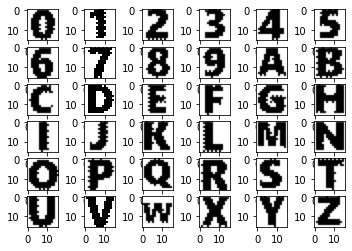

In [20]:
# Step 1
# Get the image and change every image to an 256-dimention vector
dataSet = np.zeros([36, 256])
f=lambda x: x + 55 if x > 9 else x + 48
for i in range(0, 36):
    # TODO Change PNG to jpg
    inputImageDir = './dataSet1/' + chr(f(i)) + str(1) + '.PNG'
    inputImage = Image.open(inputImageDir)
    inputImage = inputImage.convert("1")
    plt.subplot(6,6,i+1)
    plt.imshow(inputImage)
    inputImage.save(inputImageDir)
    data = inputImage.getdata()
    array = np.array(data)/255
    dataSet[i] = array
dataSet = np.array(dataSet)

In [21]:
# Step 2
# define a neural network
class Perceptron(nn.Module):

    def __init__(self, input_size, d_hidden, num_classes):
        super(Perceptron, self).__init__()
        self.linear0 = nn.Linear(input_size, d_hidden[0])
        self.activate0 = nn.Sigmoid()
        self.linear1 = nn.Linear(d_hidden[0], d_hidden[1])
        self.activate1 = nn.Sigmoid()
        self.linear2 = nn.Linear(d_hidden[1], d_hidden[2])
        self.activate2 = nn.Sigmoid()
        self.linear3 = nn.Linear(d_hidden[2], num_classes)
        self.activate3 = nn.Sigmoid()

    def forward(self, x):
        res = self.linear0(x)
        res = self.activate0(res)
        res = self.linear1(res)
        res = self.activate1(res)
        res = self.linear2(res)
        res = self.activate2(res)
        res = self.linear3(res)
        res = self.activate3(res)
        return res

In [22]:
class DigitDataset(Dataset):
    def __init__(self, dataset, label_list):
        self.dataset = dataset
        self.label_list = label_list
    def __len__(self):
        return len(self.label_list)
    def __getitem__(self, idx):
        data = self.dataset[idx]
        label = self.label_list[idx]
        return {
            'data': torch.from_numpy(data).float(),
            'label': torch.from_numpy(label).float()
        }

In [23]:
# Parameters of training
learning_rate = 0.001
# Train until the error become the lowest
# get the optimization of MAE or MSE
num_epochs = 600
batch_size, input_size, num_classes = 36, 256, 256
d_hidden=[300, 350, 300]

# Load the dataset
train_dataset = DigitDataset(dataset = dataSet, label_list = dataSet)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False)
device = torch.device('cpu')
model = Perceptron(input_size=input_size, d_hidden=d_hidden,num_classes=num_classes).to(device)

# Setup for noise training
if not os.path.exists('./models1'):
    os.mkdir('./models1')
torch.save(model, './models1/net_untrained.pkl')
for i in range(5):
    if not os.path.exists('./models1/' + str(i) + '/'):
        os.mkdir('./models1/' + str(i) + '/')

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [24]:
# Step 3
model = Perceptron(input_size=input_size, d_hidden=d_hidden, num_classes=num_classes).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
def train(dataloader, model, num_epochs):
    # research regarding epoch to explain why we need that many iterations (num_epochs)
    for epoch in range(num_epochs):
        losses = []
        ERROR_Train = []
        model.train() 
        for i, data in enumerate(dataloader, 0):
            model.zero_grad()
            # data['data'] is each image data in dataset
            real_cpu, label_cpu = data['data'], data['label']
#             if torch.cuda.is_available():
#                 real_cpu = real_cpu.cuda() 
#                 label_cpu = label_cpu.cuda()
            real = real_cpu
            label = label_cpu
            inputv = Variable(real)
            labelv = Variable(label)
            output = model(inputv)
            err = criterion(output, labelv) 
            err.backward() 
            optimizer.step() 

            losses.append(err.data.item())
            error = label - output.data
#             print(error.shape)
            ERROR_Train.extend(error)
#         print(ERROR_Train)
        MAE = torch.mean(torch.abs(torch.stack(ERROR_Train)))
        ME = torch.mean(torch.stack(ERROR_Train))
        STD = torch.std(torch.stack(ERROR_Train)) 
        if epoch % 10 == 0 or epoch == num_epochs - 1:
            print('[%d/%d] Loss: %.4f MAE: %.4f Mean Error: %.4f STD: %.4f' % (epoch, num_epochs, np.average(losses), MAE, ME, STD))
    return output, model

# Start training        
output, model = train(train_loader, model, num_epochs)
# print(output.type)

[0/600] Loss: 0.2558 MAE: 0.5001 Mean Error: 0.0816 STD: 0.4991
[10/600] Loss: 0.1719 MAE: 0.3403 Mean Error: 0.0337 STD: 0.4132
[20/600] Loss: 0.1686 MAE: 0.3292 Mean Error: -0.0005 STD: 0.4107
[30/600] Loss: 0.1675 MAE: 0.3326 Mean Error: -0.0031 STD: 0.4093
[40/600] Loss: 0.1669 MAE: 0.3340 Mean Error: 0.0012 STD: 0.4086
[50/600] Loss: 0.1666 MAE: 0.3354 Mean Error: 0.0038 STD: 0.4081
[60/600] Loss: 0.1653 MAE: 0.3345 Mean Error: 0.0023 STD: 0.4066
[70/600] Loss: 0.1584 MAE: 0.3272 Mean Error: 0.0017 STD: 0.3980
[80/600] Loss: 0.1435 MAE: 0.3036 Mean Error: 0.0022 STD: 0.3789
[90/600] Loss: 0.1349 MAE: 0.2832 Mean Error: 0.0060 STD: 0.3673
[100/600] Loss: 0.1293 MAE: 0.2743 Mean Error: 0.0028 STD: 0.3596
[110/600] Loss: 0.1253 MAE: 0.2632 Mean Error: 0.0052 STD: 0.3540
[120/600] Loss: 0.1224 MAE: 0.2571 Mean Error: 0.0048 STD: 0.3498
[130/600] Loss: 0.1199 MAE: 0.2515 Mean Error: 0.0053 STD: 0.3462
[140/600] Loss: 0.1175 MAE: 0.2465 Mean Error: 0.0051 STD: 0.3427
[150/600] Loss: 0.1

In [27]:
# Step 4
# Step 4a
# TODO create new for dataset 1
if not os.path.exists('./ass1output'):
    os.mkdir('./ass1output')
output_np = output.detach().numpy()
print(output_np.shape)
torch.save(model, './models1/net_trained.pkl')
# output_dataset = np.zeros([36, 256])
output_dataset2 = model(torch.from_numpy(dataSet).float())
for i in range(36):
    output_img = output_np[i].reshape(16, 16)*255
    img = Image.fromarray(np.uint8(output_img))
    img = img.convert("1")
    output_path = './ass1output/' + str(i) + '.png'
    img.save(output_path)
    data = img.getdata()
    array = np.array(data)/255
    output_dataset[i] = array


(36, 256)


In [31]:
# Step 4
# Step 4b
# Export the image after training
# Before executing this block, create a folder called "output"

# read dataset2 images
dataSet2 = np.zeros([36, 256])
f=lambda x: x + 55 if x > 9 else x + 48
for i in range(0, 36):
    # TODO Change PNG to jpg
    inputImageDir = './dataSet2/' + chr(f(i)) + str(2) + '.jpg'
    inputImage = Image.open(inputImageDir)
    inputImage = inputImage.convert("1")
    plt.subplot(6,6,i+1)
    plt.imshow(inputImage)
    inputImage.save(inputImageDir)
    data = inputImage.getdata()
    array = np.array(data)/255
    dataSet2[i] = array
dataSet2 = np.array(dataSet2)

if not os.path.exists('./ass2output'):
    os.mkdir('./ass2output')
output_np = output.detach().numpy()
print(output_np.shape)
torch.save(model, './models1/net_trained.pkl')
output_dataset = np.zeros([36, 256])
output_dataset2 = model(torch.from_numpy(dataSet2).float())
output_np = output_dataset2.detach().numpy()
for i in range(36):
    output_img = output_np[i].reshape(16, 16)*255
    img = Image.fromarray(np.uint8(output_img))
    img = img.convert("1")
    output_path2 = './ass2output/' + str(i) + '.png'
    img.save(output_path2)
    data = img.getdata()
    array = np.array(data)/255
    output_dataset[i] = array

(36, 256)


In [32]:
# Calculate Fh
def calculateFh(input_dataset, output_dataset):
    x, y = input_dataset.shape
    Fh_denominator = 0    # Fh分母
    Fh_numerator = 0      # Fh分子
    Fh_array = np.zeros([x])
    for j in range(x):
        for i in range(y):
            if input_dataset[j][i] == 0:
                Fh_denominator = Fh_denominator + 1
                if output_dataset[j][i] == 0:
                    Fh_numerator = Fh_numerator + 1
        Fh = Fh_numerator / Fh_denominator
        Fh_array[j] = Fh
    return Fh_array

In [33]:
# Calculate Ffa
def calculateFfa(input_dataset, output_dataset):
    x, y = input_dataset.shape
    Ffa_denominator = 0    # Ffa分母
    Ffa_numerator = 0      # Ffa分子
    Ffa_array = np.zeros([x])
    for j in range(x):
        for i in range(y):
            if input_dataset[j][i] == 1:
                Ffa_denominator = Ffa_denominator + 1
            if output_dataset[j][i] == 0 and input_dataset[j][i] == 1:
                Ffa_numerator = Ffa_numerator + 1
        Ffa = Ffa_numerator / Ffa_denominator
        Ffa_array[j] = Ffa
    return Ffa_array

In [11]:
Fh_array = calculateFh(dataSet, output_dataset)
Ffa_array = calculateFfa(dataSet, output_dataset)
print(Fh_array)
print(Ffa_array)

[0.98795181 0.99270073 0.99033816 0.99285714 0.98533724 0.98771499
 0.98977505 0.99074074 0.98566879 0.98589563 0.98004988 0.98277718
 0.98414272 0.98495575 0.98280098 0.98320611 0.98438609 0.98514212
 0.98573201 0.98523331 0.98567493 0.98468849 0.98469891 0.98163842
 0.98255034 0.98292787 0.98254162 0.98220503 0.98205607 0.98117988
 0.98174157 0.9822465  0.98226601 0.98179495 0.98221529 0.98174627]
[0.         0.00533333 0.01247772 0.01075269 0.00958466 0.01062888
 0.00920952 0.01259947 0.01193317 0.01188547 0.01142006 0.01119925
 0.01164295 0.01222494 0.01183658 0.01220388 0.01189263 0.01143791
 0.01137761 0.01108842 0.01095198 0.01203852 0.01268773 0.01293532
 0.01320528 0.012984   0.01281187 0.01243727 0.0122131  0.01179581
 0.01218553 0.01178035 0.01147511 0.0113045  0.010947   0.01096306]


In [12]:
# TODO: Step 4c: Answer 2 questions from canvas
# Step 4d Graph Fh as a function of Ffa for each exemplar in the input dataset
# TODO calculate twice for dataset1 and dataset2

In [13]:
# Step 5
def gaussian_noise(img, mean, sigma, percentage):
    # Generate gauss noise
    print(img)
    gaussian_out=img
    noise = np.random.normal(mean, sigma, int(percentage*256))
    # Add the noise to image
    gp = np.random.uniform(0,255,int(percentage*256))
    for i in range(int(percentage*256)):
        if gaussian_out[int(gp[i])]==1:
            gaussian_out[int(gp[i])]-=abs(noise[i])
        else:
            gaussian_out[int(gp[i])]+=abs(noise[i])
    #gaussian_out = img + noise
    # Make the value between 0 and 1
    return gaussian_out

gaussian_dataset = np.zeros([5, 9, 36, 256])
std = [0.001, 0.002, 0.003, 0.005, 0.01, 0.02, 0.03, 0.05, 0.1]
perc = [0.1, 0.2, 0.25, 0.3, 0.35]

if not os.path.exists('./input_noise2/'):
        os.mkdir('./input_noise2/')
for k in range(5):
    if not os.path.exists('./input_noise2/'+ str(perc[k]) + '/' ):
        os.mkdir('./input_noise2/' + str(perc[k]) + '/' )

for k in range(5):
    for j in range(9):
        if not os.path.exists('./input_noise2/' + str(perc[k]) + '/' + str(std[j])):
            os.mkdir('./input_noise2/' + str(perc[k]) + '/' + str(std[j]))
        for i in range(36):
            inputImage = dataSet[i]
            gaussian_data = gaussian_noise(inputImage, 0, std[j], perc[k])
            img = gaussian_data.reshape(16, 16)*255
            img = Image.fromarray(np.uint8(img))
            img.convert("1")
            
            inputImageDir = './input_noise2/' + str(perc[k]) + '/' + str(std[j]) + '/' + str(i) + '.png'
            img.save(inputImageDir)
            gaussian_dataset[k][j][i] = gaussian_data
gaussian_dataset = np.array(gaussian_dataset)

Fh_noise_array = np.zeros([5, 9, 36])
Ffa_noise_array = np.zeros([5, 9, 36])

# Train 9 datasets with noise
if not os.path.exists('./output_noise2/'):
        os.mkdir('./output_noise2/')
for k in range(5):
    if not os.path.exists('./output_noise2/' + str(perc[k]) + '/'):
        os.mkdir('./output_noise2/' + str(perc[k]) + '/')
for k in range(5):
    for j in range(9):
        train_noise_dataset = DigitDataset(dataset = gaussian_dataset[k][j], label_list = dataSet)
        train_noise_loader = DataLoader(dataset=train_noise_dataset, batch_size=batch_size, shuffle=False)
        print('Training dataset with noise standard deviation ' + str(std[j]))
    #     model_noise = torch.load('./models/net_untrained.pkl') #  Load the model that trained before
        model_noise = Perceptron(input_size=input_size, d_hidden = d_hidden, num_classes=num_classes).to(device)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model_noise.parameters(), lr=learning_rate)

        output_noise, model_noise = train(train_noise_loader, model_noise, num_epochs)   # Train
        torch.save(model_noise, './models2/' + str(k) + '/' + 'net_trained_' + str(std[j]) + '.pkl')
        model_noise = torch.load('./models2/' + str(k) + '/' + 'net_trained_'+ str(std[j]) + '.pkl')
    #     output_noise = model_noise(torch.from_numpy(gaussian_dataset[j]).float()) # Use the model trained before to test
        print('------------------------------------')
        output_noise = model_noise(torch.from_numpy(dataSet).float())
        output_noise_np = output_noise.detach().numpy()     # Get the output
    #     print(output_noise_np)
        output_noise_dataset = np.zeros([36, 256])
    #     Make the output only has 0 or 1

        if not os.path.exists('./output_noise2/' + str(perc[k]) + '/' + str(std[j])):
            os.mkdir('./output_noise2/' + str(perc[k]) + '/' + str(std[j]))
    
    
        for i in range(36):
            output_noise_img = output_noise_np[i].reshape(16, 16)*255
            img = Image.fromarray(np.uint8(output_noise_img))
            img = img.convert("1")
            output_path = './output_noise2/' + str(perc[k]) + '/' + str(std[j]) + '/' + str(i) + '.png'
            img.save(output_path)
            data = img.getdata()
            array = np.array(data)/255
            output_noise_dataset[i] = array
#     Calculate Fh and Ffa
    #Fh = calculateFh(dataSet, output_noise_dataset)
    #Ffa = calculateFfa(dataSet, output_noise_dataset)
    #Fh_noise_array[j] = Fh
    #Ffa_noise_array[j] = Ffa
print('------------Fh_noise_array------------')
print(Fh_noise_array)
print('------------Ffa_noise_array------------')
print(Ffa_noise_array)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1.
 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1.
 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1.
 1. 1. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1.
 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1.
 1. 1. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1.
 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1.
 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0.
 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0.
 

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 0.
 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0.
 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 1.
 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0.
 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 1. 1. 1.
 1. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1.
 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1.
 

[1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 0.00000000e+00 0.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 9.99846664e-01 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 9.98045561e-01 1.00000000e+00
 1.00000000e+00 1.000000

[1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
 1.00000000e+00 0.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
 9.99876946e-01 0.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 0.00000000e+00 1.40820919e-03 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 9.98172629e-01
 1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
 1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.000000

[1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 9.99027684e-01
 9.99763409e-01 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00041435e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
 1.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 9.99929831e-01 1.00000000e+00 1.00000000e+00 1.00000000e+00
 0.00000000e+00 0.00000000e+00 1.00000000e+00 1.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00000000e+00 1.00000000e+00 9.99595242e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.000000

[1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 9.96709281e-01 9.98712687e-01 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 9.99135961e-01
 1.00139363e+00 9.99129668e-01 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 0.00000000e+00 1.00000000e+00
 0.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.98315435e-03 1.00000000e+00 1.00000000e+00 1.00000000e+00
 9.99530470e-01 1.00000000e+00 1.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 0.00000000e+00 0.00000000e+00 7.80231258e-04
 0.00000000e+00 0.00000000e+00 9.98921813e-01 1.00000000e+00
 1.00000000e+00 9.99855817e-01 9.99579674e-01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.000000

[1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 0.00000000e+00 1.00000000e+00
 0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
 1.00000000e+00 1.00000000e+00 0.00000000e+00 3.08067298e-04
 1.00000000e+00 0.00000000e+00 1.00000000e+00 1.00000000e+00
 9.99574785e-01 9.99726758e-01 9.99933936e-01 9.40250239e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.00000000e+00 1.00000000e+00 9.98816602e-01 0.00000000e+00
 0.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 9.96501831e-01 1.00000000e+00 1.00032665e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.59330914e-03
 0.00000000e+00 9.97295213e-01 1.83391036e-03 2.73603250e-03
 1.00000000e+00 1.00000000e+00 9.99851517e-01 1.00000000e+00
 1.00000000e+00 1.000000

[9.99627043e-01 1.00000000e+00 1.00000000e+00 9.99184647e-01
 1.00000000e+00 9.99153251e-01 1.00000000e+00 1.00000000e+00
 9.99796912e-01 1.00000000e+00 1.00000000e+00 1.00000000e+00
 9.99391498e-01 1.00000000e+00 9.96195339e-01 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 0.00000000e+00 1.00000000e+00
 0.00000000e+00 0.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 9.95996598e-01 1.00000000e+00
 1.00005742e+00 1.00000000e+00 9.97222874e-01 9.95479493e-01
 1.00023044e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.03201893e-03 4.33352904e-03 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 9.98423197e-01
 1.00000000e+00 1.00000000e+00 0.00000000e+00 1.12602710e-03
 0.00000000e+00 1.37042321e-03 0.00000000e+00 9.95051531e-01
 1.00000000e+00 1.00000000e+00 1.00000000e+00 9.98789523e-01
 1.00000000e+00 1.000000

[1.00000000e+00 1.00000000e+00 1.00026018e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 9.99633516e-01
 1.00000000e+00 9.98255975e-01 9.98880640e-01 9.99592136e-01
 9.97467593e-01 1.00000000e+00 1.00000000e+00 1.00000000e+00
 9.94364183e-01 1.00000000e+00 0.00000000e+00 1.00000000e+00
 0.00000000e+00 9.96121809e-01 0.00000000e+00 1.00000000e+00
 9.99634003e-01 1.00000000e+00 1.00000000e+00 0.00000000e+00
 9.99224319e-01 1.92042015e-03 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
 1.39052289e-04 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 9.99177885e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 9.97217828e-01
 1.00000000e+00 9.99748768e-01 1.00000000e+00 0.00000000e+00
 0.00000000e+00 3.20687613e-03 0.00000000e+00 0.00000000e+00
 1.09410054e-03 1.00000000e+00 9.98234097e-01 1.00000000e+00
 4.94151291e-04 0.00000000e+00 1.00000000e+00 1.00000000e+00
 9.99530731e-01 1.000000

[1.00000000e+00 9.98759185e-01 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 9.99442465e-01
 9.98147762e-01 1.00000000e+00 9.98401294e-01 1.00000000e+00
 1.00000000e+00 9.97595136e-01 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00086600e+00 1.00000000e+00 9.99859553e-01
 1.00000000e+00 1.00000000e+00 0.00000000e+00 1.00000000e+00
 0.00000000e+00 1.00000000e+00 9.99854656e-01 9.98905003e-01
 1.00000000e+00 9.97918608e-01 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 9.99856614e-01
 0.00000000e+00 0.00000000e+00 1.00000000e+00 9.95224885e-01
 1.00318949e+00 0.00000000e+00 9.15199114e-04 9.99098741e-01
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00149196e+00
 9.99544996e-01 9.98794245e-01 1.00000000e+00 9.99701552e-01
 0.00000000e+00 5.17083885e-04 1.00668133e+00 1.00000000e+00
 1.00000000e+00 2.44279382e-03 8.97274412e-04 0.00000000e+00
 1.00000000e+00 1.00000000e+00 9.96714436e-01 1.00000000e+00
 9.98143683e-01 1.000000

[1.00000000e+00 1.00000000e+00 9.99894628e-01 9.99024753e-01
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 9.95950563e-01 1.00000000e+00 9.99656239e-01
 9.99872087e-01 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 9.98703255e-01 1.00000000e+00 0.00000000e+00
 9.07077769e-04 1.00000000e+00 0.00000000e+00 6.09928522e-03
 9.98440103e-01 0.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 9.95416978e-01 9.99178485e-01 9.93583754e-01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 9.95887579e-01 1.00076509e+00 1.00000000e+00
 9.99859279e-01 1.00000000e+00 1.00000000e+00 9.99016098e-01
 1.00000000e+00 1.00000000e+00 1.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 9.99786393e-01 1.00000000e+00 1.00000000e+00 1.00000000e+00
 9.99752237e-01 1.00000000e+00 1.00000000e+00 9.99787580e-01
 1.00000000e+00 9.952095

[1.00000000e+00 9.98759185e-01 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 9.99442465e-01
 9.98147762e-01 1.00000000e+00 9.98401294e-01 1.00000000e+00
 1.00000000e+00 9.97595136e-01 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00086600e+00 9.96115876e-01 1.00519009e+00
 1.00000000e+00 1.00000000e+00 2.74482235e-02 1.00000000e+00
 0.00000000e+00 1.00000000e+00 1.00260142e+00 9.98905003e-01
 1.00000000e+00 9.97918608e-01 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 9.84969501e-01 9.99856614e-01
 0.00000000e+00 0.00000000e+00 1.00000000e+00 9.95224885e-01
 1.00318949e+00 0.00000000e+00 9.15199114e-04 9.99098741e-01
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00149196e+00
 9.99544996e-01 9.98794245e-01 1.00000000e+00 1.00351381e+00
 0.00000000e+00 5.17083885e-04 1.00668133e+00 1.00000000e+00
 1.00000000e+00 2.44279382e-03 8.97274412e-04 0.00000000e+00
 1.00000000e+00 1.00000000e+00 9.96714436e-01 1.00000000e+00
 9.98143683e-01 1.000000

[1.00361752e+00 1.00000000e+00 9.89582207e-01 1.00000000e+00
 9.99687889e-01 9.96613370e-01 9.96921411e-01 9.98934483e-01
 1.00000000e+00 1.00000000e+00 1.00000000e+00 9.99689607e-01
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 3.04335622e-03 8.33596792e-03
 9.96061075e-01 7.60742221e-03 1.30393078e-02 1.00000000e+00
 9.97463485e-01 0.00000000e+00 9.84142902e-01 1.00120317e+00
 1.00594128e+00 1.00000000e+00 1.00000000e+00 1.00022724e+00
 1.00000000e+00 1.75681626e-02 2.48701951e-03 0.00000000e+00
 5.41255069e-04 7.33641390e-04 1.11158778e-02 1.00000000e+00
 9.99696793e-01 2.99505792e-03 5.70621655e-04 0.00000000e+00
 1.00000000e+00 9.99915180e-01 9.77989187e-01 1.00000000e+00
 9.98778165e-01 9.97287980e-01 7.85558895e-03 0.00000000e+00
 0.00000000e+00 9.35614554e-04 1.42990092e-03 1.00000000e+00
 1.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.00000000e+00 9.98116011e-01
 1.00000000e+00 1.000000

[9.99420416e-01 1.00612247e+00 1.00000000e+00 9.99489684e-01
 9.94776031e-01 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00362247e+00 1.00000000e+00
 9.98885744e-01 1.00000000e+00 1.00000000e+00 1.00000000e+00
 4.23330811e-03 1.00000000e+00 2.19664889e-03 0.00000000e+00
 0.00000000e+00 1.00017187e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 0.00000000e+00 9.99849806e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
 9.97721723e-01 3.41229495e-03 8.33353024e-03 2.80300570e-03
 0.00000000e+00 1.80365641e-04 0.00000000e+00 1.00068377e+00
 9.93873957e-01 1.00000000e+00 2.18088374e-03 0.00000000e+00
 0.00000000e+00 5.38749303e-03 8.02668475e-03 1.00000000e+00
 1.00531113e+00 9.94492256e-01 1.35913722e-03 0.00000000e+00
 0.00000000e+00 0.00000000e+00 6.14571663e-04 1.00000000e+00
 1.00000000e+00 9.96791506e-01 0.00000000e+00 5.95195409e-03
 0.00000000e+00 0.00000000e+00 1.28897442e-03 1.00000000e+00
 1.00000000e+00 9.986994

[9.94296395e-01 1.00000000e+00 9.99775058e-01 9.99625841e-01
 9.99564198e-01 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 9.98176507e-01 1.00000000e+00
 9.99093409e-01 9.98799697e-01 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 9.93445629e-01 0.00000000e+00
 1.00000000e+00 1.00000000e+00 0.00000000e+00 1.00000000e+00
 4.98681246e-03 1.00000000e+00 9.97824683e-01 1.00000000e+00
 0.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 9.92770984e-01 1.00000000e+00 2.28336521e-02 0.00000000e+00
 0.00000000e+00 1.00000000e+00 6.08705595e-03 0.00000000e+00
 0.00000000e+00 0.00000000e+00 2.17609920e-03 9.99375193e-01
 0.00000000e+00 0.00000000e+00 9.57732875e-05 1.03248708e+00
 9.99136501e-01 1.00000000e+00 0.00000000e+00 0.00000000e+00
 1.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.00000000e+00 1.00000000e+00
 0.00000000e+00 3.07783156e-02 1.00000000e+00 1.00079959e+00
 1.00000000e+00 1.233584

 1.00000000e+00 9.98323247e-01 1.00000000e+00 1.00000000e+00]
[1.00000000e+00 9.98759185e-01 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 9.99442465e-01
 9.98147762e-01 1.00000000e+00 9.98401294e-01 1.00000000e+00
 1.00000000e+00 9.97595136e-01 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00086600e+00 9.96115876e-01 1.00519009e+00
 1.00000000e+00 9.80487078e-01 2.74482235e-02 1.00000000e+00
 4.16656941e-03 1.00000000e+00 1.00260142e+00 9.98905003e-01
 1.00000000e+00 1.01470881e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 9.84969501e-01 9.99856614e-01
 0.00000000e+00 0.00000000e+00 1.00000000e+00 1.00462354e+00
 1.00318949e+00 0.00000000e+00 9.15199114e-04 1.01975000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00149196e+00
 9.99544996e-01 9.98794245e-01 1.00000000e+00 1.00351381e+00
 0.00000000e+00 5.17083885e-04 1.00668133e+00 1.00000000e+00
 1.00000000e+00 2.44279382e-03 1.31336924e-03 0.00000000e+00
 1.00000000e+00 1.00000

[9.99912618e-01 1.00000000e+00 9.98750293e-01 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 9.89629153e-01 9.96779572e-01
 1.01508868e+00 9.90579175e-01 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00347959e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 0.00000000e+00 0.00000000e+00 1.00285719e+00 9.65877738e-01
 9.92669360e-01 1.00000000e+00 1.00000000e+00 1.00000000e+00
 9.98231564e-01 9.97443715e-01 1.00000000e+00 9.99225109e-01
 1.00114135e+00 1.00309781e+00 1.00000000e+00 0.00000000e+00
 3.50586092e-03 0.00000000e+00 9.90896858e-01 1.00000000e+00
 1.01423963e+00 9.98481993e-01 1.00000000e+00 1.00000000e+00
 9.99846664e-01 1.00000000e+00 9.93205817e-01 1.00000000e+00
 9.98801365e-01 1.00000000e+00 1.00000000e+00 0.00000000e+00
 0.00000000e+00 1.33752970e-03 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 9.98045561e-01 9.89609226e-01
 1.00000000e+00 1.000000

[1.00000000e+00 1.00000000e+00 9.98669018e-01 1.00000000e+00
 1.00000000e+00 9.98407601e-01 1.00000000e+00 1.01355808e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 9.97021406e-01
 1.00205529e+00 1.00000000e+00 1.00000000e+00 9.99936545e-01
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 3.25953005e-03 1.00000000e+00 0.00000000e+00
 1.00000000e+00 1.21546108e-03 1.02086591e+00 9.95836050e-01
 9.99325906e-01 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00039858e+00
 1.00000000e+00 0.00000000e+00 2.16591204e-04 9.86190204e-01
 1.00000000e+00 1.00000000e+00 9.94225567e-01 9.97264089e-01
 9.96563366e-01 1.00000000e+00 9.86421160e-01 4.69084432e-04
 1.83020214e-02 4.76851857e-03 0.00000000e+00 1.00000000e+00
 1.00070526e+00 9.97671741e-01 0.00000000e+00 2.70261947e-02
 1.00000000e+00 9.99595636e-01 9.77594702e-01 9.92082268e-01
 9.77796483e-01 1.000000

[9.95826510e-01 9.81463366e-01 1.00000000e+00 1.00000000e+00
 9.98930824e-01 9.98396895e-01 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 9.98424263e-01 9.76967867e-01
 1.00000000e+00 1.00000000e+00 9.96646322e-01 1.00435411e+00
 1.00000000e+00 0.00000000e+00 1.00000000e+00 1.90603685e-03
 1.00000000e+00 4.25041458e-02 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 0.00000000e+00 1.00077374e+00
 5.93612271e-04 1.00000000e+00 1.00200914e-02 9.94732756e-01
 1.00110820e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.34950157e-04 0.00000000e+00 0.00000000e+00 1.00000000e+00
 1.00537977e+00 9.99422571e-01 1.39956536e-03 2.04726908e-03
 0.00000000e+00 0.00000000e+00 1.00000000e+00 1.00000000e+00
 9.97657580e-01 9.99938733e-01 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.00434456e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 0.00000000e+00
 1.00604303e+00 1.00000000e+00 9.98927009e-01 1.00000000e+00
 9.84153274e-01 0.000000

[1.00957943e+00 1.00000000e+00 1.00000000e+00 9.95622670e-01
 9.98069867e-01 9.99216150e-01 1.00000000e+00 1.00000000e+00
 9.84448635e-01 9.97744247e-01 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 9.95311341e-01 1.00181748e+00
 1.00000000e+00 1.00288379e+00 0.00000000e+00 1.00000000e+00
 8.25537103e-03 9.71539873e-01 0.00000000e+00 9.99017489e-01
 2.47356080e-04 9.65784457e-01 1.00000000e+00 0.00000000e+00
 1.00000000e+00 1.00000000e+00 9.98930421e-01 1.00000000e+00
 1.00000000e+00 9.93054916e-01 0.00000000e+00 5.82087019e-04
 1.02379000e-02 0.00000000e+00 0.00000000e+00 1.00000000e+00
 1.00000000e+00 4.85444266e-03 0.00000000e+00 6.59557924e-04
 1.64428170e-03 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00465189e+00 0.00000000e+00 9.06835378e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.02150357e+00
 9.62103986e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
 8.15299349e-03 0.00000000e+00 1.00000000e+00 1.00000000e+00
 9.99940237e-01 1.000000

[1.00000000e+00 1.00000000e+00 1.00000000e+00 9.83318779e-01
 9.98198098e-01 9.98032442e-01 1.00000000e+00 1.00000000e+00
 9.99486683e-01 9.92321252e-01 1.00000000e+00 9.98700885e-01
 1.00000000e+00 9.96970747e-01 1.00000000e+00 9.90642423e-01
 3.02433651e-02 0.00000000e+00 0.00000000e+00 2.54701243e-03
 0.00000000e+00 9.94260273e-03 1.00419324e+00 1.00000000e+00
 5.64305899e-05 5.15643256e-03 1.00000000e+00 1.00000000e+00
 4.70592291e-04 2.50692190e-03 0.00000000e+00 2.52275489e-02
 0.00000000e+00 3.53314099e-04 6.62055820e-03 5.23947209e-06
 0.00000000e+00 9.99563859e-01 1.00000000e+00 1.00000000e+00
 0.00000000e+00 7.32809477e-03 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.34895974e-04 1.00000000e+00 1.00000000e+00
 9.98341981e-01 0.00000000e+00 1.44973666e-02 0.00000000e+00
 7.70272977e-03 1.00000000e+00 1.00000000e+00 1.27055062e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
 1.00000000e+00 0.00000000e+00 9.83049651e-01 1.00000000e+00
 9.97370463e-01 0.000000

 1.00000000e+00 1.00000000e+00 9.98491022e-01 1.00000000e+00]
[1.00000000e+00 1.00000000e+00 1.00000000e+00 9.97367257e-01
 9.99027905e-01 9.97585477e-01 9.98601695e-01 9.98451676e-01
 1.00000000e+00 9.99655478e-01 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 9.72489196e-01 9.99744562e-01
 9.97449619e-01 1.00000000e+00 1.00000000e+00 9.87935891e-01
 1.00000000e+00 0.00000000e+00 1.03119742e-03 1.00000000e+00
 0.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 9.95791133e-01 1.00000000e+00 1.00000000e+00
 1.00000000e+00 9.96497543e-01 1.00533919e+00 9.91326318e-01
 1.72239837e-02 4.55524774e-03 9.98984424e-01 1.04631426e+00
 1.00000000e+00 0.00000000e+00 2.25161983e-02 9.97699190e-01
 1.00000000e+00 9.92613732e-01 1.00000000e+00 9.49760431e-01
 9.99934282e-01 9.90576927e-01 1.00000000e+00 1.72828866e-02
 2.46934782e-02 0.00000000e+00 1.00000000e+00 1.00000000e+00
 2.74898573e-03 0.00000000e+00 2.61512044e-03 6.04521796e-03
 9.93249737e-01 9.99543

[1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 9.92926061e-01 1.00000000e+00 1.00000000e+00
 9.91714152e-01 9.99346502e-01 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.02327298e+00 1.00000000e+00 9.98028168e-01
 1.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
 9.97919738e-01 4.90273525e-03 1.02358840e+00 9.98468363e-01
 1.26147449e-02 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.01460474e+00
 1.00000000e+00 7.81828869e-02 0.00000000e+00 4.32596203e-04
 4.67346167e-03 0.00000000e+00 1.66783875e-02 1.00000000e+00
 1.73852298e-02 0.00000000e+00 0.00000000e+00 2.20436017e-03
 1.90996626e-02 1.00000000e+00 1.00000000e+00 9.93875913e-01
 1.00000000e+00 1.00000000e+00 9.57838771e-04 0.00000000e+00
 1.00276941e-03 0.00000000e+00 1.00614549e+00 1.00000000e+00
 1.00000000e+00 4.31866923e-02 4.61113276e-03 6.19720206e-04
 3.80912610e-04 2.82461799e-04 1.00000000e+00 9.93218874e-01
 9.98494731e-01 3.112207

[1.00000000e+00 1.00000000e+00 9.99894628e-01 9.99024753e-01
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 9.98310942e-01 9.95950563e-01 1.00000000e+00 9.99656239e-01
 9.99872087e-01 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 9.98703255e-01 9.66072249e-01 0.00000000e+00
 9.07077769e-04 9.98893899e-01 0.00000000e+00 1.94024095e-02
 9.99543600e-01 0.00000000e+00 1.00000000e+00 1.00000000e+00
 9.63906413e-01 1.00000000e+00 1.00000000e+00 9.89481874e-01
 9.95416978e-01 9.99178485e-01 9.93583754e-01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 8.89748514e-03 9.99153966e-01 1.00076509e+00 1.00000000e+00
 9.99859279e-01 9.98747753e-01 1.00000000e+00 9.99016098e-01
 1.00000000e+00 9.95671964e-01 9.95743958e-01 9.84897274e-03
 0.00000000e+00 1.61222436e-02 0.00000000e+00 0.00000000e+00
 9.99786393e-01 9.88981374e-01 9.98996454e-01 1.00000000e+00
 9.99752237e-01 9.88587296e-01 1.00000000e+00 1.02034876e+00
 1.00000000e+00 9.952095

[1.00000000e+00 1.00000000e+00 1.00099860e+00 1.00000000e+00
 9.97440085e-01 1.00000000e+00 1.00000000e+00 9.84948052e-01
 1.00956234e+00 9.95357874e-01 1.04256774e+00 1.00000000e+00
 9.97897639e-01 1.00000000e+00 1.00109108e+00 1.00000000e+00
 9.85793175e-01 1.00000000e+00 0.00000000e+00 9.94244391e-01
 2.12298247e-03 9.71296841e-01 0.00000000e+00 9.78024212e-01
 1.00264711e+00 1.00000000e+00 9.46616005e-01 0.00000000e+00
 9.96863589e-01 6.53491369e-03 1.00000000e+00 1.00000000e+00
 9.96214487e-01 0.00000000e+00 0.00000000e+00 3.54135446e-03
 1.40921964e-03 0.00000000e+00 3.52911886e-04 1.01306139e+00
 1.00000000e+00 1.00000000e+00 9.66760090e-01 9.15547769e-03
 8.83716429e-02 6.05766259e-03 1.00000000e+00 1.01178402e+00
 1.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 3.34721828e-03 1.05683630e-02 1.00000000e+00
 9.99626528e-01 1.00000000e+00 1.00410724e+00 1.00000000e+00
 0.00000000e+00 9.79190092e-01 1.01195176e+00 9.99510771e-01
 1.00000000e+00 1.000000

[1.00000000e+00 9.98963469e-01 9.84956587e-01 9.96674393e-01
 1.00745487e+00 9.98152795e-01 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 9.99748818e-01 1.00000000e+00
 9.99592154e-01 1.08088901e+00 1.00000000e+00 1.00548268e+00
 9.97610175e-01 1.00000000e+00 1.00000000e+00 9.94046194e-01
 1.00000000e+00 3.14762891e-02 0.00000000e+00 1.00000000e+00
 3.03349542e-03 6.53637501e-04 9.93564377e-01 9.96472924e-01
 9.77672807e-01 9.99976141e-01 9.96736535e-01 9.97729785e-01
 1.10966424e+00 1.00000000e+00 9.94991203e-01 1.01230530e+00
 0.00000000e+00 5.25096317e-03 4.24564862e-02 9.99742347e-01
 9.94396416e-01 0.00000000e+00 1.27821327e-03 2.49000151e-03
 9.98114275e-01 9.77794826e-01 9.99452274e-01 9.63414545e-01
 1.00000000e+00 9.99392214e-01 9.89626785e-01 9.99471268e-01
 0.00000000e+00 6.16723890e-02 0.00000000e+00 1.00000000e+00
 1.00000000e+00 1.03907293e-02 1.22268344e-03 0.00000000e+00
 6.00123479e-03 1.01550086e+00 1.00000000e+00 9.73503340e-01
 9.71628142e-01 1.000000

[9.82848349e-01 1.00000000e+00 1.03253839e+00 9.85765995e-01
 1.00000000e+00 9.96245169e-01 9.80785940e-01 9.99633516e-01
 1.00000000e+00 9.98255975e-01 1.00449923e+00 1.02853326e+00
 9.97467593e-01 1.00000000e+00 1.00000000e+00 1.00000000e+00
 9.94364183e-01 9.85094543e-01 4.43997824e-05 1.00940475e+00
 0.00000000e+00 9.96121809e-01 2.39123597e-02 1.00000000e+00
 9.99634003e-01 9.93006928e-01 1.00000000e+00 1.20284211e-02
 9.99224319e-01 1.92042015e-03 1.00000000e+00 1.00676298e+00
 1.00000000e+00 9.76255945e-01 7.88112015e-02 0.00000000e+00
 1.39052289e-04 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.00000000e+00 1.00000000e+00 1.04876880e+00 9.99177885e-01
 1.02795255e-01 0.00000000e+00 3.52302184e-03 9.97217828e-01
 1.00000000e+00 1.00867003e+00 1.00000000e+00 0.00000000e+00
 0.00000000e+00 3.20687613e-03 3.31902649e-02 0.00000000e+00
 1.09410054e-03 1.07446584e+00 9.98234097e-01 1.00000000e+00
 4.94151291e-04 1.02825250e-02 1.00000000e+00 9.71901508e-01
 9.99530731e-01 1.000000

[1.00000000e+00 9.86672049e-01 1.00000000e+00 9.97367257e-01
 9.99027905e-01 9.97585477e-01 1.03997021e+00 9.98451676e-01
 1.00000000e+00 9.99655478e-01 9.02241832e-01 1.00000000e+00
 1.00000000e+00 1.00000000e+00 9.72489196e-01 9.99744562e-01
 9.97449619e-01 1.00000000e+00 1.00000000e+00 9.87935891e-01
 1.00000000e+00 0.00000000e+00 1.03119742e-03 1.00000000e+00
 0.00000000e+00 1.00000000e+00 1.00000000e+00 9.98778569e-01
 9.25441811e-01 9.95791133e-01 9.42759857e-01 1.00000000e+00
 1.00000000e+00 9.96497543e-01 1.00533919e+00 9.91326318e-01
 1.72239837e-02 2.66536710e-02 9.98984424e-01 1.08379690e+00
 8.06527583e-01 0.00000000e+00 2.25161983e-02 9.97699190e-01
 8.91765746e-01 9.92613732e-01 9.80526083e-01 9.49760431e-01
 9.99934282e-01 9.90576927e-01 8.49307073e-01 1.72828866e-02
 3.33145971e-02 5.11997318e-02 1.00000000e+00 1.00000000e+00
 2.74898573e-03 0.00000000e+00 2.61512044e-03 7.09753406e-02
 9.93249737e-01 9.99543919e-01 1.00237501e+00 1.00000000e+00
 1.00000000e+00 1.126067

 9.96969527e-01 9.47939390e-01 9.69529854e-01 1.00000000e+00]
[9.54568882e-01 1.00000000e+00 1.00000000e+00 1.00000000e+00
 9.96033615e-01 1.00000000e+00 1.00000000e+00 9.97108197e-01
 9.81728661e-01 9.91516811e-01 1.00000000e+00 1.02483494e+00
 1.00000000e+00 1.00000000e+00 9.45533303e-01 9.99010110e-01
 1.07206953e+00 9.74509693e-01 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.03414025e+00 1.00448483e+00 9.95510977e-01
 9.77535293e-01 5.68812314e-03 9.99759156e-01 1.00000000e+00
 9.58323997e-01 9.99942396e-01 1.00109879e+00 9.98866294e-01
 1.00000000e+00 1.00000000e+00 9.92173138e-01 9.98773067e-01
 0.00000000e+00 0.00000000e+00 9.53184071e-02 9.18042664e-01
 1.40747583e-01 4.75275742e-02 3.27844841e-03 1.00000000e+00
 9.98728723e-01 1.00000000e+00 1.00000000e+00 9.97649814e-01
 8.42450758e-01 9.96384554e-01 1.00000000e+00 3.67053313e-02
 0.00000000e+00 2.69050829e-04 9.79679433e-01 9.88185582e-01
 1.00000000e+00 1.00000000e+00 4.83291098e-02 3.13022006e-02
 7.40193860e-04 1.00000

[1.00000000e+00 9.98759185e-01 1.00000000e+00 1.00000000e+00
 1.00000000e+00 9.47102233e-01 9.91113273e-01 9.99442465e-01
 9.98147762e-01 1.00000000e+00 9.98401294e-01 9.65163501e-01
 9.99511561e-01 1.00689193e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.14655389e+00 9.96115876e-01 1.00561722e+00
 1.00000000e+00 9.80487078e-01 2.74482235e-02 1.00000000e+00
 4.16656941e-03 1.00000000e+00 1.12633248e+00 9.98905003e-01
 1.00000000e+00 1.01470881e+00 9.73877820e-01 1.00000000e+00
 1.00000000e+00 1.00000000e+00 9.84969501e-01 9.99856614e-01
 4.46096911e-02 7.18608983e-04 1.00000000e+00 1.00539159e+00
 1.00318949e+00 9.48406627e-04 9.15199114e-04 1.16562831e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00176554e+00
 1.18842838e+00 9.98794245e-01 1.00000000e+00 1.00351381e+00
 0.00000000e+00 7.30209338e-03 1.01146769e+00 9.46620067e-01
 1.00000000e+00 5.18315670e-02 2.58356912e-01 3.53100309e-02
 9.49254871e-01 1.00000000e+00 9.96714436e-01 9.99092913e-01
 9.98143683e-01 9.455714

[1.00000000e+00 9.91649410e-01 1.00000000e+00 9.83618393e-01
 9.96709281e-01 1.00471166e+00 9.92039059e-01 1.00000000e+00
 9.97477352e-01 9.75336560e-01 9.17526671e-01 9.99679884e-01
 1.05829259e+00 9.99129668e-01 1.00000000e+00 8.63745777e-01
 1.00000000e+00 1.00000000e+00 9.97917398e-01 1.04123796e+00
 1.00000000e+00 1.00000000e+00 4.51178783e-04 9.99189506e-01
 0.00000000e+00 9.84039089e-01 9.06255127e-01 1.00000000e+00
 1.31707358e-02 1.00000000e+00 9.98087528e-01 1.00000000e+00
 9.99530470e-01 9.79207717e-01 1.00000000e+00 7.74776408e-04
 1.11769183e-03 0.00000000e+00 1.00006703e+00 1.00000000e+00
 1.00000000e+00 2.58993830e-04 5.87081847e-04 7.80231258e-04
 0.00000000e+00 0.00000000e+00 1.09620052e+00 9.92958067e-01
 1.00000000e+00 1.00699200e+00 1.17647124e+00 1.07946476e-02
 0.00000000e+00 6.09321168e-02 1.00000000e+00 1.00000000e+00
 1.02670259e+00 9.99595857e-01 9.95994510e-01 2.82321833e-02
 0.00000000e+00 1.00000000e+00 9.80842632e-01 1.00000000e+00
 9.87000255e-01 1.000000

[9.98509243e-01 1.00000000e+00 1.00000000e+00 1.01237696e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 9.98363584e-01
 1.09298499e+00 9.89047897e-01 1.00000000e+00 9.97376967e-01
 1.07191077e+00 1.03593261e+00 1.00041524e+00 9.95996399e-01
 1.00000000e+00 1.00000000e+00 4.05374262e-02 9.60520497e-01
 8.30131602e-02 2.18650841e-03 1.03121935e+00 0.00000000e+00
 9.95167160e-01 1.00000000e+00 0.00000000e+00 3.08067298e-04
 9.34460392e-01 1.85627162e-02 1.00000000e+00 1.00000000e+00
 1.01075881e+00 1.01699243e+00 1.17680516e+00 4.16524803e-02
 3.10003214e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
 9.99566632e-01 1.03976822e+00 1.01650173e+00 0.00000000e+00
 1.69901475e-03 1.00000000e+00 1.05043822e+00 1.00000000e+00
 1.04778785e+00 9.87411232e-01 1.00742068e+00 0.00000000e+00
 0.00000000e+00 3.21497118e-04 0.00000000e+00 2.42124761e-02
 7.00768915e-04 9.97295213e-01 1.83391036e-03 8.08443870e-03
 1.00000000e+00 9.99301190e-01 9.99851517e-01 1.00133542e+00
 1.03851870e+00 1.032906

 1.00000000e+00 9.97935609e-01 9.70595360e-01 1.00000000e+00]
[9.99801792e-01 1.01240282e+00 1.00000000e+00 1.05598328e+00
 1.02905578e+00 9.96240571e-01 1.00000000e+00 9.62380624e-01
 1.02455634e+00 1.05805910e+00 1.00000000e+00 9.45155426e-01
 9.84827452e-01 9.99203284e-01 9.97267781e-01 9.99152672e-01
 1.01372148e+00 9.99405290e-01 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 5.45816975e-02 5.40885361e-02
 1.27184778e-02 0.00000000e+00 1.00000000e+00 9.93729970e-01
 1.00000000e+00 1.00000000e+00 1.00000000e+00 9.60029775e-01
 1.06453460e+00 1.00000000e+00 1.00234401e+00 1.00000000e+00
 1.17528108e-01 4.22985218e-03 8.50312533e-02 2.64338590e-03
 0.00000000e+00 4.71746117e-03 0.00000000e+00 2.07233024e-03
 4.03200126e-02 1.00174275e+00 1.00000000e+00 1.00000000e+00
 9.99228146e-01 9.99962210e-01 9.99549745e-01 9.98713824e-01
 2.76349703e-03 3.67917509e-03 0.00000000e+00 2.94422599e-04
 2.45150442e-03 2.13319738e-02 1.55526641e-02 0.00000000e+00
 9.26085633e-01 1.04042

 1.00000000e+00 1.00141011e+00 9.98595976e-01 1.00000000e+00]
[9.99265971e-01 9.99280473e-01 9.98364115e-01 9.66226617e-01
 9.98838222e-01 1.00000000e+00 9.99149944e-01 1.05075958e+00
 9.99392243e-01 9.99225678e-01 1.00000000e+00 1.00000000e+00
 9.92082786e-01 9.74560051e-01 9.99911902e-01 9.96988141e-01
 1.00820046e+00 1.00000000e+00 1.00000000e+00 9.99597609e-01
 9.98264653e-01 9.96555922e-01 5.78081812e-04 1.33472593e-03
 1.00125015e+00 1.85708356e-03 5.46895776e-04 9.62787060e-01
 9.98829107e-01 9.99696268e-01 9.99215526e-01 9.58195612e-01
 1.00470205e+00 1.00000000e+00 1.00047423e+00 1.00201375e+00
 1.00000000e+00 1.00000000e+00 1.78301675e-01 8.48231529e-04
 1.96995164e-02 0.00000000e+00 0.00000000e+00 9.99592872e-01
 1.00691354e+00 1.00019244e+00 1.01542051e+00 1.00091584e+00
 1.00000000e+00 9.68742408e-01 1.05383919e+00 9.98131030e-01
 9.87897739e-01 9.63200595e-01 1.68492390e-02 0.00000000e+00
 6.97627535e-02 0.00000000e+00 3.69883453e-02 9.93560721e-01
 9.98929556e-01 1.01450

[1.00000000e+00 1.00694695e+00 1.00000000e+00 1.00000000e+00
 9.93005974e-01 1.00851145e+00 9.97503023e-01 1.00000000e+00
 9.95543909e-01 1.13517897e+00 9.99610482e-01 1.00398117e+00
 9.65387178e-01 9.99937983e-01 9.79189205e-01 9.89622794e-01
 9.98969299e-01 9.98778377e-01 9.86725999e-01 9.95893411e-01
 1.00000000e+00 8.83654371e-01 2.68810601e-02 1.00228983e+00
 9.99391903e-01 1.94712429e-03 9.98464646e-01 9.91904906e-01
 5.65847687e-04 1.04238040e+00 9.64373638e-01 9.99556352e-01
 9.86116122e-01 9.97507250e-01 1.00000000e+00 9.99741886e-01
 1.68388630e-02 0.00000000e+00 4.05870449e-02 1.00000000e+00
 1.00000000e+00 5.72821220e-03 8.21862842e-03 1.65854153e-02
 2.94829516e-03 9.97334717e-01 9.92273000e-01 1.00258334e+00
 1.02470493e+00 1.00369239e+00 1.04885317e+00 0.00000000e+00
 3.30026338e-03 5.24773452e-04 1.00000000e+00 1.02566417e+00
 9.99755419e-01 9.95814896e-01 9.96325637e-01 7.95940544e-03
 1.54307013e-02 1.00000000e+00 9.99441474e-01 9.98857304e-01
 1.00041023e+00 9.924056

 1.00000000e+00 9.98323247e-01 1.00000000e+00 1.00000000e+00]
[9.99062795e-01 9.98759185e-01 9.98034770e-01 9.98954492e-01
 9.99968847e-01 9.47102233e-01 9.91113273e-01 9.99442465e-01
 1.00059102e+00 9.97542265e-01 1.00354837e+00 9.65163501e-01
 9.99511561e-01 1.00689193e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.14974507e+00 9.96115876e-01 1.00561722e+00
 1.00000000e+00 9.80487078e-01 3.27127526e-02 1.00000000e+00
 9.03684986e-03 1.00000000e+00 1.12633248e+00 9.98905003e-01
 9.98823195e-01 1.01554056e+00 9.73877820e-01 1.00000000e+00
 1.00000000e+00 1.00000000e+00 9.85205567e-01 9.99856614e-01
 4.50372964e-02 7.18608983e-04 9.99453319e-01 1.00539159e+00
 1.00318949e+00 9.48406627e-04 9.15199114e-04 1.16562831e+00
 1.00000000e+00 9.97908347e-01 1.00000000e+00 1.00176554e+00
 1.18842838e+00 9.98794245e-01 1.00000000e+00 1.00351381e+00
 0.00000000e+00 7.30209338e-03 1.01146769e+00 9.46620067e-01
 1.00000000e+00 5.50045387e-02 2.58356912e-01 3.79951485e-02
 9.49254871e-01 1.00000

[1.00082941e+00 1.01442331e+00 1.00000000e+00 1.05598328e+00
 1.02905578e+00 9.96240571e-01 1.00000000e+00 9.62380624e-01
 1.02569575e+00 1.06133127e+00 1.00000000e+00 9.45155426e-01
 9.84827452e-01 9.99534794e-01 9.97267781e-01 9.99152672e-01
 1.01372148e+00 9.99405290e-01 9.99749725e-01 1.00000000e+00
 9.99221623e-01 1.00000000e+00 5.65598633e-02 5.61921476e-02
 1.27184778e-02 0.00000000e+00 1.00000000e+00 9.93729970e-01
 1.00000000e+00 1.00000000e+00 1.00000000e+00 9.60029775e-01
 1.06699621e+00 9.98382703e-01 1.00234401e+00 1.00000000e+00
 1.17528108e-01 4.22985218e-03 8.50312533e-02 2.64338590e-03
 4.15450270e-03 4.75583509e-03 8.06832132e-04 2.80538915e-03
 4.03200126e-02 1.00174275e+00 9.96447950e-01 1.00000000e+00
 9.99228146e-01 9.99962210e-01 9.99549745e-01 9.98713824e-01
 2.76349703e-03 5.89773604e-03 0.00000000e+00 2.94422599e-04
 2.45150442e-03 2.13319738e-02 1.55526641e-02 0.00000000e+00
 9.26085633e-01 1.04253339e+00 9.98681434e-01 9.66025813e-01
 1.01604756e+00 1.004282

[1.00491279e+00 9.08941683e-01 9.89582207e-01 1.00000000e+00
 1.00162842e+00 1.01523691e+00 9.96921411e-01 1.22520974e+00
 9.90143407e-01 9.61052810e-01 1.07345135e+00 9.99689607e-01
 9.88308625e-01 9.98725354e-01 1.00000000e+00 9.98893887e-01
 9.96684855e-01 1.07103148e+00 3.04335622e-03 8.88696033e-03
 9.97596952e-01 2.44038928e-02 1.48152563e-02 9.97082776e-01
 9.97463485e-01 0.00000000e+00 9.85630012e-01 1.00278378e+00
 1.03251859e+00 9.70554200e-01 1.01087973e+00 1.00070741e+00
 1.00000000e+00 2.04754603e-02 8.19186350e-03 0.00000000e+00
 5.19282347e-02 7.23681742e-03 5.05021298e-02 9.94138160e-01
 9.99696793e-01 4.93996273e-02 6.33020253e-03 0.00000000e+00
 9.99047247e-01 9.99915180e-01 9.96226345e-01 8.89116363e-01
 9.98778165e-01 1.11012183e+00 2.97235133e-02 2.39036088e-02
 2.19758235e-03 4.67234447e-03 3.01726202e-03 9.96663093e-01
 9.69987307e-01 9.53284680e-01 0.00000000e+00 0.00000000e+00
 0.00000000e+00 3.68058847e-03 1.00000000e+00 9.98116011e-01
 9.99659525e-01 1.000000

[9.99420416e-01 1.01000135e+00 9.99282215e-01 9.99489684e-01
 9.94776031e-01 1.00000000e+00 9.99248831e-01 1.21607820e+00
 1.00000000e+00 1.00000000e+00 1.00695230e+00 1.00000000e+00
 1.00003981e+00 9.99225182e-01 1.00049171e+00 1.00000000e+00
 4.23330811e-03 1.00000000e+00 2.19664889e-03 5.30062483e-03
 3.07018708e-02 1.00072167e+00 1.00000000e+00 9.81441043e-01
 9.99353117e-01 9.97882829e-01 0.00000000e+00 1.11085286e+00
 0.00000000e+00 2.65353099e-03 1.64041065e-03 9.43909045e-01
 9.97721723e-01 3.41229495e-03 2.03078077e-02 2.10096706e-01
 0.00000000e+00 1.80365641e-04 7.52804829e-02 1.09758889e+00
 1.00314914e+00 9.98866791e-01 4.62379644e-03 2.96611424e-02
 2.29874496e-03 7.80612922e-03 7.12806909e-02 9.43909741e-01
 1.00576682e+00 9.96166499e-01 2.60769317e-03 1.27996358e-02
 0.00000000e+00 8.76610620e-02 6.14571663e-04 9.98250181e-01
 1.00000000e+00 1.03482147e+00 1.45602993e-03 5.95195409e-03
 0.00000000e+00 3.13454296e-02 1.57943192e-02 1.00000000e+00
 1.00000000e+00 1.000034

[9.80511397e-01 9.99471713e-01 1.00099860e+00 1.00000000e+00
 9.99038668e-01 1.00000000e+00 1.00000000e+00 9.84948052e-01
 1.00956234e+00 9.97171360e-01 1.04493588e+00 1.00000000e+00
 9.97897639e-01 9.99136193e-01 1.00109108e+00 1.00000000e+00
 9.85793175e-01 9.99745602e-01 0.00000000e+00 9.94244391e-01
 2.12298247e-03 9.71296841e-01 1.48685876e-01 9.84881256e-01
 1.00817345e+00 1.00000000e+00 9.47793096e-01 3.12939883e-05
 9.96863589e-01 6.53491369e-03 1.00034682e+00 1.00000000e+00
 9.96741220e-01 7.67037799e-02 8.21631164e-02 3.54135446e-03
 2.83823488e-03 8.19763568e-03 3.52911886e-04 1.01306139e+00
 9.55530538e-01 1.00000000e+00 9.69676910e-01 9.15547769e-03
 9.01307057e-02 6.05766259e-03 1.00000000e+00 1.02668822e+00
 1.00000000e+00 9.99202677e-01 0.00000000e+00 2.20032205e-03
 0.00000000e+00 3.34721828e-03 1.05683630e-02 1.00000000e+00
 9.99626528e-01 9.99945165e-01 1.00410724e+00 9.99525135e-01
 0.00000000e+00 9.79190092e-01 1.01195176e+00 1.04208910e+00
 1.00000000e+00 9.991011

 1.00000000e+00 1.00452813e+00 9.95756184e-01 1.00000000e+00]
[9.99846348e-01 9.99619428e-01 9.99548970e-01 9.98822447e-01
 1.21274739e+00 9.99371316e-01 9.90602919e-01 1.04451007e+00
 9.98731150e-01 1.00471577e+00 1.00000000e+00 9.91009272e-01
 9.97142242e-01 9.99807101e-01 9.99296966e-01 9.98907849e-01
 1.02131655e+00 9.99599009e-01 9.98460959e-01 9.95430487e-01
 9.96050231e-01 8.79846673e-02 1.03175975e-01 1.00101360e+00
 1.72580546e-02 9.77607789e-01 1.00457831e-02 1.00017521e+00
 2.06064688e-03 9.69024284e-01 1.00272018e+00 9.98755350e-01
 1.00186801e+00 9.56500969e-01 9.86105398e-01 1.00510764e+00
 9.76023791e-01 0.00000000e+00 0.00000000e+00 6.31092832e-03
 0.00000000e+00 1.45835778e-03 8.44037533e-02 2.73659174e-02
 1.00000000e+00 1.02769034e+00 9.99566721e-01 9.97056782e-01
 1.05661410e+00 1.00000000e+00 1.00000000e+00 1.00048009e+00
 1.00698775e+00 2.62523582e-03 4.64665014e-03 0.00000000e+00
 4.78047240e-03 1.03690296e-02 0.00000000e+00 1.00113680e+00
 1.00000000e+00 1.01425

 1.00005173e+00 1.00000000e+00 9.99822347e-01 1.00000000e+00]
[9.22172572e-01 9.88752462e-01 1.00033965e+00 1.07254532e+00
 9.99287586e-01 9.98407601e-01 1.00000000e+00 1.01544618e+00
 9.96708954e-01 1.00000000e+00 1.00000000e+00 9.97021406e-01
 1.00559970e+00 9.98316916e-01 1.00649425e+00 1.04666931e+00
 1.00000000e+00 1.00084009e+00 1.00000000e+00 9.98233060e-01
 1.00000000e+00 3.25953005e-03 1.00000000e+00 5.33981758e-02
 1.00119902e+00 1.21546108e-03 1.02883215e+00 9.95836050e-01
 9.99325906e-01 1.00146444e+00 1.00000000e+00 9.89324617e-01
 1.02385017e+00 9.98245569e-01 1.00000000e+00 9.77519350e-01
 0.00000000e+00 7.21342922e-03 9.82685578e-02 1.00039858e+00
 1.00000000e+00 0.00000000e+00 2.16591204e-04 1.08022861e+00
 7.50862759e-01 1.00000000e+00 9.94225567e-01 1.00063255e+00
 1.00225101e+00 9.99502504e-01 9.90489152e-01 1.22198235e-02
 2.45100874e-02 9.19152219e-03 0.00000000e+00 1.00000000e+00
 1.00070526e+00 9.97671741e-01 5.83576187e-03 3.75438989e-02
 9.99802274e-01 1.13993

[9.98627292e-01 9.99349297e-01 1.00000000e+00 9.83618393e-01
 9.96709281e-01 1.00471166e+00 9.92039059e-01 1.00000000e+00
 9.98209858e-01 9.90125090e-01 9.17526671e-01 9.99679884e-01
 1.06022573e+00 9.99129668e-01 1.00000000e+00 8.64200918e-01
 1.00583755e+00 1.00000000e+00 9.97917398e-01 1.04123796e+00
 1.00000000e+00 9.99885339e-01 1.46205711e-03 9.99189506e-01
 0.00000000e+00 9.86560480e-01 9.06255127e-01 9.99911212e-01
 1.31707358e-02 1.00000000e+00 9.98087528e-01 9.99786391e-01
 9.99530470e-01 9.81418316e-01 1.00000000e+00 7.74776408e-04
 4.06993328e-03 0.00000000e+00 1.00016439e+00 9.94482797e-01
 1.00000000e+00 2.58993830e-04 5.87081847e-04 7.80231258e-04
 0.00000000e+00 1.16817649e-03 1.09662549e+00 1.00041494e+00
 1.00000000e+00 1.01848009e+00 1.17647124e+00 1.07946476e-02
 9.81370682e-03 6.09321168e-02 1.00000000e+00 1.00000000e+00
 1.02670259e+00 1.00214305e+00 9.95994510e-01 2.88709247e-02
 5.88085206e-03 1.00000000e+00 9.80842632e-01 1.00000000e+00
 9.87000255e-01 1.000000

[9.99420416e-01 1.01000135e+00 9.99282215e-01 9.99489684e-01
 9.94776031e-01 1.00000000e+00 9.99248831e-01 1.21607820e+00
 1.00000000e+00 1.00000000e+00 1.00695230e+00 1.00000000e+00
 1.00003981e+00 9.99225182e-01 1.00049171e+00 1.00000000e+00
 4.23330811e-03 1.00000000e+00 2.19664889e-03 5.30062483e-03
 3.07018708e-02 1.00072167e+00 1.00000000e+00 9.81441043e-01
 9.99353117e-01 9.97882829e-01 0.00000000e+00 1.11085286e+00
 0.00000000e+00 2.65353099e-03 9.79369059e-03 9.43909045e-01
 9.97721723e-01 3.41229495e-03 2.03078077e-02 2.14582324e-01
 4.60344550e-03 1.80365641e-04 7.52804829e-02 1.09981247e+00
 1.00314914e+00 9.98866791e-01 4.62379644e-03 2.96611424e-02
 2.29874496e-03 7.80612922e-03 7.12806909e-02 9.43909741e-01
 1.00576682e+00 9.96166499e-01 6.13388072e-03 1.27996358e-02
 0.00000000e+00 8.76610620e-02 6.14571663e-04 1.00281165e+00
 1.00000000e+00 1.03482147e+00 1.96750315e-03 6.19847517e-03
 0.00000000e+00 3.41452313e-02 1.57943192e-02 1.00000000e+00
 1.00000000e+00 1.000034

 1.00000000e+00 1.00000000e+00 1.00198832e+00 1.00000000e+00]
[1.00000000e+00 1.00694695e+00 9.99450581e-01 1.00000000e+00
 9.93005974e-01 1.00851145e+00 9.97503023e-01 9.89868476e-01
 9.98933659e-01 1.13517897e+00 9.99610482e-01 1.00398117e+00
 9.65387178e-01 9.99937983e-01 9.79189205e-01 9.89622794e-01
 9.98969299e-01 9.98778377e-01 9.86725999e-01 9.95893411e-01
 1.00000000e+00 8.83654371e-01 2.68810601e-02 1.00573722e+00
 9.99391903e-01 1.94712429e-03 9.99348787e-01 9.91904906e-01
 9.66530299e-03 1.04749235e+00 9.64373638e-01 9.99556352e-01
 9.86116122e-01 9.97507250e-01 9.94435984e-01 1.00191820e+00
 2.49498210e-02 0.00000000e+00 4.05870449e-02 1.00623021e+00
 1.00000000e+00 7.93638981e-03 8.21862842e-03 1.65854153e-02
 2.94829516e-03 9.97334717e-01 9.92273000e-01 1.00258334e+00
 1.03274628e+00 1.00624203e+00 1.04885317e+00 8.67159548e-03
 3.30026338e-03 5.24773452e-04 1.00000000e+00 1.02566417e+00
 1.00126283e+00 9.95814896e-01 9.96325637e-01 1.03164077e-02
 1.54307013e-02 1.00000

[9.98930337e-01 1.00000000e+00 1.00000000e+00 1.01260121e+00
 9.98310397e-01 1.00000000e+00 9.99832501e-01 9.99714007e-01
 1.09298499e+00 9.89047897e-01 1.00000000e+00 1.00120820e+00
 1.07191077e+00 1.03695703e+00 1.00041524e+00 9.97564230e-01
 1.00000000e+00 9.94431476e-01 4.30089678e-02 9.60520497e-01
 8.30131602e-02 2.30881686e-03 1.03121935e+00 7.51378336e-04
 9.95257210e-01 1.00000000e+00 0.00000000e+00 3.08067298e-04
 9.34460392e-01 1.98009414e-02 9.96078424e-01 9.99518535e-01
 1.01075881e+00 1.01740406e+00 1.18264113e+00 4.19540525e-02
 3.27228153e-02 7.25981993e-04 2.44394510e-04 0.00000000e+00
 9.99566632e-01 1.03976822e+00 1.01650173e+00 0.00000000e+00
 1.69901475e-03 9.96547263e-01 1.05043822e+00 9.98631895e-01
 1.05120579e+00 9.87411232e-01 1.00742068e+00 0.00000000e+00
 0.00000000e+00 3.21497118e-04 4.59181876e-04 2.42124761e-02
 1.76654084e-03 9.97295213e-01 1.83391036e-03 1.60608838e-02
 1.00000000e+00 1.00069309e+00 9.99851517e-01 1.00257093e+00
 1.03851870e+00 1.033208

 9.99868622e-01 1.04004033e+00 1.02262955e+00 1.00000000e+00]
[9.38243473e-01 9.96120009e-01 9.87008917e-01 1.00972506e+00
 9.42180026e-01 9.69093195e-01 1.00150680e+00 1.00322180e+00
 9.96648346e-01 1.01298240e+00 1.06572836e+00 1.03423604e+00
 1.01974457e+00 1.00009323e+00 1.01353186e+00 9.99648457e-01
 1.00051238e+00 9.97557448e-01 1.03215409e+00 9.90722604e-01
 1.00000000e+00 8.10589660e-03 9.99759168e-01 4.57744581e-03
 9.83264464e-01 1.99624916e-01 1.13128782e+00 1.00000000e+00
 1.00000000e+00 1.00316413e+00 9.53965251e-01 1.00002374e+00
 9.99518068e-01 1.00830296e+00 9.88333923e-01 1.00196761e+00
 6.71681146e-04 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.76249907e-02 4.09159069e-02 0.00000000e+00 1.03531293e+00
 1.20746827e+00 1.00145808e+00 1.00000000e+00 9.99632283e-01
 1.29983821e+00 9.97537849e-01 9.97994692e-01 8.74509869e-05
 1.62730458e-03 1.33654418e-02 1.01123901e+00 9.91219916e-01
 1.17830290e-03 2.44167936e-02 5.91029003e-03 9.06730034e-04
 9.72217979e-01 1.00000

 9.91224812e-01 1.02373754e+00 9.98491022e-01 1.00000000e+00]
[1.00670495e+00 9.94010000e-01 9.95509820e-01 9.97639735e-01
 1.00000350e+00 9.98316013e-01 1.04113082e+00 9.98451676e-01
 1.00196286e+00 9.99727598e-01 9.02241832e-01 1.00000000e+00
 9.98738945e-01 9.93952154e-01 9.72489196e-01 9.99744562e-01
 9.97449619e-01 1.02943320e+00 9.99130621e-01 9.89051150e-01
 1.00594976e+00 4.59142188e-04 5.84843326e-03 1.00000000e+00
 1.57384242e-03 1.00000000e+00 9.97860783e-01 1.02545689e+00
 9.25441811e-01 9.96057331e-01 9.42759857e-01 9.98149220e-01
 1.00126704e+00 9.96497543e-01 1.00982990e+00 1.00613535e+00
 1.73352229e-02 3.03156457e-02 9.98984424e-01 1.08379690e+00
 8.06527583e-01 3.37040218e-03 2.82623411e-02 1.00494659e+00
 8.99663844e-01 9.97125127e-01 9.89898609e-01 9.52836909e-01
 9.99934282e-01 9.90576927e-01 8.49307073e-01 3.72344126e-02
 3.87834684e-02 6.05915608e-02 9.95739618e-01 1.00854805e+00
 2.74898573e-03 2.02252887e-03 2.61512044e-03 7.32480810e-02
 9.95230792e-01 9.99543

[9.63637423e-01 1.00109131e+00 9.93294862e-01 9.97868218e-01
 1.02581151e+00 9.81369861e-01 9.83337454e-01 1.01495568e+00
 9.99694182e-01 1.00609660e+00 9.98207205e-01 9.90418736e-01
 1.00000000e+00 9.98317616e-01 9.93424231e-01 8.51898565e-01
 1.00000000e+00 3.73771271e-03 9.99750916e-01 0.00000000e+00
 9.98207743e-01 3.81580665e-02 1.00000000e+00 9.99160797e-01
 9.88582874e-01 1.42345342e-02 9.99917129e-01 3.00329453e-02
 1.01042039e+00 1.28919420e-02 1.01740592e+00 1.00150021e+00
 1.01335196e+00 3.22694079e-03 4.15118804e-03 7.50860426e-03
 0.00000000e+00 0.00000000e+00 8.85333381e-02 1.10955807e+00
 1.00212726e+00 0.00000000e+00 6.21124114e-03 0.00000000e+00
 0.00000000e+00 9.82833783e-03 5.29117794e-02 1.00000000e+00
 9.98352114e-01 4.57484012e-02 1.47430291e-03 3.69186520e-03
 2.16013976e-02 1.66918038e-03 1.00000000e+00 1.00348439e+00
 1.00504589e+00 4.28143041e-03 0.00000000e+00 7.29316817e-03
 1.72162735e-01 3.16666317e-02 9.99199011e-01 9.99072937e-01
 1.00000000e+00 1.005396

 1.00250453e+00 9.98491991e-01 1.00275168e+00 1.00000000e+00]
[9.73865434e-01 1.00979156e+00 1.00507823e+00 9.65641108e-01
 9.88641491e-01 1.00000000e+00 1.01726544e+00 9.99439539e-01
 9.31576654e-01 1.00000000e+00 9.98059858e-01 1.00399616e+00
 9.57099299e-01 1.00875963e+00 1.00817347e+00 1.00255573e+00
 1.00000000e+00 1.00000000e+00 1.00353404e-02 1.00000000e+00
 6.94478865e-03 4.80154254e-03 9.99115447e-01 1.06529416e-03
 1.00000000e+00 1.00000000e+00 4.25126127e-02 1.00000000e+00
 1.36649839e-02 7.01663928e-03 9.99803516e-01 1.00413960e+00
 9.98568717e-01 1.00135416e+00 9.98959272e-01 0.00000000e+00
 5.17980443e-03 0.00000000e+00 3.65377058e-02 2.56042665e-02
 9.86375931e-01 9.93197978e-01 1.01172117e+00 0.00000000e+00
 9.07531673e-03 1.00299194e+00 1.00000000e+00 9.98920517e-01
 1.00000000e+00 9.92661830e-01 9.98600110e-01 5.35959700e-02
 6.47796067e-03 3.36213926e-03 1.24526496e-01 1.09272242e-03
 1.00693704e+00 1.00000000e+00 1.02235473e+00 5.41096040e-03
 1.00770246e+00 1.00069

[1.01544666e+00 9.08941683e-01 9.89582207e-01 9.97857830e-01
 1.00550309e+00 1.01523691e+00 9.96921411e-01 1.24498887e+00
 9.90731822e-01 9.61052810e-01 1.10978429e+00 1.02545681e+00
 9.88308625e-01 9.98725354e-01 9.82674485e-01 1.01782324e+00
 1.01100834e+00 1.07103148e+00 1.04131930e-02 1.43661578e-02
 9.97596952e-01 2.61533703e-02 2.39700354e-02 9.97082776e-01
 1.00729035e+00 4.99759311e-03 9.86569474e-01 1.01437189e+00
 1.04047420e+00 9.70554200e-01 1.02830054e+00 1.00070741e+00
 1.00000000e+00 2.04754603e-02 1.54807857e-02 3.82492708e-02
 5.19282347e-02 7.23681742e-03 5.05021298e-02 1.00327728e+00
 9.99696793e-01 4.93996273e-02 2.04106276e-02 2.14724673e-02
 1.00472666e+00 1.00211059e+00 1.00618715e+00 9.01770077e-01
 9.98778165e-01 1.11012183e+00 2.97235133e-02 2.39036088e-02
 1.14499554e-02 4.67234447e-03 3.01726202e-03 1.01856548e+00
 9.69987307e-01 9.59784390e-01 0.00000000e+00 0.00000000e+00
 0.00000000e+00 3.68058847e-03 1.00000000e+00 9.98116011e-01
 1.01651918e+00 1.000000

[1.04492920e+00 1.00000000e+00 9.99320160e-01 9.83318779e-01
 1.12640763e+00 9.98796214e-01 1.00000000e+00 9.96397235e-01
 1.01768019e+00 9.92433572e-01 9.91585005e-01 1.00436917e+00
 1.00000000e+00 9.97998029e-01 1.01605936e+00 9.98538557e-01
 3.44097284e-02 6.38342843e-02 0.00000000e+00 2.37710472e-02
 8.21549254e-03 1.21429022e-02 1.03696463e+00 1.00903630e+00
 5.64305899e-05 3.65350194e-02 1.00000000e+00 9.97722708e-01
 1.13833320e-01 2.50692190e-03 0.00000000e+00 3.97161085e-02
 5.67265488e-03 1.23735847e-01 1.09050972e-02 1.02303475e-02
 3.09242180e-03 1.00290036e+00 9.99098380e-01 1.00000000e+00
 1.20066613e-03 7.32809477e-03 1.00000000e+00 9.97487560e-01
 9.93855471e-01 3.58418919e-02 1.03062375e+00 9.98518769e-01
 1.01681898e+00 1.32215655e-01 1.97730655e-01 6.50445174e-02
 2.15143983e-02 9.85600025e-01 1.02400424e+00 4.74882812e-02
 1.57741329e-02 9.13829251e-03 1.46604977e-03 9.92582001e-01
 9.98548625e-01 1.81975689e-02 9.83049651e-01 1.00783827e+00
 1.09478772e+00 1.433181

[1.03502993e+00 1.02539189e+00 1.04793851e+00 1.00047456e+00
 1.00827554e+00 1.03569834e+00 9.97472958e-01 1.02333054e+00
 9.99796912e-01 9.55582979e-01 9.96469775e-01 1.02431679e+00
 1.03920110e+00 9.99898074e-01 1.01925612e+00 1.00866231e+00
 1.00571282e+00 1.01265817e+00 9.97379157e-01 9.35755048e-01
 1.00655446e+00 1.01659287e+00 1.18352205e-02 1.00123933e+00
 7.09089256e-02 7.68320345e-02 1.00000000e+00 8.76693091e-01
 9.96203107e-01 1.00000000e+00 9.95996598e-01 1.00452195e+00
 1.02754880e+00 1.00000000e+00 1.01354350e+00 1.04689316e+00
 1.02967562e+00 9.76389168e-01 4.23581311e-03 1.60212189e-02
 1.03627931e-01 4.38375311e-02 2.88984054e-02 9.80932709e-01
 1.01036776e+00 1.00000000e+00 1.00000000e+00 1.00270123e+00
 1.00928293e+00 9.85507983e-01 1.05636603e+00 1.00880380e+00
 9.99377238e-01 1.03677090e+00 3.58768542e-02 1.95969490e-02
 8.92191718e-03 2.23918024e-03 5.40850780e-02 9.96507711e-01
 9.88254366e-01 9.94894492e-01 1.00355960e+00 1.04488739e+00
 1.04210415e+00 9.971784

[1.02606461e+00 1.03612942e+00 1.00755074e+00 9.41064808e-01
 1.04087952e+00 9.98396895e-01 9.99426555e-01 9.29018656e-01
 1.03040232e+00 9.57185392e-01 1.01518906e+00 9.89757775e-01
 1.00041756e+00 9.82201194e-01 9.98767469e-01 1.00973002e+00
 1.00454790e+00 5.59506079e-03 9.69154708e-01 5.99759288e-02
 1.00000000e+00 4.26102306e-02 9.95269598e-01 1.02307969e+00
 1.01038506e+00 9.98727289e-01 5.73526182e-04 1.00819432e+00
 4.54851200e-03 1.03961494e+00 1.30993281e-02 9.95409092e-01
 1.00663519e+00 1.17521948e-01 0.00000000e+00 0.00000000e+00
 4.14455611e-02 6.41404160e-02 1.09905894e-02 1.02900295e+00
 1.00645280e+00 1.06012467e+00 4.38772029e-03 3.42142627e-03
 6.36492685e-02 0.00000000e+00 1.03954646e+00 1.00099074e+00
 9.97786426e-01 9.99938733e-01 5.41069972e-02 0.00000000e+00
 5.84237484e-02 3.90560880e-03 1.00582903e+00 1.00000000e+00
 1.00000000e+00 9.88317909e-01 9.94521206e-01 1.10495774e-01
 1.01569485e+00 9.93319536e-01 1.00742394e+00 1.00000000e+00
 1.00407396e+00 6.896115

[9.73865434e-01 1.01094840e+00 1.00507823e+00 1.04833092e+00
 9.88641491e-01 1.00000000e+00 1.01726544e+00 1.01101219e+00
 9.31576654e-01 9.88689318e-01 9.98059858e-01 1.00590479e+00
 9.57099299e-01 1.00875963e+00 1.00817347e+00 1.00255573e+00
 1.00000000e+00 1.00000000e+00 1.00353404e-02 1.00000000e+00
 6.94478865e-03 6.46698165e-02 1.02703687e+00 1.06529416e-03
 1.00000000e+00 1.00931411e+00 4.25126127e-02 1.00000000e+00
 1.36649839e-02 7.01663928e-03 9.99803516e-01 1.00413960e+00
 1.03446398e+00 1.00135416e+00 1.01776908e+00 0.00000000e+00
 5.35693700e-02 0.00000000e+00 3.65377058e-02 2.56042665e-02
 9.86375931e-01 1.00162244e+00 1.01172117e+00 0.00000000e+00
 9.07531673e-03 1.00299194e+00 1.00000000e+00 1.00670562e+00
 1.00000000e+00 9.92661830e-01 9.98600110e-01 6.21253544e-02
 4.45927478e-02 4.18831664e-03 1.24526496e-01 1.09272242e-03
 1.02682788e+00 1.00000000e+00 1.02235473e+00 5.50810788e-02
 1.00770246e+00 1.00069859e+00 9.97320653e-01 1.00280393e+00
 9.99371167e-01 9.465824

[9.77221769e-01 1.00109131e+00 9.93294862e-01 1.02218508e+00
 1.03544545e+00 1.02924875e+00 9.83337454e-01 1.01495568e+00
 9.99694182e-01 1.00724433e+00 1.07036163e+00 1.08116272e+00
 1.00000000e+00 1.05387421e+00 9.93424231e-01 8.51898565e-01
 9.70799030e-01 2.71926280e-02 9.99750916e-01 2.28759234e-02
 9.98207743e-01 3.81580665e-02 9.87330443e-01 9.99160797e-01
 1.00396602e+00 5.54275193e-02 9.99917129e-01 3.00329453e-02
 1.05112754e+00 1.13018665e-01 1.01740592e+00 1.00150021e+00
 1.08016349e+00 3.22694079e-03 4.15118804e-03 7.50860426e-03
 1.53578471e-02 0.00000000e+00 9.62984624e-02 1.10955807e+00
 1.01369597e+00 6.27313078e-02 6.21124114e-03 2.67301999e-02
 0.00000000e+00 9.82833783e-03 5.29117794e-02 1.00000000e+00
 1.01643424e+00 4.57484012e-02 1.16701374e-02 7.07709867e-02
 4.12778820e-02 1.66918038e-03 1.00000000e+00 1.00348439e+00
 1.00504589e+00 1.13441630e-01 0.00000000e+00 7.29316817e-03
 1.86242904e-01 3.16666317e-02 1.03169412e+00 9.99072937e-01
 9.90274889e-01 1.005396

 1.00693795e+00 9.98858502e-01 1.02382674e+00 1.00000000e+00]
[1.07247439e+00 9.51306489e-01 9.99320160e-01 1.01093816e+00
 1.12640763e+00 9.98796214e-01 9.87726365e-01 9.96397235e-01
 1.01768019e+00 1.03068322e+00 9.91585005e-01 1.00436917e+00
 1.00000000e+00 1.00712096e+00 1.01605936e+00 9.98538557e-01
 3.44097284e-02 1.01405369e-01 2.50834072e-02 2.37710472e-02
 8.21549254e-03 1.21429022e-02 1.06169986e+00 1.00903630e+00
 3.07131172e-03 3.65350194e-02 9.85564076e-01 9.97722708e-01
 1.13833320e-01 1.26359336e-02 0.00000000e+00 3.97161085e-02
 5.67265488e-03 1.23735847e-01 1.09050972e-02 2.63401554e-02
 3.09242180e-03 1.00290036e+00 9.99098380e-01 1.00000000e+00
 1.87449642e-02 7.32809477e-03 9.57340578e-01 9.97487560e-01
 9.93855471e-01 3.58418919e-02 1.03062375e+00 9.98518769e-01
 1.01681898e+00 1.32215655e-01 2.31426871e-01 1.25812918e-01
 9.33644388e-02 9.85600025e-01 1.02400424e+00 4.74882812e-02
 2.72678504e-02 9.13829251e-03 1.87668446e-01 1.00747781e+00
 9.98548625e-01 1.81975

[9.28407936e-01 1.12864827e+00 1.02986705e+00 1.07254532e+00
 9.99287586e-01 1.00764308e+00 9.81320045e-01 1.01544618e+00
 1.01171213e+00 1.04548635e+00 1.00000000e+00 1.00191098e+00
 1.02037255e+00 1.01273295e+00 1.04266246e+00 1.05959727e+00
 9.60648566e-01 1.00084009e+00 1.06092915e+00 1.08277809e+00
 8.32399771e-01 1.77478143e-02 9.40103947e-01 5.33981758e-02
 1.00119902e+00 1.04101041e-01 1.04947428e+00 9.95836050e-01
 1.02864896e+00 1.00245591e+00 1.00000000e+00 9.89324617e-01
 1.02385017e+00 9.98245569e-01 9.96066950e-01 1.00234725e+00
 7.37641076e-03 2.24310780e-02 9.82685578e-02 1.04329516e+00
 9.85602224e-01 0.00000000e+00 7.09467093e-03 1.30695833e+00
 7.86378859e-01 1.01040311e+00 1.04740331e+00 1.05388805e+00
 1.03659616e+00 1.02244826e+00 1.01056225e+00 2.12357054e-02
 2.45100874e-02 9.19152219e-03 1.04769224e-02 1.00567012e+00
 1.00070526e+00 1.02293638e+00 6.93195904e-03 4.20882946e-02
 1.01296850e+00 1.20195528e+00 9.81648553e-01 1.05702103e+00
 1.04046520e+00 9.904862

 1.18551782e+00 1.10569737e+00 1.00112536e+00 1.00000000e+00]
[1.02606461e+00 1.03612942e+00 1.13095561e+00 9.41064808e-01
 1.04087952e+00 1.02139986e+00 1.03390002e+00 9.29018656e-01
 1.03040232e+00 9.57185392e-01 1.08090018e+00 1.01541972e+00
 1.00041756e+00 1.03440109e+00 9.98767469e-01 1.00973002e+00
 1.02243795e+00 1.62712975e-02 1.00230668e+00 8.87496257e-02
 1.00000000e+00 4.26102306e-02 1.18746221e+00 1.02307969e+00
 1.01038506e+00 9.98727289e-01 8.93236025e-02 1.00819432e+00
 4.54851200e-03 1.10554671e+00 1.30993281e-02 9.95409092e-01
 1.00663519e+00 1.47142192e-01 0.00000000e+00 0.00000000e+00
 4.14455611e-02 1.12590223e-01 2.10313059e-02 1.07660934e+00
 1.09017203e+00 1.06012467e+00 4.38772029e-03 3.42142627e-03
 6.36492685e-02 0.00000000e+00 1.03954646e+00 1.00099074e+00
 1.01320936e+00 1.01816427e+00 5.41069972e-02 1.52087150e-01
 5.84237484e-02 3.90560880e-03 1.04122299e+00 1.00000000e+00
 1.00000000e+00 9.88317909e-01 9.94521206e-01 1.10495774e-01
 1.01569485e+00 9.93319

[9.73865434e-01 1.01094840e+00 1.12385251e+00 1.05234890e+00
 1.02193035e+00 1.00000000e+00 1.01726544e+00 1.10053069e+00
 9.31576654e-01 1.07576854e+00 1.17261929e+00 1.00590479e+00
 9.67187407e-01 1.00875963e+00 1.00817347e+00 1.00255573e+00
 1.00000000e+00 1.00000000e+00 1.00353404e-02 1.00000000e+00
 6.94478865e-03 6.46698165e-02 1.08076323e+00 1.06529416e-03
 1.00000000e+00 1.00931411e+00 4.25126127e-02 1.00000000e+00
 1.36649839e-02 7.00673100e-02 9.99803516e-01 1.06055816e+00
 1.03538292e+00 1.06440707e+00 1.01776908e+00 0.00000000e+00
 1.16348877e-01 0.00000000e+00 9.89261852e-02 6.73703603e-02
 1.19441654e+00 1.00162244e+00 1.21011003e+00 0.00000000e+00
 9.07531673e-03 1.03093855e+00 1.00000000e+00 1.12007761e+00
 9.96706110e-01 1.06450342e+00 9.98600110e-01 6.21253544e-02
 8.95179987e-02 4.66567161e-02 1.43062701e-01 1.09272242e-03
 1.02682788e+00 1.00000000e+00 1.02235473e+00 5.50810788e-02
 1.00770246e+00 1.11885680e+00 9.97320653e-01 1.00280393e+00
 9.99371167e-01 9.465824

[1.00000000e+00 1.00177674e+00 1.02124654e+00 9.98825871e-01
 1.01983696e+00 1.00026632e+00 9.98068864e-01 1.00000000e+00
 1.03524067e+00 1.00000000e+00 1.01061371e+00 9.98995191e-01
 1.13173152e+00 1.08088901e+00 1.02388775e+00 1.26382072e+00
 9.98685983e-01 9.14685729e-01 9.79505323e-01 1.01256360e+00
 1.03479421e+00 4.54901501e-02 3.93804102e-03 9.44256778e-01
 4.67310789e-03 9.11113917e-03 1.11049275e+00 9.96502901e-01
 1.03237022e+00 1.05919666e+00 9.96736535e-01 1.21618492e+00
 1.10966424e+00 1.00858860e+00 9.94991203e-01 1.02149679e+00
 1.86235578e-02 6.42571747e-03 1.48797980e-01 1.01221056e+00
 1.08988300e+00 9.03196114e-02 9.64529821e-02 1.18901628e-01
 1.06698701e+00 1.00285255e+00 1.08222604e+00 9.65452598e-01
 8.64573502e-01 1.00822285e+00 9.93117330e-01 9.99471268e-01
 0.00000000e+00 1.38905194e-01 4.54164955e-02 1.06288430e+00
 1.05484561e+00 1.63409425e-01 5.31072519e-02 3.37673407e-03
 1.26017020e-02 1.13500015e+00 1.21790604e+00 9.75120474e-01
 1.05972771e+00 1.004142

[1.03025032e+00 1.03612942e+00 1.13149166e+00 9.41064808e-01
 1.04087952e+00 1.02139986e+00 1.03519534e+00 9.29018656e-01
 1.03040232e+00 9.57639620e-01 1.08090018e+00 1.01541972e+00
 1.00041756e+00 1.03440109e+00 9.98767469e-01 1.00973002e+00
 1.02243795e+00 1.62712975e-02 1.00230668e+00 8.87496257e-02
 1.00000000e+00 4.26102306e-02 1.18746221e+00 1.02307969e+00
 1.01038506e+00 9.98727289e-01 9.01338962e-02 1.00819432e+00
 4.54851200e-03 1.10554671e+00 1.30993281e-02 9.95409092e-01
 1.00663519e+00 1.47142192e-01 0.00000000e+00 0.00000000e+00
 4.14455611e-02 1.12590223e-01 2.10313059e-02 1.07660934e+00
 1.09121727e+00 1.06012467e+00 4.38772029e-03 4.42115352e-03
 6.40335206e-02 0.00000000e+00 1.03954646e+00 1.00099074e+00
 1.01320936e+00 1.01816427e+00 5.41069972e-02 1.53284954e-01
 5.97661760e-02 3.90560880e-03 1.04122299e+00 9.99621557e-01
 1.00000000e+00 9.88317909e-01 9.94521206e-01 1.10495774e-01
 1.01569485e+00 9.93638688e-01 1.00742394e+00 1.00000000e+00
 1.00407396e+00 6.896115

 1.05495496e+00 1.01642029e+00 1.02453526e+00 1.00000000e+00]
[1.10211092e+00 1.00000000e+00 1.01062402e+00 9.91134545e-01
 9.88812884e-01 1.00892138e+00 9.67855983e-01 1.14348207e+00
 1.00258678e+00 1.00615949e+00 9.92094549e-01 1.06256340e+00
 1.06528460e+00 1.01559387e+00 1.00000000e+00 9.86872575e-01
 1.02224910e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00147338e-01 5.17085747e-02 1.00172373e+00 2.95118716e-02
 1.01666164e+00 3.58089363e-02 1.11377889e+00 1.60873330e-02
 2.74495334e-01 1.13227245e+00 1.01053706e+00 1.07319116e+00
 1.00316605e+00 1.06821132e+00 1.14111009e+00 9.81937875e-01
 1.41652862e-02 3.94019416e-02 9.76416834e-01 1.14414601e+00
 2.44458213e-01 0.00000000e+00 2.37202834e-01 9.10116997e-03
 1.77971391e-02 1.01706413e+00 9.98710997e-01 1.01704661e+00
 9.99107900e-01 1.06029030e+00 1.00513200e+00 6.04994834e-04
 1.22680401e-01 1.00940223e+00 1.01019478e+00 1.00459863e+00
 9.59579990e-04 2.80928131e-02 2.52150906e-03 6.49129312e-03
 9.98186901e-01 1.04672

[1.00462497e+00 1.00000000e+00 1.08021470e+00 1.04129211e+00
 1.00856135e+00 1.04716169e+00 1.15104562e+00 1.01405255e+00
 1.01270508e+00 9.84618405e-01 1.02979701e+00 1.02782893e+00
 1.00387747e+00 8.71719442e-01 1.00733019e+00 1.00108689e+00
 1.15933301e+00 9.99439380e-01 1.14871244e+00 9.82390098e-01
 1.01115281e+00 1.01469035e+00 9.05401973e-01 1.40785407e-01
 1.08452551e+00 1.00035061e+00 4.13258321e-02 1.16272113e+00
 1.00019988e+00 1.00534167e+00 1.01891545e+00 9.91538126e-01
 1.01253612e+00 9.81650039e-01 1.13332994e+00 1.01618325e+00
 4.02135840e-03 1.97395958e-01 6.58172199e-02 1.00000000e+00
 1.00116706e+00 4.06485842e-03 6.83861235e-03 5.79338859e-03
 7.38501736e-03 1.94835604e-02 1.00000000e+00 1.00029287e+00
 1.05785288e+00 1.13214701e+00 1.00113779e+00 7.39254908e-02
 1.04719213e-03 3.90500903e-03 7.25412447e-03 1.05276955e+00
 1.00740812e+00 1.06037249e+00 1.02738154e+00 9.61739909e-02
 1.27233587e-01 1.74311354e-02 9.74250344e-01 9.52138302e-01
 9.45746640e-01 1.125989

[1.00639669e+00 1.08349343e+00 1.00009192e+00 1.02488104e+00
 1.15645022e+00 9.93522467e-01 1.01298733e+00 1.07327262e+00
 1.04011750e+00 9.99225678e-01 1.02147863e+00 9.98222284e-01
 1.01841823e+00 9.79722590e-01 1.01895870e+00 1.00764687e+00
 1.01920171e+00 9.97880505e-01 9.52991145e-01 1.00336480e+00
 1.00393628e+00 1.19962732e+00 2.81507247e-02 1.33472593e-03
 1.06435231e+00 1.63237237e-02 2.39951250e-02 1.04089574e+00
 1.00363038e+00 1.02298601e+00 1.00079454e+00 1.07225850e+00
 1.02799160e+00 1.00000000e+00 1.00047423e+00 1.02281379e+00
 1.03915821e+00 1.01065371e+00 1.78301675e-01 6.66477720e-02
 3.37473025e-02 7.31171732e-03 2.95422158e-03 1.05726123e+00
 1.07862846e+00 1.00019244e+00 1.02244579e+00 1.06861391e+00
 1.02591653e+00 9.92059066e-01 1.06450975e+00 1.00287225e+00
 9.90628877e-01 9.76739216e-01 4.55185425e-02 3.89634618e-02
 6.97627535e-02 1.79130064e-01 6.44596827e-02 1.01635163e+00
 1.01604633e+00 1.08524929e+00 1.07226466e+00 1.09576814e+00
 9.99482994e-01 1.004644

[9.98930337e-01 9.78483797e-01 1.14607052e+00 1.01260121e+00
 1.09057876e+00 9.82220513e-01 9.99832501e-01 1.00743588e+00
 1.09372732e+00 9.90986725e-01 9.98517907e-01 1.00153012e+00
 1.07633637e+00 1.08696723e+00 1.15213636e+00 1.10986532e+00
 8.81461844e-01 1.03841312e+00 4.32343922e-02 1.28825683e+00
 9.86939317e-02 7.72540385e-03 1.06305345e+00 9.22047797e-02
 9.95797258e-01 1.00000000e+00 1.56821094e-04 1.45358469e-01
 9.36026585e-01 2.46351164e-02 1.00956383e+00 1.00435062e+00
 1.01581940e+00 1.02007725e+00 1.18264113e+00 4.69633202e-02
 3.27228153e-02 1.00060141e-01 2.45774770e-02 3.41669736e-03
 1.00004116e+00 1.10621061e+00 1.03602802e+00 1.33967520e-02
 1.94691367e-02 1.11571841e+00 1.13253625e+00 1.03740227e+00
 1.07083226e+00 9.87475538e-01 1.05009975e+00 5.91953664e-03
 3.30135603e-02 3.21497118e-04 1.12439506e-03 4.24369646e-02
 3.84941220e-03 1.02546627e+00 2.75094291e-03 1.60608838e-02
 1.00000000e+00 1.00069309e+00 1.03613284e+00 1.01841016e+00
 1.08445197e+00 1.033915

 1.12694125e+00 1.04882164e+00 9.99725558e-01 1.00000000e+00]
[0.82639015 1.09705209 1.01098237 1.00579756 0.91738447 0.97289496
 1.03289395 0.99687399 0.99737002 1.0246421  1.0636133  1.05669327
 1.01467132 1.02817605 1.16712941 1.11616172 0.97960464 0.99805966
 1.00628997 0.0422148  1.00949496 0.03128168 1.00162375 0.08891873
 0.93895109 1.05297267 0.05342688 1.00069406 0.16557508 0.97129646
 1.07267548 0.98464635 0.99903721 0.99349933 0.06522496 0.09022864
 0.00505143 0.0779075  0.09116216 0.25052519 1.         0.03038431
 0.0092132  0.0842658  0.00839696 0.02355498 0.99991037 0.98992185
 1.17865352 1.01706016 0.99975335 0.12517398 0.03945148 0.02118063
 0.00723179 0.         1.00101746 1.05877063 1.07670423 1.03808559
 0.02310853 0.12203716 1.00098864 1.13053447 1.00030205 0.99934844
 1.04766076 0.01143025 0.00835066 0.00719126 0.00141351 0.20908749
 0.99833813 0.99360198 0.99848038 1.02199529 0.22204133 1.0866413
 0.98340275 1.00101989 1.04783748 1.02013408 1.08815888 0.00609807
 

[1.00345310e+00 1.00275617e+00 1.07986006e+00 9.89162706e-01
 1.01338143e+00 1.01952090e+00 1.00540178e+00 1.00008741e+00
 1.00000698e+00 1.06004341e+00 1.20412705e+00 1.15283090e+00
 1.00361679e+00 1.01853527e+00 1.01960294e+00 9.66956416e-01
 1.02739140e+00 1.14754495e+00 1.92959245e-03 1.08039193e+00
 1.44252448e-02 1.00801751e+00 4.69627333e-02 9.94837211e-01
 1.00315941e+00 9.94283534e-01 9.94194727e-01 8.50424570e-02
 1.17379560e+00 3.14595515e-03 9.79262848e-01 1.20884962e+00
 9.94599635e-01 9.81556872e-01 8.26346649e-02 5.41056070e-02
 3.82948617e-03 2.49773997e-03 3.50240883e-02 6.74639907e-02
 9.99981208e-01 8.62699308e-01 1.05469929e+00 1.06893130e+00
 1.25046394e-01 4.94600851e-02 1.95651744e-02 1.01048443e+00
 9.94654500e-01 1.08545810e+00 1.00780723e+00 7.38481247e-04
 1.34927863e-02 5.26458570e-02 5.37645512e-02 1.97080514e-03
 4.30571692e-02 1.31198972e+00 1.00819593e+00 9.99526573e-01
 4.94151291e-04 7.80078751e-02 1.00434414e+00 1.18033302e+00
 1.00589971e+00 1.003317

[9.77559493e-01 1.01220473e+00 1.12434594e+00 1.05645493e+00
 1.02193035e+00 9.99986923e-01 1.01817596e+00 1.10053069e+00
 9.31576654e-01 1.07617241e+00 1.17261929e+00 1.00617747e+00
 9.67187407e-01 1.00875963e+00 1.00817347e+00 1.00255573e+00
 9.99452330e-01 1.00000000e+00 1.05880961e-02 1.00586033e+00
 1.25933522e-02 6.63257812e-02 1.08076323e+00 6.78146915e-03
 1.00000000e+00 1.01028223e+00 4.48676771e-02 1.00000000e+00
 1.36649839e-02 7.57852821e-02 1.00248275e+00 1.06056680e+00
 1.03538292e+00 1.06440707e+00 1.01776908e+00 1.93322502e-04
 1.16348877e-01 1.55679537e-04 1.02113919e-01 6.73703603e-02
 1.19441654e+00 1.00306632e+00 1.21011003e+00 4.04073814e-03
 9.07531673e-03 1.03276491e+00 9.98389092e-01 1.12424451e+00
 9.97407799e-01 1.06779897e+00 1.00335306e+00 6.28301449e-02
 8.95179987e-02 4.94446916e-02 1.45886608e-01 1.09272242e-03
 1.03566141e+00 1.00000000e+00 1.02318535e+00 6.02050594e-02
 1.01866587e+00 1.11885680e+00 9.98454953e-01 1.00587098e+00
 9.99371167e-01 9.536569

 8.92922849e-01 1.02687486e+00 9.96313697e-01 1.00000000e+00]
[9.99846348e-01 9.99619428e-01 1.00936721e+00 1.00990426e+00
 1.21274739e+00 1.02702877e+00 9.97854615e-01 1.06504440e+00
 1.04746287e+00 1.02500767e+00 9.98051033e-01 1.06557185e+00
 1.01351089e+00 1.17463200e+00 9.99533002e-01 1.00081422e+00
 1.02131655e+00 1.00697627e+00 1.04741968e+00 1.03502269e+00
 1.08202218e+00 1.89377295e-01 1.33824879e-01 1.09152287e+00
 1.72580546e-02 9.80417268e-01 1.75802046e-02 1.00097680e+00
 5.62231408e-03 9.88710948e-01 1.05157472e+00 1.04286207e+00
 1.05356538e+00 9.61374239e-01 9.87327919e-01 1.18944863e+00
 9.76023791e-01 1.12947692e-03 1.81103342e-03 1.36629610e-02
 0.00000000e+00 1.80235265e-02 1.37684509e-01 1.07486647e-01
 1.00000000e+00 1.03956328e+00 9.99566721e-01 1.11889721e+00
 1.16577498e+00 1.00000000e+00 1.00249211e+00 1.01325718e+00
 1.06563188e+00 1.83038164e-02 2.81001205e-02 2.87882530e-02
 1.13492530e-02 1.84804925e-01 8.09841331e-03 1.00113680e+00
 9.97179810e-01 1.02361

 1.18769666e+00 1.11058788e+00 1.00237434e+00 1.00000000e+00]
[1.03876836e+00 1.03612942e+00 1.13554462e+00 9.41941637e-01
 1.04186783e+00 1.03230521e+00 1.03602401e+00 9.38842843e-01
 1.03040232e+00 9.57639620e-01 1.08154751e+00 1.01569590e+00
 1.00041756e+00 1.03440109e+00 9.99568414e-01 1.01591193e+00
 1.02243795e+00 1.62712975e-02 1.00230668e+00 9.12955901e-02
 1.00000000e+00 4.44957855e-02 1.18746221e+00 1.02307969e+00
 1.01808724e+00 9.98727289e-01 9.01338962e-02 1.02023495e+00
 4.54851200e-03 1.10767224e+00 1.30993281e-02 9.95409092e-01
 1.00663519e+00 1.56576687e-01 0.00000000e+00 3.85402480e-03
 4.42062154e-02 1.13715878e-01 2.10313059e-02 1.07769929e+00
 1.09121727e+00 1.06742218e+00 6.27048517e-03 4.42115352e-03
 6.40335206e-02 4.18052611e-04 1.03954646e+00 1.00364521e+00
 1.01320936e+00 1.02176982e+00 5.41069972e-02 1.55997725e-01
 6.36585460e-02 3.90560880e-03 1.04122299e+00 9.99621557e-01
 1.00104236e+00 9.89923373e-01 9.94521206e-01 1.10495774e-01
 1.01569485e+00 9.93638

[1.10284828e+00 9.93347569e-01 1.01213969e+00 9.91134545e-01
 9.88812884e-01 1.00892138e+00 9.67855983e-01 1.14358716e+00
 1.00258678e+00 1.00615949e+00 1.00064850e+00 1.06974021e+00
 1.06946433e+00 1.01905551e+00 1.00569435e+00 9.86872575e-01
 1.02999331e+00 1.00000000e+00 1.00207559e+00 9.99796311e-01
 1.00147338e-01 5.17085747e-02 1.00628400e+00 2.95118716e-02
 1.01666164e+00 4.00712475e-02 1.11672318e+00 1.60873330e-02
 2.75334597e-01 1.13227245e+00 1.01053706e+00 1.07319116e+00
 1.00316605e+00 1.07693907e+00 1.15270296e+00 9.82914449e-01
 1.62019734e-02 3.94019416e-02 9.76416834e-01 1.14414601e+00
 2.51326536e-01 7.30072567e-03 2.37202834e-01 9.10116997e-03
 2.43701048e-02 1.01748019e+00 9.98710997e-01 1.02280010e+00
 1.00468920e+00 1.06963925e+00 1.00513200e+00 6.04994834e-04
 1.22680401e-01 1.01034619e+00 1.01019478e+00 1.00459863e+00
 9.59579990e-04 3.02881972e-02 2.52150906e-03 1.37824504e-02
 1.00864860e+00 1.04672332e+00 1.01609024e+00 9.91466453e-01
 1.12996380e+00 9.980508

 1.00650864e+00 9.65178309e-01 9.88761775e-01 1.00000000e+00]
[1.00250536e+00 1.03018417e+00 1.05430576e+00 9.91874328e-01
 1.07262834e+00 1.03587295e+00 1.00000000e+00 9.95055956e-01
 1.00968051e+00 1.05230473e+00 1.05963788e+00 1.11526949e+00
 1.06780336e+00 1.05336127e+00 1.03086578e+00 9.82209742e-01
 9.93961585e-01 1.00018962e+00 1.00934329e+00 1.02188249e+00
 1.02053815e+00 1.04588601e+00 1.03254837e+00 7.61300047e-02
 1.04775975e+00 2.22795441e-02 9.74837683e-01 1.16407927e-02
 1.03459854e+00 9.44245640e-01 1.13602883e+00 1.02476502e+00
 9.99406873e-01 1.00965378e+00 1.00000000e+00 1.07823382e+00
 1.01877368e+00 1.21916901e+00 1.07105240e+00 1.71470228e-01
 0.00000000e+00 1.27366104e-01 1.83865980e-02 8.31061216e-02
 7.76305495e-03 1.00376605e+00 1.06897189e+00 1.00484877e+00
 1.00674045e+00 1.02294732e+00 1.11304642e+00 9.99677920e-01
 1.04745342e+00 9.99293148e-01 9.73638743e-01 3.00153328e-02
 9.02438967e-02 1.62251889e-02 3.62378906e-02 2.61168429e-01
 1.01575190e+00 1.00157

[9.98930337e-01 9.85676301e-01 1.14607052e+00 1.01260121e+00
 1.09468770e+00 9.82220513e-01 9.99832501e-01 1.01188315e+00
 1.09372732e+00 9.92747354e-01 9.98517907e-01 1.00153012e+00
 1.07633637e+00 1.08696723e+00 1.15213636e+00 1.11854047e+00
 8.87905776e-01 1.03841312e+00 7.47926688e-02 1.28825683e+00
 9.86939317e-02 7.72540385e-03 1.06465038e+00 9.96795135e-02
 1.00218231e+00 9.98589113e-01 1.56821094e-04 1.53186867e-01
 9.48006943e-01 2.46351164e-02 1.01759624e+00 1.00435062e+00
 1.01604124e+00 1.02007725e+00 1.18387915e+00 4.69633202e-02
 4.86540750e-02 1.00060141e-01 2.52201929e-02 3.41669736e-03
 1.00395380e+00 1.12041688e+00 1.03602802e+00 1.33967520e-02
 1.94691367e-02 1.11571841e+00 1.13360764e+00 1.03740227e+00
 1.08748612e+00 9.87481699e-01 1.05455074e+00 9.34330527e-03
 3.62568983e-02 3.21497118e-04 1.15955504e-02 4.24369646e-02
 3.84941220e-03 1.04123632e+00 2.75094291e-03 2.24818820e-02
 1.00000000e+00 1.01169493e+00 1.03613284e+00 1.01874934e+00
 1.08746268e+00 1.053170

[9.77221769e-01 1.00147365e+00 1.00472446e+00 1.03359433e+00
 1.03826694e+00 1.16438385e+00 1.00922205e+00 1.05021353e+00
 1.03594945e+00 1.00724433e+00 1.07383035e+00 1.19203767e+00
 7.73151147e-01 1.06195940e+00 1.02005170e+00 8.80583735e-01
 9.93941726e-01 4.78115457e-02 1.00045222e+00 2.50758829e-02
 9.98824467e-01 4.35577311e-02 9.88785291e-01 9.99160797e-01
 1.03098519e+00 1.71912183e-01 1.01736225e+00 3.43544110e-02
 1.05112754e+00 1.19646494e-01 1.07571459e+00 1.00363104e+00
 1.29070179e+00 1.04234268e-02 2.64694443e-02 3.92467633e-02
 2.26380684e-02 3.54610389e-04 9.92953813e-02 1.12629020e+00
 1.01579994e+00 6.27313078e-02 7.07167337e-03 4.61731237e-02
 1.57395928e-03 1.57796321e-02 5.29117794e-02 1.00098239e+00
 1.02113459e+00 4.68549371e-02 1.27391755e-02 1.27326753e-01
 4.21896641e-02 2.20916600e-03 1.00664872e+00 1.07585667e+00
 1.03661282e+00 1.16125913e-01 3.99824230e-03 1.44252177e-01
 1.86487725e-01 3.16666317e-02 1.03364064e+00 9.99072937e-01
 1.07805051e+00 1.052189

[0.99732479 0.99939282 1.03597713 1.20273238 1.24237211 1.03311546
 1.00940934 1.09848008 1.00554126 1.07622726 0.99598879 1.10960226
 1.11106606 1.06292315 1.21226435 1.03207418 1.03447526 1.01070843
 0.99938996 1.1360696  0.95609746 1.01883074 0.09587489 0.07716766
 0.08751567 0.23409015 1.0077396  1.19384087 1.13911747 1.03244138
 1.06655346 0.99951608 1.06088391 1.04598144 1.00320234 0.98861256
 1.06433733 0.99858387 0.13484038 0.01520648 0.01867478 0.04612984
 1.00046013 1.01532401 0.95788591 1.33035058 1.00667441 1.00025173
 1.04297223 1.04441719 1.         1.00136939 0.98296815 0.97450483
 1.         0.05781863 0.0439701  0.06192957 1.03418502 1.04449608
 1.10096168 1.28062245 1.19355843 1.0621503  1.03502484 1.01257467
 1.05636319 1.04615275 1.00593691 1.28909895 0.05350159 0.03658789
 0.02685026 0.03046898 1.027399   1.00332779 1.12020726 0.98836504
 0.99909547 1.02439361 1.00201132 1.04368344 0.99249624 1.09666298
 1.14852794 1.07759366 0.9571968  0.11441882 0.03091393 0.1130

[0.99285039 0.89143473 1.00955574 1.04549184 0.98843791 0.9998741
 1.00784699 0.97993384 1.03495097 0.99897632 1.07451886 1.03357177
 1.00114609 1.07573188 0.88984271 1.04250757 0.93241842 1.02946965
 0.97001479 0.07364426 0.04571556 0.99895668 0.05016289 0.03182594
 1.03951831 0.11993963 1.0412161  0.99940516 1.08309938 1.04199596
 1.19629977 1.00960777 1.08494173 1.00391735 1.16573483 0.18076314
 0.07580242 0.04858426 0.00302112 0.01624394 0.11290228 1.0055543
 1.06607427 1.01092548 1.02388435 1.05108237 1.07023314 1.01352888
 1.12488706 1.17846005 1.00681353 0.02476655 0.03762596 0.20641622
 0.0563114  0.         1.04001673 1.04912093 1.04606173 0.99623637
 1.03449929 1.27236544 1.00087051 1.1415667  0.97685652 0.99887703
 1.03985838 0.16238341 0.06577059 0.07509958 0.11864664 0.18754531
 0.99425625 0.99383678 1.06753474 0.99116379 0.99993821 1.0718053
 1.06707645 1.0489164  1.04123857 1.04329107 1.05188604 1.04275761
 0.29855179 0.06550694 0.17772551 0.00969235 1.07952628 1.0265052

[1.0084076  1.00802109 1.02662304 1.01130314 1.02807788 1.01795781
 1.01019544 1.17011745 1.0068339  1.00445423 1.09535359 1.01936169
 1.04273821 1.02405984 0.97946193 1.01259767 1.09778929 1.18420842
 1.04332472 1.03302638 1.05164716 1.05440396 0.17586543 0.99971645
 0.08849786 1.14952022 1.19626558 1.03878974 0.9988232  1.01839131
 0.9797301  1.19984051 1.00894746 1.00897146 1.0024582  1.0868291
 0.2233883  0.10573459 1.01130937 1.03859469 1.06399709 0.00244658
 0.00175347 1.18528007 1.         1.11323185 1.1095872  1.00991122
 1.23425748 1.07896401 1.00453979 1.05241847 0.0213678  0.04548219
 1.02392865 0.95492576 1.02877435 0.21433637 0.3545998  0.09397494
 1.04151146 1.11743577 1.03129549 1.00704037 1.07712477 1.01580629
 1.05825578 0.02076412 0.10801766 0.         1.05264894 1.06366137
 0.95360814 0.02998746 0.11351723 0.10680415 1.11592504 1.07414539
 1.02222298 1.04797783 0.80063348 1.04909421 1.06870257 0.07326292
 0.07141228 0.08856319 1.11025769 1.01074159 1.0257529  0.11140

[1.05614837e+00 9.78546508e-01 1.17692852e+00 9.99468524e-01
 1.05081078e+00 1.03661651e+00 1.25826353e+00 1.06524391e+00
 1.11360857e+00 1.00312050e+00 1.00245520e+00 1.11178758e+00
 9.40153520e-01 1.13259053e+00 1.14917379e+00 1.00118506e+00
 1.16178296e+00 1.16794527e-01 1.01247904e+00 4.68861793e-03
 1.01952918e+00 3.23782995e-02 1.02924490e+00 1.06737774e+00
 1.11181651e-01 1.03877590e+00 1.00377998e+00 1.01585170e+00
 1.02224475e+00 1.03980418e+00 9.96956375e-01 1.02526701e+00
 1.06657686e+00 2.58860597e-01 4.24813841e-04 1.04169213e-01
 1.04926241e-01 1.40932236e-01 2.54636145e-02 1.01525921e+00
 1.47487734e-01 4.35140378e-02 3.96127291e-02 1.89056113e-01
 1.24444400e-01 9.56988302e-01 9.54317713e-01 1.02528659e+00
 1.00598161e+00 9.07936401e-01 1.54242694e-02 4.92590629e-02
 1.11370317e-01 2.38290697e-02 1.01727865e+00 1.17739398e+00
 1.03208695e+00 1.45886338e-01 5.87192259e-02 3.45990337e-02
 6.77933769e-02 2.96702190e-03 1.13952509e+00 1.02582465e+00
 1.04203274e+00 3.493356

[1.06845227e+00 1.05714842e+00 1.05778914e+00 1.08424179e+00
 1.02351420e+00 1.03475761e+00 1.04935215e+00 1.01787448e+00
 1.01212286e+00 1.07429708e+00 1.02241082e+00 1.01781376e+00
 9.97607149e-01 9.97081998e-01 1.10786518e+00 1.07089025e+00
 1.03376630e+00 1.13952861e+00 3.35413181e-02 1.03406421e+00
 2.90677855e-02 1.08270414e+00 5.18302923e-02 1.03733051e+00
 6.71139583e-02 1.06499217e+00 9.98420788e-01 1.36733238e-02
 1.07662026e+00 1.08169318e+00 1.05666892e+00 9.69174817e-01
 1.04029820e+00 1.03967884e+00 5.62301746e-03 5.61228864e-03
 2.97153467e-02 6.38235615e-02 1.40748503e-01 1.07173436e+00
 1.06908470e+00 1.38148705e-01 1.67040701e-01 4.52473367e-02
 1.11138322e-01 1.02862511e+00 1.10249732e+00 1.02160325e+00
 1.00746243e+00 1.31126273e+00 0.00000000e+00 7.81179616e-02
 3.34207706e-02 6.29589264e-03 2.11785878e-02 1.27764126e+00
 1.11103451e+00 4.15805574e-02 4.84180295e-02 1.35360976e-02
 3.67515031e-02 7.52598832e-04 1.08944833e+00 1.02034602e+00
 1.01051154e+00 1.013249

[1.02384234e+00 1.02558028e+00 1.03716025e+00 1.01047360e+00
 1.21274739e+00 1.02702877e+00 1.03200832e+00 1.12639028e+00
 1.04746287e+00 1.06908308e+00 1.00593998e+00 1.06632543e+00
 1.01415992e+00 1.18702593e+00 9.99533002e-01 1.03310881e+00
 1.02131655e+00 1.05938891e+00 1.04741968e+00 1.04589283e+00
 1.08312354e+00 1.89377295e-01 1.49178971e-01 1.11940662e+00
 1.60081554e-01 9.80417268e-01 1.75802046e-02 1.00406337e+00
 5.96759703e-02 9.88710948e-01 1.06371328e+00 1.04286207e+00
 1.05356538e+00 1.00214249e+00 9.89482662e-01 1.18944863e+00
 1.07559233e+00 1.12947692e-03 1.81103342e-03 1.71945824e-01
 0.00000000e+00 1.87943076e-02 1.39047883e-01 1.07486647e-01
 9.98877318e-01 1.15002959e+00 9.99566721e-01 1.31156224e+00
 1.17732834e+00 9.97055221e-01 1.00901183e+00 1.01606518e+00
 1.10760209e+00 8.27856566e-02 1.07415923e-01 2.87882530e-02
 1.13492530e-02 1.90120362e-01 7.59930020e-02 1.00113680e+00
 1.39721032e+00 1.05246176e+00 8.67931017e-01 9.99101326e-01
 1.01568258e+00 1.081354

 1.03182724e+00 1.00147516e+00 1.13168708e+00 1.00000000e+00]
[1.03582145e+00 1.25403180e+00 1.08696333e+00 1.02488104e+00
 1.24782980e+00 9.99558148e-01 1.22221252e+00 1.07437456e+00
 1.14706431e+00 1.03342224e+00 1.15606465e+00 9.98222284e-01
 1.04393672e+00 1.04896388e+00 1.01895870e+00 1.22532555e+00
 1.02266710e+00 1.10697323e+00 9.58887792e-01 1.00336480e+00
 1.02658656e+00 1.24771415e+00 1.97067344e-01 1.56835297e-02
 1.06435231e+00 1.07245917e-01 2.39951250e-02 1.06097175e+00
 1.07313547e+00 1.07235169e+00 1.00079454e+00 1.22017119e+00
 1.18629699e+00 1.00000000e+00 1.17704534e+00 1.08867805e+00
 1.07452547e+00 1.02339231e+00 1.78301675e-01 8.86230839e-02
 3.59575990e-02 2.40172437e-02 8.85243844e-03 1.19580853e+00
 1.31916142e+00 1.00167853e+00 1.03498378e+00 1.18909121e+00
 1.08304410e+00 1.02030964e+00 1.07394924e+00 1.03073866e+00
 1.10506293e+00 9.97785187e-01 4.70616752e-02 4.43629845e-02
 2.05072476e-01 2.39554102e-01 1.25257762e-01 1.01635163e+00
 1.02212948e+00 1.08524

 1.26427403e+00 1.01642029e+00 1.02453526e+00 1.00000000e+00]
[1.11752558e+00 1.05128027e+00 1.07044264e+00 1.00843249e+00
 1.11050557e+00 1.00892138e+00 1.02192552e+00 1.16453870e+00
 1.09821495e+00 1.03341962e+00 1.05469599e+00 1.25235097e+00
 1.06946433e+00 1.13977629e+00 1.00569435e+00 9.86872575e-01
 1.07119817e+00 9.98157600e-01 1.00900041e+00 9.99796311e-01
 1.00147338e-01 1.30145026e-01 1.00628400e+00 6.06490803e-02
 1.01666164e+00 4.00712475e-02 1.16811029e+00 1.60873330e-02
 3.37149351e-01 1.13227245e+00 1.09141601e+00 1.08023481e+00
 1.05610376e+00 1.07693907e+00 1.15270296e+00 1.15945601e+00
 5.12059717e-02 6.91221585e-02 9.76416834e-01 1.20486659e+00
 2.51326536e-01 6.18794166e-02 2.46529480e-01 1.10366654e-01
 2.43701048e-02 1.03576760e+00 1.04256297e+00 1.03229804e+00
 1.00468920e+00 1.13130659e+00 1.01845099e+00 6.04994834e-04
 2.79690860e-01 1.01034619e+00 1.07534502e+00 1.10295678e+00
 1.37484243e-02 6.24353708e-02 4.13472047e-03 3.34069359e-02
 1.02405992e+00 1.04914

[0.83708057 1.00600159 1.02371347 1.00260352 1.07291909 1.08371
 1.20271299 1.05048555 1.03524067 1.04461291 1.0159362  0.99899519
 1.13387224 1.10936161 1.11731243 1.32958006 1.00662914 0.91579085
 1.00581151 1.01372864 1.08701674 0.10261687 0.01555465 0.97638072
 0.03050883 0.02921209 1.15309056 1.14130661 1.04068171 1.08343425
 1.02904222 1.3164006  1.11355548 1.01065983 1.00473053 1.02149679
 0.17550718 0.02165607 0.15088694 1.02072499 1.089883   0.09031961
 0.09645298 0.123504   1.2627055  1.00371519 1.08222604 0.9654526
 0.92268126 1.0444612  0.99773894 1.01229665 0.02864257 0.26539022
 0.04688555 1.06617207 1.05484561 0.18621333 0.10402507 0.02518541
 0.02458463 1.1621196  1.21790604 1.06104719 1.06506212 1.0476566
 1.06003182 0.11315976 0.00448652 0.13941319 0.0976933  1.30211688
 1.18852763 1.38714509 0.29584437 0.13374973 0.06656375 1.03856631
 1.00726546 1.0874926  1.1202136  1.16693687 1.00483597 1.00935792
 0.24001425 0.29961156 0.00704855 1.01966875 1.04332024 0.07991423


 1.03561262e+00 1.22299131e+00 1.07100552e+00 1.00000000e+00]
[9.80157232e-01 1.10711062e+00 1.01507008e+00 1.10617278e+00
 1.03941149e+00 1.16438385e+00 1.11371008e+00 1.12705094e+00
 1.03594945e+00 1.00793578e+00 1.07447003e+00 1.19203767e+00
 8.07853328e-01 1.06195940e+00 1.02684725e+00 9.12695159e-01
 9.93941726e-01 4.84406074e-02 1.00045222e+00 2.33045273e-01
 9.98824467e-01 4.35577311e-02 1.01549984e+00 1.07084559e+00
 1.03098519e+00 1.71912183e-01 1.13306985e+00 5.81943108e-02
 1.05112754e+00 1.19737967e-01 1.07571459e+00 1.15185397e+00
 1.29174449e+00 1.28715040e-01 2.64694443e-02 3.97558120e-02
 2.26380684e-02 1.09205258e-01 9.92953813e-02 1.16687026e+00
 1.25026809e+00 1.00397890e-01 3.12807927e-02 4.68390773e-02
 1.78108921e-01 8.41864045e-02 5.29117794e-02 1.00203856e+00
 1.06958216e+00 9.25083562e-02 1.27391755e-02 1.96904560e-01
 4.21896641e-02 2.20916600e-03 1.00664872e+00 1.08006746e+00
 1.03661282e+00 1.96673195e-01 3.99824230e-03 1.83259754e-01
 1.92611165e-01 3.32999

 1.16753343 1.21029829 1.10766566 1.        ]
[9.82378543e-01 9.99471713e-01 1.00601516e+00 9.87589677e-01
 1.02603341e+00 1.07548181e+00 9.93896384e-01 1.05332576e+00
 1.04344830e+00 1.30882977e+00 1.05996664e+00 1.06647573e+00
 1.21087179e+00 1.29352369e+00 1.06088211e+00 1.01948434e+00
 9.88922282e-01 1.03213706e+00 3.80397983e-02 1.18354797e+00
 2.47943085e-01 1.01118040e+00 1.65333401e-01 1.07099190e+00
 1.10708444e+00 1.05149421e+00 9.52534108e-01 6.87145968e-03
 1.03413469e+00 9.80632859e-02 1.04972386e+00 9.94263238e-01
 1.10106855e+00 1.32254847e-01 3.33016072e-01 7.70632669e-02
 8.43896294e-02 2.98829491e-02 2.42909955e-01 1.04525601e+00
 1.06815382e+00 1.01095993e+00 9.71402667e-01 2.57175294e-02
 3.87867026e-01 8.88482178e-02 1.18269159e+00 1.03801689e+00
 1.00739503e+00 1.15458848e+00 1.38202857e-01 3.45576693e-02
 2.04422097e-01 2.91804816e-02 1.50844562e-02 8.68795945e-01
 1.00214598e+00 1.00664246e+00 1.02469953e+00 1.02335801e+00
 4.08429862e-02 1.00992501e+00 1.103130

[1.29184601e+00 1.07559365e+00 9.99557730e-01 9.98906967e-01
 1.01835812e+00 1.31153799e+00 1.09758482e+00 1.06369789e+00
 1.00202748e+00 9.99727598e-01 9.77193809e-01 9.60684775e-01
 1.01593772e+00 1.14460945e+00 9.97607821e-01 1.09728702e+00
 9.98046142e-01 1.03342606e+00 1.08129532e+00 1.01985536e+00
 1.02827982e+00 2.33031349e-01 2.05345418e-02 1.20851781e+00
 1.20354290e-01 1.10199133e+00 1.03655765e+00 1.03086946e+00
 1.13770601e+00 1.01448418e+00 9.46842635e-01 1.02696431e+00
 1.04284921e+00 1.04036852e+00 1.01243861e+00 1.08759120e+00
 1.04915062e-01 5.30725076e-02 1.17197696e+00 1.13241472e+00
 8.82739490e-01 9.02732079e-02 1.09020157e-01 1.03252828e+00
 1.04164647e+00 1.01691530e+00 1.07545260e+00 9.88617370e-01
 1.00730775e+00 9.95447237e-01 9.43620726e-01 6.95974291e-02
 4.84834290e-02 7.97346384e-02 1.01510193e+00 1.12461747e+00
 1.93339924e-01 9.55696675e-02 1.34714443e-01 1.69005491e-01
 1.01402150e+00 1.06402520e+00 1.11559444e+00 1.10248838e+00
 1.09252825e+00 1.479644

[1.03582145e+00 1.25403180e+00 1.09064431e+00 1.02506177e+00
 1.24782980e+00 9.99558148e-01 1.22221252e+00 1.07437456e+00
 1.15293883e+00 1.03342224e+00 1.15606465e+00 9.98222284e-01
 1.04393672e+00 1.04896388e+00 1.01895870e+00 1.22558981e+00
 1.02266710e+00 1.10697323e+00 9.59328151e-01 1.00336480e+00
 1.02688097e+00 1.24771415e+00 1.97067344e-01 1.56835297e-02
 1.06435231e+00 1.08604364e-01 2.41259531e-02 1.06158656e+00
 1.07475709e+00 1.07521025e+00 1.00260474e+00 1.22052226e+00
 1.18629699e+00 1.00000000e+00 1.17704534e+00 1.08867805e+00
 1.07452547e+00 1.02377165e+00 1.78301675e-01 9.34419995e-02
 3.60538761e-02 2.46064657e-02 8.85243844e-03 1.19648359e+00
 1.32249770e+00 1.00167853e+00 1.03498378e+00 1.18945904e+00
 1.08304410e+00 1.02105560e+00 1.07394924e+00 1.03073866e+00
 1.10702289e+00 9.97785187e-01 4.70616752e-02 4.43629845e-02
 2.05072476e-01 2.39554102e-01 1.25257762e-01 1.01635163e+00
 1.02212948e+00 1.08904018e+00 1.16465387e+00 1.13109118e+00
 9.99482994e-01 1.061168

 1.09609931e+00 9.80517794e-01 1.04091756e+00 1.00000000e+00]
[1.09673537e+00 1.02861151e+00 1.13751589e+00 1.07505514e+00
 1.00083090e+00 1.01336424e+00 1.09236214e+00 1.04488149e+00
 9.88221477e-01 1.13902608e+00 8.68326419e-01 1.03616125e+00
 1.04257602e+00 1.18871942e+00 1.15732025e+00 1.05497860e+00
 1.03308127e+00 1.19096640e+00 1.25299359e+00 1.19177830e+00
 1.07761557e+00 6.66050538e-02 1.08313879e+00 1.01047446e+00
 4.38200980e-03 1.19806330e+00 6.97647442e-02 1.00463554e+00
 1.15360882e+00 1.10751281e+00 1.02875400e+00 1.00049337e+00
 1.03431068e+00 1.00382587e+00 1.14190270e+00 1.01254075e-01
 9.87586900e-02 2.08718470e-01 2.58725857e-02 1.05852260e+00
 1.10192770e+00 9.77291147e-02 1.05732337e-01 3.28944612e-02
 1.10001345e+00 1.04072412e+00 1.05066452e+00 1.01805286e+00
 1.16913518e+00 1.06877102e+00 1.02343830e+00 3.86392282e-02
 1.28468335e-01 7.91942852e-02 1.12967645e+00 1.10394275e+00
 1.05547274e+00 1.60182833e-01 1.85689272e-01 2.94104127e-01
 6.60886219e-02 1.43226

[0.98237854 0.99947171 1.00601516 0.98758968 1.02603341 1.07548181
 0.99389638 1.05332576 1.0434483  1.30897447 1.0601352  1.06647573
 1.21087179 1.29352369 1.06088211 1.01948434 0.99008625 1.03213706
 0.0380398  1.18354797 0.24794308 1.0111804  0.1653334  1.0709919
 1.10708444 1.05394099 0.95253411 0.00687146 1.03413469 0.10274197
 1.05325489 0.99426324 1.10106855 0.13371973 0.33301607 0.0789787
 0.08438963 0.02988295 0.24420234 1.04525601 1.07039764 1.01142659
 0.97140267 0.02571753 0.38786703 0.08884822 1.18269159 1.03801689
 1.00739503 1.15458848 0.13820286 0.03847328 0.2044221  0.02918048
 0.01508446 0.86879594 1.00214598 1.00954333 1.02469953 1.02355256
 0.04084299 1.00992501 1.1031303  1.19551394 0.98924349 1.07590737
 0.2373906  0.14026805 0.1971152  0.14903721 1.15111212 1.06494989
 1.15169115 1.05911303 0.9999387  1.02153984 0.1632633  1.06081137
 1.04629231 1.17440311 1.01068207 1.00405031 0.14817382 0.22245375
 0.06208591 0.02674614 0.25282339 1.07654052 1.28688056 0.989209

[1.00856134 1.00802109 1.02662304 1.04396552 1.0388835  1.01795781
 1.01214322 1.22259137 1.0068339  1.00551639 1.09535359 1.11448741
 1.24715448 1.02491406 0.97946193 1.0753819  1.09778929 1.18557073
 1.04332472 1.03322741 1.05206082 1.08256162 0.25461377 1.04035214
 0.08921299 1.14952022 1.19626558 1.10262149 0.9988232  1.3194283
 1.02034161 1.19984051 1.00894746 1.00897146 1.00489581 1.0868291
 0.22408305 0.10573459 1.01130937 1.03859469 1.06585437 0.0137788
 0.00183081 1.18528007 0.72462796 1.11323185 1.1095872  1.01327858
 1.23425748 1.08313689 1.00453979 1.05241847 0.03959441 0.04648084
 1.02727626 0.95845207 1.19570567 0.21884174 0.3604223  0.09397494
 1.04236264 1.11743577 1.03292674 1.08079708 1.0776227  1.01669202
 1.05825578 0.07309065 0.10852231 0.00435414 1.05392656 1.06667447
 0.95360814 0.06935    0.2521488  0.10833756 1.11823933 1.25169482
 1.02222298 1.0490992  0.8065907  1.14047798 1.06870257 0.07326292
 0.07141228 0.08936677 1.11663188 1.01213291 1.0257529  0.1131516

[1.29237698e+00 1.07559365e+00 9.99557730e-01 1.00029350e+00
 1.01835812e+00 1.31153799e+00 1.09758482e+00 1.06369789e+00
 1.00202748e+00 9.99727598e-01 9.77193809e-01 9.61472308e-01
 1.02155219e+00 1.14460945e+00 9.97607821e-01 1.09728702e+00
 9.98046142e-01 1.03403792e+00 1.08129532e+00 1.01985536e+00
 1.02827982e+00 2.33031349e-01 2.05345418e-02 1.20851781e+00
 1.20354290e-01 1.10869720e+00 1.03655765e+00 1.03086946e+00
 1.13770601e+00 1.01448418e+00 9.52016968e-01 1.02696431e+00
 1.04284921e+00 1.04683211e+00 1.01243861e+00 1.08759120e+00
 1.12794219e-01 5.65662274e-02 1.17197696e+00 1.13779768e+00
 8.82739490e-01 9.02732079e-02 1.09020157e-01 1.03252828e+00
 1.04164647e+00 1.02150910e+00 1.07865091e+00 9.88617370e-01
 1.00730775e+00 9.96083362e-01 9.43620726e-01 6.95974291e-02
 4.84834290e-02 7.97346384e-02 1.01510193e+00 1.12461747e+00
 1.97525780e-01 9.55696675e-02 1.37640606e-01 1.69005491e-01
 1.01402150e+00 1.06402520e+00 1.11559444e+00 1.10248838e+00
 1.09252825e+00 1.479644

[0.84886169 1.11613511 1.01697732 1.04662813 0.93451343 1.0185432
 1.03814673 1.00735446 1.00744218 1.02640208 1.06429656 1.20169937
 1.0668493  1.04572603 1.21812805 1.11616172 1.0890474  1.03385147
 1.04939334 0.19462212 1.01244107 0.07231409 1.00360233 0.09468693
 0.95044604 1.12564092 0.08507343 1.00069406 0.20300391 1.01289106
 1.08315472 1.28764347 1.06061269 1.05980368 0.09651004 0.09217755
 0.03220849 0.07958634 0.15401813 0.25052519 1.02680087 0.05280436
 0.01877193 0.08479688 0.00839696 0.07360498 0.99991037 1.04055678
 1.48403981 1.20722762 1.05858108 0.13408643 0.03945148 0.02839111
 0.00985899 0.06017559 1.00101746 1.06493793 1.17732162 1.06520146
 0.03150947 0.12864585 1.13680274 1.14746372 1.02886991 1.06540389
 1.19111382 0.05663175 0.25024694 0.01300588 0.03631624 0.21825931
 0.99953886 0.99384511 1.00487782 1.02277589 0.26146953 1.12778457
 0.98618927 1.003191   1.05452753 1.16008106 1.24669945 0.05965539
 0.21849994 0.06389732 0.12524599 0.08000051 0.93214996 1.05528

[1.06794571e+00 1.02162692e+00 1.25941315e+00 9.89162706e-01
 1.01922453e+00 1.04192037e+00 1.05046333e+00 1.00097060e+00
 1.03006254e+00 1.07062878e+00 1.30690693e+00 1.27846859e+00
 1.09485074e+00 1.01853527e+00 1.04904109e+00 1.10978671e+00
 1.03441801e+00 1.18267709e+00 7.90637925e-02 1.14192198e+00
 2.10407155e-02 1.05431116e+00 9.05569571e-02 1.05529920e+00
 1.02073803e+00 1.00730582e+00 9.99648071e-01 3.82067801e-01
 1.17766512e+00 4.32289016e-02 1.17204345e+00 1.25078106e+00
 1.09211536e+00 9.81556872e-01 8.40710812e-02 7.92668587e-02
 1.70907612e-02 6.05259017e-03 2.51237973e-01 1.16039589e-01
 1.19964944e+00 8.79157409e-01 1.05843963e+00 1.33368923e+00
 1.30083121e-01 7.36627794e-02 6.60756849e-02 1.20656770e+00
 1.00654603e+00 1.08545810e+00 1.25103986e+00 1.02233347e-03
 1.49654501e-01 1.76543809e-01 6.44377460e-02 2.34428342e-02
 4.30571692e-02 1.31424224e+00 1.00819593e+00 1.02895707e+00
 8.29428601e-02 3.72553228e-01 1.02277878e+00 1.20489837e+00
 1.05773883e+00 1.008352

[1.13511177 0.96763994 1.06537268 1.03771411 1.23565386 1.05668077
 1.14120339 1.18335337 1.01768019 1.05861762 1.06142314 1.17537236
 1.13444261 1.02526476 1.19348325 1.19720217 0.25382129 0.12504294
 0.03079897 0.02687563 0.09154662 0.06934952 1.07048427 1.2184855
 0.21247785 0.03968933 0.986621   1.00482617 0.25318212 0.01847538
 0.         0.15724563 0.0582167  0.13064828 0.01245304 0.06051185
 0.06971038 1.01662257 1.00211423 1.04752147 0.2036985  0.09221542
 0.96910513 1.23375586 1.11346582 0.20469337 1.0557975  1.02550485
 1.26724255 0.23225486 0.27124962 0.14198065 0.10278223 1.11000782
 1.09012832 0.04757276 0.07103371 0.07130609 0.20603973 1.02710731
 1.01863758 0.09461117 1.16402583 1.13610948 1.10427772 0.08053748
 0.08093475 0.24963366 0.01392128 0.10254087 1.05276875 1.05493198
 0.06863902 0.04135076 0.0104475  1.09305426 1.01618731 0.05482038
 0.99998473 0.99431225 1.09174164 0.07204468 0.10142912 0.10353161
 0.01059188 1.27844872 1.04963555 0.01141306 0.02486057 0.14573

[1.03026758e+00 1.02558028e+00 1.05085781e+00 1.01143970e+00
 1.21389368e+00 1.02702877e+00 1.04011350e+00 1.12658756e+00
 1.04746287e+00 1.07478531e+00 1.01207012e+00 1.06632543e+00
 1.02443203e+00 1.18746714e+00 1.00606513e+00 1.03743398e+00
 1.02131655e+00 1.05940285e+00 1.05102161e+00 1.04589283e+00
 1.09117039e+00 1.95471425e-01 1.49178971e-01 1.11940662e+00
 1.67136247e-01 9.80417268e-01 1.75802046e-02 1.01358607e+00
 6.11325374e-02 9.96595826e-01 1.06371328e+00 1.04682060e+00
 1.05470951e+00 1.00441574e+00 9.91972528e-01 1.19059298e+00
 1.07741827e+00 1.12947692e-03 3.48123485e-03 1.71945824e-01
 0.00000000e+00 1.87943076e-02 1.39047883e-01 1.13208234e-01
 1.00312568e+00 1.15143683e+00 9.99566721e-01 1.31408380e+00
 1.17732834e+00 9.98597933e-01 1.00901183e+00 1.01773664e+00
 1.11243793e+00 8.27856566e-02 1.09260964e-01 2.87882530e-02
 1.13492530e-02 1.96965724e-01 7.69238497e-02 1.00120229e+00
 1.39721032e+00 1.05297518e+00 8.67931017e-01 1.00848603e+00
 1.01652621e+00 1.081354

[1.01682396 1.31541112 1.10167912 1.08308708 1.04520041 1.0150398
 1.05219668 1.50608854 0.95176136 0.99696509 1.14090628 1.03634647
 1.01616778 1.09883674 1.00150434 0.9999982  0.12030909 1.00846306
 0.06327978 0.03873316 0.16720605 1.00683306 1.06907435 0.98876499
 1.06351447 0.99998957 0.         1.14396563 0.02561976 0.03973965
 0.19287033 1.05117066 1.02748739 0.02965248 0.10399757 0.26294271
 0.04112929 0.13221546 0.27296003 1.13890327 1.28624809 1.0066517
 0.00622078 0.03507467 0.02460181 0.09076684 0.30966808 0.97722382
 1.02924391 1.11027217 0.01327833 0.11913418 0.02390833 0.11993424
 0.09001313 1.07795031 0.95834148 1.04875968 0.22366162 0.1599064
 0.07278644 0.05529942 0.02856601 1.         0.98026651 1.13190342
 0.0770754  0.09779079 0.09739544 0.1036839  0.04818294 1.00332359
 0.99748776 1.1580705  0.0817614  0.00255913 0.02890733 0.01604107
 0.0745112  1.06933335 1.17402208 1.12515401 1.06957351 0.19816764
 0.00889719 0.01968008 0.12642576 0.07055691 0.94201995 1.0499567

 1.15508801 1.1029746  1.05214799 1.        ]
[1.21210552 0.9886317  1.17065382 1.02887344 1.11932502 1.23671525
 1.10429291 1.01188315 1.11191224 1.01799287 1.02578933 1.07228907
 1.07640792 1.08696723 1.18181802 1.20341678 0.90760976 1.04333558
 0.28789088 1.37377945 0.24573275 0.010785   1.1017764  0.09967951
 1.0414467  1.07789258 0.04082897 0.18585872 0.97424389 0.02990968
 1.02601141 1.03680803 1.0339876  1.06093951 1.20646666 0.07757784
 0.21183274 0.10006014 0.02625273 0.0034167  1.04709232 1.17808868
 1.12867721 0.06514424 0.07000684 1.11737543 1.13360764 1.04174796
 1.3217734  1.14708258 1.16318654 0.01617901 0.03952925 0.00408763
 0.11701118 0.10947202 0.0314741  1.12652163 0.00885734 0.04578915
 0.98246293 1.06229194 1.04412531 1.02044335 1.08850232 1.12984024
 1.09427325 1.08484361 0.03943933 0.11798886 0.04898062 0.09525624
 0.09734693 1.04868678 0.99939813 1.03117493 1.00816502 1.12213641
 1.10455886 1.17822927 1.22503734 1.05039464 1.04221574 0.97418859
 0.05055104 0.20

 0.93796293 1.14344278 1.00047438 1.        ]
[1.03026758e+00 1.02558028e+00 1.05349471e+00 1.01143970e+00
 1.21389368e+00 1.02702877e+00 1.04011350e+00 1.13523728e+00
 1.06041371e+00 1.07478531e+00 1.01207012e+00 1.06632543e+00
 1.02443203e+00 1.18746714e+00 1.00606513e+00 1.03743398e+00
 1.02131655e+00 1.05940285e+00 1.05102161e+00 1.04589283e+00
 1.09117039e+00 2.11003656e-01 1.54457697e-01 1.11940662e+00
 1.67136247e-01 9.80417268e-01 1.75802046e-02 1.01358607e+00
 6.40602542e-02 9.96595826e-01 1.06494987e+00 1.06760868e+00
 1.06806313e+00 1.00441574e+00 9.91972528e-01 1.19059298e+00
 1.07741827e+00 1.12947692e-03 4.06867780e-03 1.71945824e-01
 0.00000000e+00 1.87943076e-02 1.39047883e-01 1.13208234e-01
 1.00312568e+00 1.15143683e+00 9.99566721e-01 1.31408380e+00
 1.17732834e+00 1.01031721e+00 1.01359248e+00 1.02704988e+00
 1.11243793e+00 8.27856566e-02 1.11609539e-01 2.87882530e-02
 1.13492530e-02 1.96965724e-01 8.09294972e-02 1.00120229e+00
 1.39721032e+00 1.05297518e+00 8.707137

[1.03431153e+00 1.13771057e+00 1.06770077e+00 1.13014855e+00
 1.03042411e+00 1.06645632e+00 1.07500279e+00 9.92676543e-01
 1.00346571e+00 1.00982740e+00 9.43704487e-01 1.05381368e+00
 1.16176498e+00 1.05079953e+00 1.03181975e+00 9.18092583e-01
 1.06261253e+00 9.86127373e-01 1.00881380e+00 1.16441816e+00
 9.74078689e-01 1.05514554e+00 7.25997393e-02 1.01413540e+00
 2.43790409e-01 1.14400276e+00 9.99996024e-01 1.01026522e+00
 2.08033051e-02 1.09924659e+00 1.01413182e+00 1.01615414e+00
 1.19942663e+00 1.05122100e+00 1.19213822e+00 2.85558142e-01
 1.80946223e-01 4.08902335e-02 1.07984339e+00 1.06983818e+00
 1.00181440e+00 5.11182783e-02 4.06166381e-02 1.09803676e-02
 5.33132688e-03 2.66206790e-01 1.17562635e+00 1.09974651e+00
 1.03522643e+00 1.04645414e+00 1.32613816e+00 3.28317286e-01
 2.34311317e-02 7.21900718e-02 1.05156544e+00 1.00100303e+00
 1.09900365e+00 1.38422271e+00 1.03514406e+00 1.06171628e-01
 3.05583433e-02 9.90556648e-01 1.03579429e+00 1.00000000e+00
 1.02828868e+00 9.937395

[1.15232433e+00 1.05714842e+00 1.16465553e+00 1.09411501e+00
 1.20970889e+00 1.03886164e+00 1.05744176e+00 1.04350531e+00
 1.01655301e+00 1.28838043e+00 1.02270414e+00 1.02909669e+00
 1.01141531e+00 1.01812529e+00 1.15760360e+00 1.07089025e+00
 1.04504512e+00 1.14706453e+00 3.91039990e-02 1.08417192e+00
 2.90677855e-02 1.09187236e+00 1.03107270e-01 1.05424625e+00
 6.93535591e-02 1.06499217e+00 1.00718883e+00 2.74234020e-02
 1.07662026e+00 1.09304162e+00 1.05697348e+00 9.71202096e-01
 1.10757102e+00 1.04982275e+00 6.31248957e-03 8.05717921e-03
 3.44546192e-02 6.38235615e-02 1.41278693e-01 1.07173436e+00
 1.06908470e+00 1.51184528e-01 1.69028102e-01 4.60790720e-02
 4.31033956e-01 1.03500678e+00 1.11930668e+00 1.23166477e+00
 1.08927770e+00 1.36538450e+00 5.40534386e-02 8.96633713e-02
 3.34207706e-02 1.39040877e-02 2.71379390e-02 1.36325430e+00
 1.11405469e+00 5.23088765e-02 4.99674498e-02 1.48598445e-02
 3.81941992e-02 7.06120870e-03 1.10227465e+00 1.08488439e+00
 1.01508731e+00 1.035498

 1.1877121  1.02087764 1.2828103  1.        ]
[1.01394225 1.02911308 1.04986382 0.99488193 1.09651459 1.02441404
 1.28188564 1.01765796 1.02032759 1.00073042 1.11397639 1.29075799
 1.03186711 1.1974036  1.01493122 1.1140994  1.0036722  1.11717243
 1.21991298 1.20829679 1.01859949 1.0220598  0.94489148 1.05345293
 0.47465694 0.01587059 1.0616715  0.98350425 1.39577442 0.99596091
 0.97375685 1.07597944 1.24494048 1.18994059 1.01794407 1.13344807
 1.09786179 1.31516746 1.02885901 0.2368806  0.1200463  0.01789668
 1.04827669 1.04832488 1.12485484 1.1038685  0.96809161 1.07438662
 1.01306233 1.15953422 1.0283566  1.06695715 1.05075165 1.04605896
 1.00875688 0.01963039 0.02162276 0.08916921 1.01980514 0.85354294
 1.06208004 1.01194585 1.11749268 1.00930239 0.99670557 1.01635399
 0.94443925 0.98549214 1.09573963 1.10000427 0.11285871 0.04032032
 0.23846482 0.01442157 1.00696045 1.01405666 1.08045608 0.98457437
 1.01277065 1.19992344 1.03654638 1.14174622 0.92917491 1.04873857
 0.94726124 1.08

 1.03362977 1.00352099 1.13242085 1.        ]
[1.03582145 1.26727209 1.09064431 1.03157726 1.28782783 0.99955815
 1.22390255 1.07437456 1.15342812 1.0556545  1.16399197 1.00707925
 1.05542973 1.07550164 1.05024441 1.22649403 1.03777189 1.12035808
 0.96226297 1.0033648  1.04160487 1.26500748 0.19745128 0.01749485
 1.07306469 0.10939681 0.02495347 1.06158656 1.08125703 1.09290725
 1.01773844 1.23023716 1.20457772 0.99287897 1.1883914  1.0894325
 1.07452547 1.02377165 0.20704428 0.11584271 0.03605388 0.02460647
 0.00885244 1.19976229 1.33778427 1.00626228 1.05434676 1.18945904
 1.09384877 1.03861264 1.13187273 1.03548384 1.10702289 0.99778519
 0.04706168 0.04627179 0.20507248 0.24757569 0.1261891  1.01635163
 1.03050505 1.09020025 1.1848541  1.1403419  0.99948299 1.08082179
 1.15786786 1.08221798 1.24834559 1.0474054  0.16970638 0.29618342
 0.16985751 0.02006744 1.01570194 1.02922269 0.96144318 1.01804219
 1.14359413 1.08989406 1.0968316  1.04803494 1.11010269 1.07078887
 1.01637821 1.141

[1.12019201e+00 1.06494593e+00 1.07578963e+00 1.00843249e+00
 1.11574104e+00 1.01431328e+00 1.04972083e+00 1.16721435e+00
 1.09916406e+00 1.03341962e+00 1.05469599e+00 1.25235097e+00
 1.06946433e+00 1.16385920e+00 1.01975947e+00 9.86872575e-01
 1.07119817e+00 1.02925733e+00 1.03179491e+00 1.00337985e+00
 1.31023554e-01 1.36141216e-01 1.01917898e+00 6.36250010e-02
 1.03290405e+00 4.19828405e-02 1.16873395e+00 2.14414284e-02
 3.53377483e-01 1.13446514e+00 1.12707223e+00 1.08310809e+00
 1.08437094e+00 1.14540652e+00 1.15270296e+00 1.16848960e+00
 5.12059717e-02 7.50523656e-02 9.76416834e-01 1.20486659e+00
 2.64264530e-01 8.80777048e-02 2.56610049e-01 1.17085523e-01
 2.43701048e-02 1.04041222e+00 1.06744184e+00 1.04273555e+00
 1.01329481e+00 1.14449492e+00 1.01845099e+00 6.04994834e-04
 2.94857162e-01 1.01124360e+00 1.07534502e+00 1.10909076e+00
 6.39699670e-02 6.25725533e-02 5.34284400e-03 3.34069359e-02
 1.02433463e+00 1.04914391e+00 1.03050631e+00 1.13175260e+00
 1.19343930e+00 1.145841

[1.00250536 1.05686944 1.08903056 0.99248322 1.07262834 1.10804093
 1.03175368 1.23202389 1.03553384 1.10387459 1.05963788 1.18194788
 1.07004021 1.08027043 1.04544383 1.02523113 1.23171476 1.013405
 1.01866221 1.23347441 1.11832617 1.04588601 1.14028188 0.07613
 1.17794398 0.02629529 1.13296992 0.07244439 1.04432871 0.95113163
 1.14959137 1.03673909 1.07965132 1.07097335 1.04320276 1.10753994
 1.02912784 1.24858396 1.09709023 0.21326066 0.1037538  0.14223522
 0.05351569 0.15103243 0.07743866 1.04060279 1.07583403 1.01230213
 1.06973829 1.02556713 1.13399068 1.14835885 1.04745342 1.01329282
 0.97672169 0.03001533 0.11264718 0.06590866 0.133437   0.40829636
 1.0157519  1.02098644 1.06414851 1.09990153 1.11759245 1.15801274
 1.07518336 1.16880969 1.23569066 1.05656096 1.13959877 1.02287051
 0.14116657 0.10844463 0.02763077 0.0442947  0.07927994 1.09321571
 1.21551762 1.13936657 1.09506151 1.00121699 0.94666103 1.02154287
 1.13499651 1.05099126 1.01995147 0.16663079 0.05307829 0.18504859


[1.01220204 1.09887029 1.07349533 1.04396552 1.08763773 1.01795781
 1.07289902 1.28733838 1.00809917 1.03716345 1.14703909 1.19049207
 1.26357249 1.0321022  0.98067844 1.0753819  1.10518097 1.23389395
 1.12274217 1.06085557 1.15285195 1.08389695 0.31164173 1.07972578
 0.14009721 1.23419578 1.2010043  1.15767126 1.01167575 1.32098931
 1.02978315 1.19984051 1.02764424 1.00897146 1.00489581 1.09178148
 0.25490834 0.13476004 1.02519942 1.18815919 1.13415742 0.07952577
 0.02193838 1.18528007 0.72462796 1.1713372  1.12597584 1.01724478
 1.26515713 1.208741   1.00453979 1.0751553  0.05694004 0.17385965
 1.06311457 1.00435804 1.23884802 0.24766557 0.36710929 0.13708667
 1.04236264 1.12743712 1.07139275 1.08079708 1.11807202 1.03439209
 1.07555327 0.07309065 0.17944257 0.00435414 1.05392656 1.06667447
 0.98402455 0.07308068 0.2521488  0.10833756 1.14681826 1.25169482
 1.02222298 1.0490992  0.82926846 1.20920409 1.136559   0.08295013
 0.17978018 0.08936677 1.118618   1.01808079 1.08271916 0.1131

[1.09334939 0.91642705 1.07297145 1.05779242 1.09790789 1.20301542
 1.05247272 1.36471779 1.2025572  0.9764637  1.29727661 1.23649004
 1.11880353 1.15945682 1.0626748  1.07467154 1.07727276 1.21534429
 0.02780355 0.07462484 1.08272759 0.09761085 0.18411492 1.06403253
 1.15996941 0.06125177 1.01947632 1.11980628 1.22836793 1.10827691
 1.1166626  1.1601976  1.00049485 0.11158048 0.02464173 0.1007438
 0.09284645 0.03042425 0.07245781 1.25056044 1.10119433 0.17223331
 0.19003857 0.08117124 1.33530024 1.01859355 1.01008672 1.02613093
 1.05750648 1.13679325 0.18228322 0.14647036 0.03542285 0.09736712
 0.07690353 1.19230839 1.09941113 1.07821407 0.07430969 0.21002638
 0.09339174 0.35977665 0.95361769 1.01099279 1.07730915 1.12070862
 0.09852586 0.04660245 0.09653373 0.02722604 0.20829289 1.09931996
 1.05030832 0.03324085 0.25836603 0.15390783 0.10241392 0.3094446
 1.07288555 0.90028802 1.02472883 1.02748623 0.04315293 0.15187707
 0.13889473 0.03036125 0.20949395 1.07193829 1.03282038 1.081063

[1.06055574 1.00283292 1.13613128 1.07350193 1.06199722 1.02385593
 1.07959466 0.97993384 1.04774219 1.00891078 1.08336864 1.03877289
 1.05614597 1.16141571 0.89298439 1.06736256 0.93241842 1.04608359
 0.99278465 0.1795323  0.04571556 1.00309907 0.15674045 0.06886441
 1.15985761 0.12019321 1.0412161  0.99985289 1.20669699 1.04199596
 1.23244592 1.01104264 1.09546423 1.25411217 1.3057599  0.18797773
 0.19874723 0.15652046 0.00488866 0.06071085 0.12143387 1.09812433
 1.12735691 1.06998201 1.07252189 1.1308945  1.1840633  1.08421698
 1.15946199 1.2410973  1.11035187 0.20127954 0.11496321 0.28398125
 0.09365203 0.10775813 1.06778648 1.04912093 1.05690257 1.26556946
 1.03951161 1.36905063 1.05854397 1.19852336 1.10731987 1.01291362
 1.07478796 0.21972422 0.14748042 0.08082616 0.13949676 0.19620718
 1.07442272 1.03706165 1.07608058 1.06820441 1.00763279 1.12863008
 1.09897657 1.09508316 1.07588343 1.04595472 1.13188221 1.05809743
 0.30963962 0.06630415 0.28188751 0.09684794 1.08974771 1.0265

[1.30058989 1.04225696 1.17078811 1.04381278 1.1453452  1.23671525
 1.11675022 1.02672982 1.14285793 1.02117585 1.02809384 1.18852585
 1.14227262 1.16721057 1.18181802 1.26143618 1.02688188 1.04722684
 0.29077497 1.37377945 0.24573275 0.0185742  1.15740811 0.15610831
 1.12930163 1.09539915 0.06531208 0.18585872 1.00667166 0.02990968
 1.03021428 1.03680803 1.0339876  1.07757415 1.28186189 0.07757784
 0.21366935 0.10006014 0.06184338 0.0034167  1.04709232 1.2083971
 1.20160968 0.07015276 0.07000684 1.11737543 1.1443074  1.05169707
 1.35854376 1.14708258 1.25114556 0.01692642 0.03952925 0.01462838
 0.22432449 0.13600616 0.0314741  1.14536578 0.10653685 0.04578915
 0.995094   1.06492339 1.04412531 1.02913052 1.11359976 1.23818493
 1.14483753 1.08484361 0.08495647 0.11843092 0.06694159 0.09525624
 0.11655659 1.04868678 1.03173033 1.12829689 1.0111124  1.18721702
 1.16170969 1.18090892 1.23703414 1.07849091 1.05463472 1.03155819
 0.05178296 0.20137558 0.08226406 0.0847053  0.01616056 1.06951

[1.06590159 1.05057873 1.05479134 1.35486222 1.07423195 1.29187336
 1.13626293 1.07764038 0.98683071 1.14325923 1.05294368 1.46364929
 1.1756727  1.05864017 1.08452956 1.14150759 1.05984114 1.3136262
 1.14419214 0.03741478 1.0536273  0.15835663 1.05458233 0.16500626
 1.12254327 1.18179053 0.04671839 1.10176627 0.1125025  1.07342958
 1.11222763 1.08230097 1.1062498  1.06880045 1.27210174 0.28482305
 0.0739744  0.27602815 0.22427493 0.27562016 1.03648565 1.13574704
 0.22585127 0.20816796 0.21529963 0.08296734 1.2351857  1.10660362
 1.30629378 1.34535535 1.28640507 1.19253851 0.4164818  0.27734119
 0.06490559 0.18962967 1.22680187 1.09312817 1.49702191 1.11299505
 0.38188518 0.10105611 1.05061692 1.06533105 1.04933197 1.05970078
 0.99938297 0.03488072 0.18303025 0.24796866 0.24467196 0.14627302
 0.20802469 1.06263677 1.26978494 1.33144817 1.14404044 0.03187104
 1.04042583 1.16259146 1.06699208 1.63590195 1.181398   1.14119771
 0.0581667  0.19875772 0.08579629 0.13589532 1.06925497 1.16537

[1.07463232 1.01007176 1.08035196 0.98758968 1.04377854 1.08141727
 1.11639569 1.07220876 1.18611167 1.31777802 1.12380731 1.10322192
 1.24508717 1.29937614 1.06502916 1.01948434 0.99676893 1.24778343
 0.08613707 1.21650464 0.24831642 1.12509774 0.18187012 1.07227342
 1.10708444 1.05394099 1.12850635 0.21545847 1.23492497 0.12254949
 1.09046082 1.15679109 1.10106855 0.19419527 0.44319066 0.16761161
 0.22516707 0.09649368 0.26240731 1.04525601 1.07261939 1.01216863
 1.06429621 0.04916785 0.49802396 0.16388814 1.18269159 1.08553164
 1.03795905 1.21129307 0.14872823 0.13441603 0.20443587 0.02918048
 0.04033411 0.91253037 1.12860413 1.00981539 1.14573767 1.08845225
 0.21946287 1.08851408 1.1197491  1.19686808 1.00965886 1.07590737
 0.2373906  0.14026805 0.20300249 0.20258247 1.29320449 1.08479088
 1.18470616 1.09891404 1.01781905 1.02325755 0.41483177 1.11211777
 1.07862227 1.19741305 1.07752487 1.01533357 0.17933917 0.28122717
 0.07326874 0.06651549 0.31381632 1.10176698 1.28688056 1.1025

[0.87105966 1.24751861 1.06036711 1.05739724 0.93829092 1.04394464
 1.07346843 1.00735446 1.21093422 1.02830127 1.11698228 1.28433023
 1.15816427 1.12094981 1.48766929 1.13341418 1.10007186 1.08248563
 1.13221387 0.23878633 1.01244107 0.07566894 1.01160942 0.15466724
 1.0203914  1.2392764  0.08507343 1.10771029 0.3441642  1.06149072
 1.33218183 1.28764347 1.0937399  1.06631228 0.10851709 0.09217755
 0.03949569 0.0845155  0.19121224 0.31813392 1.12063774 0.15568584
 0.02479338 0.0925458  0.02383425 0.2794123  1.078813   1.16102178
 1.48403981 1.20755423 1.30150293 0.17220197 0.04662653 0.05263429
 0.01089129 0.09461459 1.00101746 1.15086615 1.2000269  1.16019447
 0.03195358 0.13332336 1.13912395 1.19966986 1.05126659 1.07438903
 1.25885164 0.05663175 0.26762833 0.01349938 0.05729799 0.30293546
 1.00803798 1.01147588 1.20246617 1.09205054 0.37480325 1.13085592
 0.98746919 1.02407468 1.08072342 1.16916178 1.29481341 0.05965539
 0.22734085 0.14091057 0.19362973 0.08744737 0.99850376 1.0918

[1.11256108e+00 1.03907303e+00 1.36187890e+00 1.01104999e+00
 1.09573425e+00 1.05988952e+00 1.05537279e+00 1.03724673e+00
 1.05476982e+00 1.07954153e+00 1.30690693e+00 1.30731540e+00
 1.35629937e+00 1.01977603e+00 1.06263370e+00 1.13909049e+00
 1.03556492e+00 1.20458737e+00 8.53400626e-02 1.16873904e+00
 2.84321067e-02 1.07076990e+00 1.30441780e-01 1.13799908e+00
 1.06982526e+00 1.11931677e+00 1.00057331e+00 4.21756464e-01
 1.20511260e+00 8.69046955e-02 1.26509718e+00 1.25424418e+00
 1.17011406e+00 1.00517910e+00 8.84612396e-02 1.80349498e-01
 1.41477677e-01 6.17444959e-02 2.74820735e-01 3.62009002e-01
 1.22527508e+00 9.35248922e-01 1.31577190e+00 1.35283469e+00
 4.27035164e-01 1.04424877e-01 7.94483253e-02 1.24494555e+00
 1.00654603e+00 1.12855827e+00 1.26043461e+00 1.02233347e-03
 1.77268288e-01 1.76543809e-01 6.44377460e-02 4.34853571e-02
 9.80418620e-02 1.31424224e+00 1.07281524e+00 1.05034596e+00
 2.59403973e-01 3.72553228e-01 1.03999340e+00 1.38889361e+00
 1.05773883e+00 1.020262

[1.0501681  0.96744334 1.0942204  1.17866349 1.1195828  1.01443154
 1.04167309 1.04563553 1.12214661 1.0245353  1.0550419  1.10612701
 1.16908346 1.11517398 1.05041962 0.99684842 1.02487555 1.36986044
 1.12378347 0.25304396 1.05930317 0.97460102 0.03089347 1.16505112
 0.06820323 1.13937333 1.372408   1.04081056 0.23499656 1.04007989
 1.18372423 1.0234854  1.1245038  1.11424825 0.12620852 0.15985362
 0.25811473 1.30405113 0.1428389  0.208162   0.14830913 0.32566805
 0.11991802 1.02978132 0.35761302 0.30110398 0.39442995 1.08008012
 1.11349147 1.04117902 0.18657346 0.35847438 1.04840815 1.13137496
 0.01770194 0.0316733  0.15391768 0.03795199 0.98374073 1.00748818
 0.17805936 0.15909252 1.02420899 1.10116684 1.04620754 0.05442762
 0.27868027 1.12741839 1.14931698 1.18719034 0.1178787  0.07995338
 0.09358176 0.10784964 0.33437241 1.07956581 1.15874815 0.46912897
 1.23533664 1.0790785  1.24709359 1.06338964 1.02892067 0.98886959
 0.88472843 0.22840586 0.14750433 0.38898988 0.10070277 0.3183

[1.05076539 1.17944349 1.0848704  1.20645796 1.25486826 1.08533673
 1.24312936 1.20454501 1.01704404 1.15971966 1.06555829 1.20789494
 1.23531091 1.08708987 1.50281241 1.08297029 1.03570387 1.19781229
 1.09370213 1.143809   1.0001514  1.02004606 0.18871542 0.07750299
 0.23564657 0.27896734 1.11543557 1.30034665 1.14167526 1.08121812
 1.37452358 1.00007571 1.23675902 1.05948767 1.03831507 1.1077163
 1.14102187 1.04380778 0.24112422 0.21823273 0.06425522 0.18603078
 1.02056944 1.08236712 1.10504994 1.36196908 1.17537282 1.03594484
 1.14134206 1.05131872 1.14639487 1.17680709 1.0426153  1.01508717
 1.09881296 0.05846209 0.44155018 0.07381253 1.03616516 1.07199038
 1.11748405 1.29255974 1.19909811 1.10519722 1.14043581 1.01349156
 1.07087754 1.39483025 1.01259939 1.31134752 0.11363146 0.07039094
 0.14327215 0.10526152 1.18535714 1.07736333 1.34126455 1.14435803
 1.01150386 1.337649   1.08968386 1.04532064 1.25599451 1.2119066
 1.26247187 1.2396737  1.07816421 0.34790239 0.04977685 0.338201

[1.00423448 1.39699782 1.06816265 1.12233074 1.03457906 1.32597621
 1.06309859 1.06371108 1.01673598 1.24630596 1.17013735 1.08506223
 1.04985248 1.01783456 1.10004778 1.12193502 1.12204769 1.14832995
 1.18738614 1.10071333 0.84256606 0.116492   1.17217697 0.08288777
 1.33415746 0.12022428 1.08334342 1.21561451 1.05039519 1.44001201
 1.01496386 1.09354134 1.12650826 1.22602354 1.00213588 1.07752817
 0.06162971 0.12457554 0.14240421 1.16059217 1.15302592 0.1976261
 0.09783997 1.32363724 0.85370976 1.11725648 1.2126479  1.33582275
 1.25337472 1.0841196  1.06996185 0.06008234 0.04658109 0.01879311
 0.21131266 1.04880685 1.0869729  1.23173364 0.13721792 0.29309248
 1.05418041 1.22602554 1.04590607 1.110413   1.1088685  1.12442638
 1.07423474 0.25991875 0.14292826 0.04313986 0.06858632 1.12421568
 1.0771043  0.56271802 0.13930162 0.3078284  0.02417045 1.12779796
 1.19942362 1.02856643 1.15835741 1.10125759 0.992058   0.29349413
 0.08716429 0.10649965 0.0136805  1.04972831 0.98194216 1.06097

 1.13417154 1.28109296 1.02949871 1.        ]
[0.87105966 1.24751861 1.06036711 1.0604321  0.93829092 1.04394464
 1.07346843 1.00736629 1.21134727 1.02979182 1.1178667  1.28459073
 1.15816427 1.12395977 1.49256285 1.13341418 1.10007186 1.08248563
 1.13221387 0.23878633 1.01244107 0.07566894 1.01160942 0.15466724
 1.02271095 1.2392764  0.08578542 1.10771029 0.3441642  1.06149072
 1.33218183 1.28764347 1.0937399  1.06631228 0.10851709 0.09443397
 0.03949569 0.0845155  0.19173606 0.31813392 1.12063774 0.15568584
 0.02479338 0.09372964 0.02383425 0.2794123  1.08048711 1.16102178
 1.48403981 1.20803018 1.30533514 0.17334358 0.04662653 0.0536781
 0.01089129 0.09461459 1.00101746 1.15086615 1.2000269  1.16429495
 0.03195358 0.13332336 1.13928462 1.19966986 1.05126659 1.07438903
 1.25885164 0.05663175 0.27312272 0.01349938 0.05729799 0.30293546
 1.01030122 1.01147588 1.20246617 1.09205054 0.37480325 1.13085592
 0.98746919 1.02407468 1.08072342 1.16916178 1.29481341 0.05965539
 0.22734085 0.140

 1.16835099 1.0985112  1.10654651 1.        ]
[1.13721402 1.33641657 1.11109063 1.2519335  1.13936455 1.04790608
 1.06988322 1.57937409 0.99018301 1.06527698 1.23005062 1.13412729
 1.14174675 1.18941291 1.00150434 1.00211498 0.12030909 1.11188483
 0.08382563 0.08146475 0.1707686  1.04276706 1.08607577 1.04639123
 1.08796691 1.01545783 0.00311157 1.14396563 0.22454778 0.03995949
 0.2539572  1.11917018 1.11613888 0.07071391 0.18392277 0.2676773
 0.05739025 0.13276258 0.34060075 1.21976132 1.39743684 1.14587645
 0.16835907 0.0732003  0.05349638 0.10890308 0.32135942 0.99594962
 1.03426881 1.19484994 0.07323506 0.23552975 0.03782698 0.20389143
 0.09001313 1.07795031 0.96858671 1.30484269 0.22366162 0.16099045
 0.07278644 0.0876308  0.04392263 0.97576956 1.12092784 1.13449264
 0.08503678 0.09779079 0.14279259 0.1402086  0.06846741 1.02087269
 1.08723788 1.23129137 0.13283746 0.03943462 0.03696657 0.18313246
 0.19604811 1.08679884 1.39771183 1.12832381 1.15881085 0.45482995
 0.0345587  0.026

[1.05069748 0.96744334 1.0942204  1.17866349 1.1195828  1.01499493
 1.04167309 1.04563553 1.12301631 1.0261903  1.0550419  1.10765585
 1.17030711 1.11517398 1.05839074 0.99684842 1.02487555 1.36986044
 1.12420286 0.25304396 1.05930317 0.97460102 0.03089347 1.16776883
 0.06820323 1.13937333 1.3738481  1.04081056 0.23499656 1.04007989
 1.18372423 1.02386038 1.12553082 1.11424825 0.12620852 0.15985362
 0.25811473 1.30405113 0.1428389  0.208162   0.15281162 0.3260197
 0.11991802 1.02978132 0.35761302 0.30347584 0.39442995 1.08008012
 1.11349147 1.04117902 0.18657346 0.36019454 1.05082351 1.13159579
 0.01824518 0.0316733  0.15391768 0.03795199 0.98374073 1.00748818
 0.17805936 0.1612875  1.02420899 1.10116684 1.0481645  0.05979843
 0.27868027 1.12741839 1.14931698 1.18719034 0.1178787  0.08168757
 0.09962362 0.10784964 0.33437241 1.07959119 1.16054632 0.46912897
 1.23533664 1.07985911 1.24709359 1.06338964 1.02892067 0.99125982
 0.88472843 0.22840586 0.14750433 0.38898988 0.10070277 0.31966

[1.15428653 1.11111016 1.18491418 1.1849655  1.21420389 1.18338474
 1.13092104 1.27466831 1.32304883 0.96671613 1.0452184  1.08407478
 1.14430967 1.11653163 1.06671283 1.0688013  1.14609841 1.04246747
 1.02694332 0.95953613 1.07826113 1.0942792  0.11049243 1.00860261
 0.1608018  0.29074229 1.27198866 0.89131592 1.0650256  1.25536859
 1.03559074 1.10460688 1.19430773 1.12081708 1.02768232 1.22476671
 1.06192858 1.33700013 0.25686033 0.15472202 0.16313243 0.28084332
 0.03292625 1.20662373 1.36752942 1.00862855 0.99651881 1.06725843
 1.02433115 1.27295523 1.12747746 1.08690514 1.00990456 1.26634395
 0.0534918  0.0920567  0.24812842 0.14604242 0.09286168 1.11631962
 1.06891096 1.10726923 1.03444338 1.06310259 1.11429563 1.02350879
 1.05668696 1.05688901 0.99212154 1.16345872 0.01597422 0.09423808
 0.05846172 0.07962986 0.22417837 1.03482194 1.21089793 1.12598674
 1.17624704 1.21297387 0.99064683 1.03011293 1.14241905 1.15980844
 0.60665982 1.06198372 0.00690082 0.41567042 0.25453549 0.1937

[1.13721402 1.33763631 1.11109063 1.2519335  1.13973322 1.04790608
 1.06988322 1.57937409 0.99232899 1.06527698 1.23005062 1.13412729
 1.14174675 1.18941291 1.00150434 1.00211498 0.12069609 1.11188483
 0.08382563 0.08146475 0.1707686  1.04377927 1.08607577 1.04639123
 1.08796691 1.02299049 0.00311157 1.14511768 0.22494557 0.03995949
 0.2539572  1.11917018 1.11613888 0.07071391 0.18392277 0.26844779
 0.05739025 0.13414188 0.3485901  1.21976132 1.39743684 1.14587645
 0.16851567 0.07608268 0.05482745 0.11336402 0.32225654 0.99594962
 1.03426881 1.19484994 0.07323506 0.23552975 0.03782698 0.20389143
 0.09001313 1.07795031 0.96858671 1.30588946 0.22366162 0.16099045
 0.07400412 0.0876308  0.04392263 0.97576956 1.12092784 1.13449264
 0.08503678 0.09779079 0.14279259 0.14186448 0.07160268 1.02143455
 1.09214345 1.23291757 0.13283746 0.03943462 0.03696657 0.18313246
 0.19604811 1.08679884 1.39900342 1.13315893 1.15936512 0.45482995
 0.0345587  0.02610655 0.15618068 0.08874601 0.97741838 1.0500

 1.16753343 1.24320562 1.17656148 1.        ]
[1.08046639 1.01007176 1.08338746 0.98902106 1.04406466 1.08286002
 1.11656585 1.07471854 1.18661543 1.31842249 1.12587151 1.10483134
 1.24814157 1.30318282 1.06573052 1.01948434 1.00917136 1.24996027
 0.08678744 1.2178329  0.24921615 1.12620189 0.18286909 1.07332759
 1.10775154 1.05706443 1.12850635 0.21547167 1.23769592 0.12393925
 1.09369833 1.16214067 1.10106855 0.19419527 0.44682617 0.16997711
 0.22516707 0.09866082 0.26659879 1.04525601 1.07261939 1.02028803
 1.06429621 0.05203837 0.50094084 0.16422626 1.18384543 1.08859432
 1.03795905 1.21129307 0.15006087 0.13441603 0.21102662 0.03029237
 0.04033411 0.91287261 1.13135436 1.01491592 1.15064292 1.08913844
 0.22408822 1.08851408 1.1197491  1.19686808 1.0110413  1.07657319
 0.23740976 0.14362769 0.20701101 0.20258247 1.29328226 1.08479088
 1.18677851 1.10164638 1.01979416 1.02325755 0.4171755  1.11211777
 1.07862227 1.19741305 1.07756543 1.01686001 0.18092435 0.28122717
 0.07326874 0.06

[1.15428653 1.11616601 1.18491418 1.18539282 1.21761785 1.18716685
 1.13092104 1.27466831 1.32304883 0.96671613 1.0452184  1.08929983
 1.15313319 1.11653163 1.06671283 1.07726775 1.14609841 1.04246747
 1.02694332 0.95953613 1.07826113 1.0942792  0.11049243 1.00860261
 0.1608018  0.29074229 1.28125631 0.89131592 1.06941316 1.25536859
 1.04179132 1.10460688 1.20040013 1.12081708 1.02768232 1.22476671
 1.06192858 1.34167601 0.25686033 0.15472202 0.16313243 0.28084332
 0.03292625 1.20662373 1.36752942 1.00862855 0.99651881 1.07461338
 1.02433115 1.28538931 1.12747746 1.09876124 1.0177183  1.26634395
 0.05610768 0.0920567  0.24812842 0.14604242 0.09286168 1.11631962
 1.07277308 1.11180909 1.03444338 1.06310259 1.12375163 1.02350879
 1.057557   1.05688901 0.99212154 1.16345872 0.01597422 0.09423808
 0.05846172 0.07962986 0.22417837 1.03482194 1.21089793 1.12955469
 1.1770089  1.21297387 0.99064683 1.03011293 1.14241905 1.16283135
 0.60665982 1.06198372 0.01300618 0.41880239 0.25453549 0.1937

 0.30457117 0.46799412 1.11353365 1.        ]
[1.17970356 1.08597872 1.17055296 1.12996504 1.24007676 1.06876469
 1.07341316 1.0577286  1.05663468 1.36415162 1.03014301 1.02909669
 1.13251074 1.02132299 1.17460678 1.17144436 1.10620908 1.20972441
 0.04019565 1.08417192 0.11351666 1.12403872 0.16389987 1.0653383
 0.1488873  1.09641805 1.14170507 0.03659127 1.08577941 1.20516897
 1.05697348 0.97875007 1.11546388 1.04982275 0.02272982 0.04694024
 0.1047265  0.1115842  0.27470612 1.11869831 1.08942651 0.17075227
 0.23027948 0.07978236 0.43234305 1.03734977 1.15290619 1.23700119
 1.1171255  1.37691014 0.08222001 0.41327099 0.03534462 0.33095837
 0.07262983 1.37142859 1.14852903 0.13365511 0.07267785 0.24447041
 0.12868677 0.00977176 1.27243632 1.08626839 1.19343372 1.08340943
 0.08559708 0.1629437  0.19117176 0.33950185 0.17621943 1.06495974
 1.04502402 1.06096221 0.0144559  0.1037313  0.04442981 0.13046583
 1.09099837 1.09601662 1.02909156 1.12758756 0.22162902 0.06394707
 0.15921037 0.258

 0.98187977 1.14344278 1.04235973 1.        ]
[1.03026758 1.03221791 1.15546807 1.02048736 1.35649132 1.07258778
 1.12862429 1.39606621 1.09732177 1.11148552 1.01896895 1.26301284
 1.02443203 1.19777717 1.04058193 1.17530761 1.04109922 1.10400196
 1.05102161 1.09396441 1.10505172 0.28156311 0.35290866 1.17612343
 0.19590432 0.98041727 0.09487179 1.01869508 0.0790769  1.02050953
 1.08235393 1.06905494 1.06806313 1.00441574 1.03582722 1.30171022
 1.15519111 0.01251501 0.02601925 0.17849991 0.06245152 0.04666331
 0.19685312 0.11690414 1.03972533 1.24443743 1.1502208  1.34545967
 1.17865188 1.01031721 1.01941164 1.02704988 1.13622006 0.08278566
 0.1528764  0.03000556 0.10033741 0.5420749  0.19149282 1.0680201
 1.50730705 1.06783921 0.93363373 1.04293403 1.02380349 1.13990074
 1.25575408 1.03317794 1.1221895  0.0621286  1.24983984 1.09739121
 0.01750249 1.00316771 1.06966138 1.01245772 1.26737251 1.25482331
 1.23656954 1.22136505 1.0581713  1.13538635 1.12526801 1.08110637
 1.2090472  1.185

 1.20951697 1.02875261 1.03230761 1.        ]
[1.00886795 1.40345099 1.07492668 1.12520402 1.04614489 1.34049009
 1.06309859 1.06541013 1.02213251 1.26708711 1.17013735 1.09165866
 1.04985248 1.01783456 1.11530305 1.14563135 1.12204769 1.14832995
 1.18738614 1.10071333 0.8532061  0.116492   1.19125139 0.0846056
 1.3358408  0.12621669 1.08334342 1.21875326 1.0530187  1.44001201
 1.01496386 1.09529221 1.12822026 1.22602354 1.00213588 1.08187367
 0.06162971 0.12457554 0.15182173 1.16618104 1.15303068 0.20308097
 0.11468905 1.32363724 0.85370976 1.11725648 1.22401023 1.33761274
 1.25808653 1.08880501 1.0737192  0.07009408 0.05080121 0.02140245
 0.21131266 1.04880685 1.09139157 1.24443667 0.1488678  0.29415039
 1.06502762 1.22857895 1.06553013 1.110413   1.11397461 1.12787083
 1.07423474 0.27741342 0.1438672  0.04511475 0.06858632 1.12421568
 1.08379929 0.56271802 0.15171049 0.3078284  0.04042875 1.1324356
 1.20516349 1.0362997  1.16321831 1.10384153 0.992058   0.30801219
 0.08716429 0.1075

 1.17023203 1.11224437 1.11237103 1.        ]
[1.13721402 1.33763631 1.12313359 1.26991745 1.13973322 1.04790608
 1.07459378 1.57937409 0.99882883 1.06781076 1.23005062 1.13608936
 1.14174675 1.20296233 1.00150434 1.00830128 0.12069609 1.11926746
 0.08382563 0.08146475 0.17233327 1.04625411 1.08607577 1.04639123
 1.0934686  1.02299049 0.00311157 1.14622159 0.22494557 0.05483543
 0.2539572  1.12404194 1.11613888 0.07517084 0.18392277 0.26844779
 0.05739025 0.13414188 0.35527778 1.22727483 1.40040816 1.16204096
 0.16851567 0.09409175 0.05482745 0.11939622 0.32225654 0.99594962
 1.04491743 1.19484994 0.07323506 0.23552975 0.05984092 0.20389143
 0.09257444 1.07795031 0.96858671 1.30588946 0.22366162 0.16182447
 0.07733104 0.0876308  0.04747197 0.99770196 1.12092784 1.1404267
 0.10435486 0.09779079 0.14279259 0.14632359 0.10226256 1.02143455
 1.09996858 1.24218033 0.13283746 0.03943462 0.04136669 0.19662748
 0.20539794 1.08679884 1.39900342 1.13822478 1.19317366 0.4577014
 0.03871004 0.0261

[1.08063698 1.18608969 1.05937251 0.99488193 1.09808916 1.02737916
 1.34412612 1.01854464 1.13000486 1.07764455 1.13481732 1.3011476
 1.21869862 1.51552607 1.26828836 1.14289915 1.01423184 1.13162415
 1.29323925 1.36710722 1.10374962 1.12040249 1.04380027 1.0592337
 0.47465694 0.01587059 1.06733589 0.98737282 1.42353451 1.09831909
 1.01185112 1.09600261 1.24494048 1.26680482 1.02136789 1.16219424
 1.11551583 1.445477   1.04760107 0.23773712 0.1794768  0.03450092
 1.09067876 1.08003028 1.17207675 1.11128854 1.01022623 1.07438662
 1.01361683 1.20889902 1.03998165 1.1459332  1.05331718 1.04691184
 1.06633589 0.01963039 0.25545283 0.11892005 1.02201996 0.92336385
 1.1025665  1.05951217 1.16046583 1.08862104 1.0348335  1.02362381
 0.94443925 0.99083511 1.14447486 1.35946049 0.23661227 0.06784191
 0.24246535 0.02182581 1.10636046 1.08292715 1.12952729 1.05487048
 1.05032239 1.34329501 1.08130479 1.17558806 1.02946105 1.07953472
 0.97298333 1.09738411 1.00653266 0.04249078 0.18833229 0.002631

 1.08966244 1.02222841 0.89404501 1.        ]
[1.06290741 1.16626778 1.08937212 1.20037777 1.06085048 1.12982412
 1.09579521 1.09597688 1.0366715  1.08971399 0.98114896 1.09217678
 1.17695579 1.0554953  1.09248073 0.93501192 1.19980664 1.00078387
 1.0408323  1.21439885 1.00488495 1.19519259 0.07558185 1.20459579
 0.24379041 1.48595284 1.03752787 1.05467801 0.09705496 1.12634419
 1.18917298 1.09991372 1.26072797 1.05166405 1.23653437 0.33404418
 0.36274357 0.04300622 1.13437594 1.1675839  1.03281709 0.06151084
 0.12693107 0.01106392 0.01406656 0.3131821  1.23590882 1.11320912
 1.0667832  1.1027406  1.36936194 0.55469926 0.09593815 0.13748042
 1.08440455 1.01749287 1.19540175 1.41341068 1.0665311  0.29117005
 0.08389479 1.06532862 1.03958953 1.03036199 1.06270152 1.00645043
 0.30975937 0.05936004 0.04905987 0.17867442 1.11454412 1.22525814
 1.07504341 1.07991168 1.10309035 1.00760847 0.17532069 0.16743999
 1.26704235 1.0664919  1.13318908 0.26108209 0.1681414  0.08376852
 0.10584433 0.24

 1.18039218 1.01809798 1.03219766 1.        ]
[1.33258049 1.24628792 1.16762969 1.24320081 1.15438178 1.06311374
 1.27452267 1.07659566 1.03790206 1.33749363 1.21048861 1.07010148
 1.04411991 1.08062547 0.99348486 1.05096304 1.18810914 1.04384686
 0.99625892 1.07507619 1.33811298 1.02775369 0.11454001 1.33370536
 1.28595802 0.18472038 1.15814321 1.02654459 0.06310117 1.38681665
 1.14148068 1.00981402 1.23723548 1.20731806 1.29589802 1.04449023
 0.10997374 0.06725926 0.20354215 1.19452714 1.00942023 0.01268047
 0.05214096 0.1269321  0.07959322 1.18125595 1.21274292 1.04293165
 1.21133114 1.10622855 1.27251879 0.14946682 0.18017154 0.26196146
 1.25846201 1.17860359 1.46860994 1.15525612 1.11012439 0.18636258
 0.10962679 1.16767256 1.1251252  1.14149078 1.07976541 1.27928811
 1.12827059 0.07712916 0.05497831 0.09243328 0.20807033 1.08988026
 1.03790603 0.99554469 1.08994388 1.17714645 0.0236421  1.12374406
 1.13897617 1.02681757 1.07728157 1.21546452 0.01418169 0.12900283
 0.30061056 0.02

 1.2113812  1.08473216 1.3698512  1.        ]
[1.09444149 1.18608969 1.05937251 0.99488193 1.09808916 1.05599437
 1.34412612 1.0521863  1.13000486 1.07764455 1.13481732 1.3011476
 1.21869862 1.51552607 1.26828836 1.14289915 1.01423184 1.13162415
 1.29323925 1.36710722 1.10374962 1.1346227  1.04380027 1.0592337
 0.47465694 0.0296732  1.06733589 0.98918173 1.42451974 1.09831909
 1.01185112 1.12303449 1.24494048 1.26680482 1.02136789 1.16302848
 1.11551583 1.445477   1.05950874 0.23773712 0.1794768  0.03450092
 1.09409529 1.09971017 1.19719441 1.13647185 1.01022623 1.07438662
 1.05951843 1.20889902 1.03998165 1.1459332  1.05331718 1.08671079
 1.06633589 0.06885005 0.25545283 0.13516962 1.02201996 0.92336385
 1.1025665  1.05951217 1.16046583 1.08862104 1.0348335  1.05565965
 0.94443925 0.99083511 1.14447486 1.35946049 0.23661227 0.08426617
 0.24526675 0.02182581 1.10636046 1.08292715 1.21800359 1.05487048
 1.05032239 1.34329501 1.08130479 1.18711952 1.06639421 1.09313998
 0.97298333 1.1120

[1.20106    1.2791279  1.10077674 1.03565268 1.38844095 1.0219362
 1.3141352  1.11113264 1.19038992 1.09413372 1.2061994  1.02916041
 1.0748494  1.14645886 1.08882769 1.29184365 1.31769313 1.2103804
 0.96226297 1.01002034 1.11154663 1.28300139 0.22765813 0.05663059
 1.13516171 0.13097056 0.11038979 1.32343552 1.26704121 1.27440937
 1.10720652 1.3235191  1.24407644 1.05590262 1.25066902 1.13364072
 1.0845384  1.15517476 0.21385654 0.15300088 0.10970338 0.05670997
 0.1715132  1.28468802 1.34365096 1.01844431 1.1307014  1.24614032
 1.16841201 1.09100345 1.15682251 1.0721369  1.39360482 1.08828916
 0.06808709 0.07888734 0.21509002 0.31591562 0.24506363 1.07045367
 1.08563828 1.22722322 1.18525864 1.29841579 1.00247362 1.08533636
 1.16166362 1.11498714 1.27697075 1.08521529 0.17512212 0.30171559
 0.29292849 0.04190356 1.15575831 1.03678691 1.00416954 1.07477393
 1.26031156 1.16807313 1.10008006 1.07703897 1.40065643 1.0834522
 1.05859983 1.29312519 1.03189758 0.13530686 0.35682616 0.2091164

[1.33258049 1.24628792 1.16762969 1.24320081 1.15438178 1.06311374
 1.27452267 1.07659566 1.03790206 1.35291049 1.21970301 1.07010148
 1.04411991 1.08062547 1.00172178 1.05096304 1.18810914 1.04384686
 0.99625892 1.07507619 1.3721795  1.09809785 0.17583216 1.33370536
 1.31935829 0.18472038 1.15814321 1.02654459 0.06310117 1.38681665
 1.14148068 1.00981402 1.26071096 1.2868686  1.31201984 1.04449023
 0.10997374 0.06725926 0.20354215 1.19452714 1.01444981 0.01268047
 0.05214096 0.1269321  0.07959322 1.20144113 1.21879624 1.04293165
 1.21133114 1.14617147 1.29913649 0.14946682 0.18017154 0.26196146
 1.25846201 1.17860359 1.47764373 1.15525612 1.11012439 0.18636258
 0.10962679 1.16767256 1.1251252  1.15757223 1.07976541 1.27928811
 1.16841195 0.07712916 0.17562796 0.09243328 0.22505626 1.08988026
 1.03790603 1.00934328 1.08994388 1.17714645 0.0236421  1.12374406
 1.13897617 1.02681757 1.07728157 1.21546452 0.01418169 0.15467609
 0.30061056 0.02837527 0.11518254 1.05433289 1.19581938 1.0591

[1.09444149 1.18608969 1.05937251 0.99488193 1.1194157  1.05599437
 1.34412612 1.0521863  1.20000103 1.07764455 1.14525358 1.3011476
 1.21869862 1.51552607 1.26828836 1.14289915 1.01423184 1.13162415
 1.29323925 1.36710722 1.10374962 1.14177301 1.04380027 1.08245029
 0.51402662 0.0296732  1.08681452 0.98918173 1.42451974 1.09831909
 1.01185112 1.12303449 1.24494048 1.26680482 1.02136789 1.16302848
 1.13477621 1.48637366 1.05950874 0.23773712 0.19861098 0.03450092
 1.09409529 1.09971017 1.29970181 1.22570048 1.0207076  1.07438662
 1.05951843 1.20889902 1.03998165 1.17787299 1.06964137 1.08671079
 1.06633589 0.08562978 0.28283045 0.13516962 1.05979165 0.92336385
 1.1025665  1.05951217 1.16046583 1.08862104 1.06847663 1.05565965
 1.08539906 0.99083511 1.18629065 1.38524754 0.23661227 0.08426617
 0.24526675 0.03350839 1.10636046 1.08292715 1.21800359 1.05487048
 1.05032239 1.38926091 1.08130479 1.21229396 1.22945693 1.09313998
 0.97298333 1.16974457 1.00653266 0.04249078 0.28708766 0.00263

[1.03256293 1.07535263 1.12839748 1.18193577 1.07380951 1.31298425
 1.03841443 1.25468002 1.04284786 1.1165175  1.11270869 1.18194788
 1.07051229 1.08027043 1.04544383 1.12584426 1.33095487 1.06063865
 1.06669848 1.28708118 1.20650696 1.05024376 1.24721074 0.19121877
 1.23015167 0.24720768 1.27328516 0.23438784 1.0655827  1.0522521
 1.17136734 1.04632274 1.14725522 1.1166628  1.18036453 1.13940135
 1.39476919 1.27590836 1.16896236 0.29295837 0.13140225 0.15898575
 0.15420501 0.18474221 0.15480068 1.05057521 1.18974795 1.32056653
 1.07113602 1.05483224 1.1341855  1.34972322 1.20536338 1.07702954
 1.10378034 0.03200911 0.44908468 0.09843626 0.14255004 0.54726082
 1.09134471 1.09135501 1.15422841 1.11031453 1.2837778  1.20440758
 1.17789027 1.19308884 1.37375895 1.10738719 1.1919794  1.1041169
 0.32068442 0.1294597  0.04189472 0.27952161 0.08159379 1.13672332
 1.21975907 1.19418559 1.11202084 1.04679653 0.96200129 1.06273178
 1.16945258 1.07873244 1.15557177 0.2933779  0.19274032 0.185048

 1.0788153  1.22557488 1.35884881 1.        ]
[1.03911263 1.00095424 1.30388313 1.14340963 1.08416323 1.26567277
 1.28971581 1.18122143 1.19474753 1.07781838 1.14528621 1.1158029
 1.28968503 1.21113664 1.42185291 1.09824194 1.31738259 1.12124624
 0.15588327 1.1040482  0.2922763  1.15430931 0.16866022 1.34904514
 1.39492685 1.20515795 1.01589736 0.29132477 1.03570594 0.3618033
 1.08109599 1.12371421 1.17923414 0.21079498 0.20946678 0.29922633
 0.20123277 0.02903849 0.04038741 0.1540602  0.97754768 1.13923367
 0.07214922 0.13006509 0.05069514 0.23296217 1.19210324 1.17160723
 1.23259178 1.24814988 0.35848409 0.02960919 0.1715563  0.28712659
 0.43697689 1.23394909 1.15470895 1.08401961 1.2601739  1.33130598
 0.02795805 1.40296246 1.03507914 1.24386585 1.09912047 1.11723532
 1.07792648 0.10352691 0.26541349 0.20985414 0.07775293 0.11781355
 1.28584081 1.04670435 1.17198121 0.20695383 1.23729021 0.97247786
 1.06748426 1.39200226 1.17857968 1.25003146 1.23306171 0.3998282
 0.03434972 0.09058

[10/600] Loss: 0.1965 MAE: 0.4006 Mean Error: 0.0729 STD: 0.4373
[20/600] Loss: 0.1819 MAE: 0.3650 Mean Error: 0.0415 STD: 0.4245
[30/600] Loss: 0.1794 MAE: 0.3624 Mean Error: 0.0426 STD: 0.4214
[40/600] Loss: 0.1786 MAE: 0.3630 Mean Error: 0.0472 STD: 0.4200
[50/600] Loss: 0.1783 MAE: 0.3624 Mean Error: 0.0475 STD: 0.4195
[60/600] Loss: 0.1781 MAE: 0.3623 Mean Error: 0.0471 STD: 0.4194
[70/600] Loss: 0.1780 MAE: 0.3625 Mean Error: 0.0479 STD: 0.4192
[80/600] Loss: 0.1780 MAE: 0.3624 Mean Error: 0.0476 STD: 0.4192
[90/600] Loss: 0.1779 MAE: 0.3625 Mean Error: 0.0479 STD: 0.4191
[100/600] Loss: 0.1779 MAE: 0.3625 Mean Error: 0.0481 STD: 0.4190
[110/600] Loss: 0.1778 MAE: 0.3626 Mean Error: 0.0482 STD: 0.4190
[120/600] Loss: 0.1777 MAE: 0.3625 Mean Error: 0.0483 STD: 0.4188
[130/600] Loss: 0.1772 MAE: 0.3620 Mean Error: 0.0486 STD: 0.4182
[140/600] Loss: 0.1746 MAE: 0.3593 Mean Error: 0.0492 STD: 0.4150
[150/600] Loss: 0.1662 MAE: 0.3491 Mean Error: 0.0524 STD: 0.4043
[160/600] Loss: 0.1

[0/600] Loss: 0.3557 MAE: 0.5464 Mean Error: 0.3439 STD: 0.4873
[10/600] Loss: 0.1948 MAE: 0.3975 Mean Error: 0.0704 STD: 0.4357
[20/600] Loss: 0.1817 MAE: 0.3644 Mean Error: 0.0428 STD: 0.4242
[30/600] Loss: 0.1795 MAE: 0.3615 Mean Error: 0.0403 STD: 0.4218
[40/600] Loss: 0.1787 MAE: 0.3624 Mean Error: 0.0458 STD: 0.4202
[50/600] Loss: 0.1783 MAE: 0.3623 Mean Error: 0.0459 STD: 0.4198
[60/600] Loss: 0.1781 MAE: 0.3625 Mean Error: 0.0478 STD: 0.4194
[70/600] Loss: 0.1780 MAE: 0.3625 Mean Error: 0.0473 STD: 0.4193
[80/600] Loss: 0.1780 MAE: 0.3625 Mean Error: 0.0478 STD: 0.4192
[90/600] Loss: 0.1779 MAE: 0.3627 Mean Error: 0.0482 STD: 0.4191
[100/600] Loss: 0.1779 MAE: 0.3626 Mean Error: 0.0483 STD: 0.4190
[110/600] Loss: 0.1777 MAE: 0.3625 Mean Error: 0.0482 STD: 0.4189
[120/600] Loss: 0.1773 MAE: 0.3621 Mean Error: 0.0484 STD: 0.4183
[130/600] Loss: 0.1750 MAE: 0.3597 Mean Error: 0.0491 STD: 0.4154
[140/600] Loss: 0.1669 MAE: 0.3500 Mean Error: 0.0521 STD: 0.4053
[150/600] Loss: 0.156

[10/600] Loss: 0.1944 MAE: 0.3967 Mean Error: 0.0689 STD: 0.4355
[20/600] Loss: 0.1817 MAE: 0.3642 Mean Error: 0.0401 STD: 0.4244
[30/600] Loss: 0.1795 MAE: 0.3623 Mean Error: 0.0416 STD: 0.4216
[40/600] Loss: 0.1786 MAE: 0.3620 Mean Error: 0.0456 STD: 0.4202
[50/600] Loss: 0.1783 MAE: 0.3624 Mean Error: 0.0466 STD: 0.4197
[60/600] Loss: 0.1781 MAE: 0.3624 Mean Error: 0.0473 STD: 0.4194
[70/600] Loss: 0.1780 MAE: 0.3623 Mean Error: 0.0470 STD: 0.4193
[80/600] Loss: 0.1780 MAE: 0.3626 Mean Error: 0.0480 STD: 0.4191
[90/600] Loss: 0.1779 MAE: 0.3626 Mean Error: 0.0481 STD: 0.4191
[100/600] Loss: 0.1779 MAE: 0.3626 Mean Error: 0.0481 STD: 0.4190
[110/600] Loss: 0.1778 MAE: 0.3626 Mean Error: 0.0482 STD: 0.4190
[120/600] Loss: 0.1778 MAE: 0.3625 Mean Error: 0.0484 STD: 0.4188
[130/600] Loss: 0.1774 MAE: 0.3622 Mean Error: 0.0486 STD: 0.4184
[140/600] Loss: 0.1754 MAE: 0.3601 Mean Error: 0.0490 STD: 0.4159
[150/600] Loss: 0.1674 MAE: 0.3509 Mean Error: 0.0520 STD: 0.4059
[160/600] Loss: 0.1

[20/600] Loss: 0.1818 MAE: 0.3641 Mean Error: 0.0430 STD: 0.4243
[30/600] Loss: 0.1796 MAE: 0.3621 Mean Error: 0.0411 STD: 0.4218
[40/600] Loss: 0.1787 MAE: 0.3620 Mean Error: 0.0453 STD: 0.4203
[50/600] Loss: 0.1783 MAE: 0.3625 Mean Error: 0.0472 STD: 0.4197
[60/600] Loss: 0.1781 MAE: 0.3625 Mean Error: 0.0472 STD: 0.4194
[70/600] Loss: 0.1780 MAE: 0.3625 Mean Error: 0.0475 STD: 0.4193
[80/600] Loss: 0.1780 MAE: 0.3626 Mean Error: 0.0478 STD: 0.4192
[90/600] Loss: 0.1779 MAE: 0.3626 Mean Error: 0.0481 STD: 0.4191
[100/600] Loss: 0.1779 MAE: 0.3626 Mean Error: 0.0482 STD: 0.4190
[110/600] Loss: 0.1778 MAE: 0.3626 Mean Error: 0.0483 STD: 0.4189
[120/600] Loss: 0.1777 MAE: 0.3624 Mean Error: 0.0482 STD: 0.4188
[130/600] Loss: 0.1771 MAE: 0.3619 Mean Error: 0.0487 STD: 0.4180
[140/600] Loss: 0.1739 MAE: 0.3586 Mean Error: 0.0496 STD: 0.4141
[150/600] Loss: 0.1638 MAE: 0.3458 Mean Error: 0.0538 STD: 0.4011
[160/600] Loss: 0.1546 MAE: 0.3292 Mean Error: 0.0584 STD: 0.3889
[170/600] Loss: 0.

[30/600] Loss: 0.1796 MAE: 0.3623 Mean Error: 0.0406 STD: 0.4219
[40/600] Loss: 0.1787 MAE: 0.3624 Mean Error: 0.0468 STD: 0.4202
[50/600] Loss: 0.1783 MAE: 0.3627 Mean Error: 0.0469 STD: 0.4197
[60/600] Loss: 0.1781 MAE: 0.3623 Mean Error: 0.0470 STD: 0.4195
[70/600] Loss: 0.1780 MAE: 0.3624 Mean Error: 0.0475 STD: 0.4193
[80/600] Loss: 0.1780 MAE: 0.3625 Mean Error: 0.0477 STD: 0.4192
[90/600] Loss: 0.1779 MAE: 0.3626 Mean Error: 0.0481 STD: 0.4191
[100/600] Loss: 0.1779 MAE: 0.3625 Mean Error: 0.0481 STD: 0.4190
[110/600] Loss: 0.1777 MAE: 0.3624 Mean Error: 0.0483 STD: 0.4188
[120/600] Loss: 0.1769 MAE: 0.3617 Mean Error: 0.0487 STD: 0.4178
[130/600] Loss: 0.1732 MAE: 0.3577 Mean Error: 0.0500 STD: 0.4131
[140/600] Loss: 0.1640 MAE: 0.3460 Mean Error: 0.0539 STD: 0.4014
[150/600] Loss: 0.1555 MAE: 0.3314 Mean Error: 0.0576 STD: 0.3902
[160/600] Loss: 0.1508 MAE: 0.3223 Mean Error: 0.0598 STD: 0.3837
[170/600] Loss: 0.1474 MAE: 0.3186 Mean Error: 0.0626 STD: 0.3788
[180/600] Loss: 0

[30/600] Loss: 0.1795 MAE: 0.3622 Mean Error: 0.0421 STD: 0.4216
[40/600] Loss: 0.1786 MAE: 0.3628 Mean Error: 0.0478 STD: 0.4199
[50/600] Loss: 0.1783 MAE: 0.3626 Mean Error: 0.0473 STD: 0.4196
[60/600] Loss: 0.1781 MAE: 0.3624 Mean Error: 0.0470 STD: 0.4195
[70/600] Loss: 0.1780 MAE: 0.3626 Mean Error: 0.0476 STD: 0.4193
[80/600] Loss: 0.1780 MAE: 0.3626 Mean Error: 0.0483 STD: 0.4191
[90/600] Loss: 0.1779 MAE: 0.3626 Mean Error: 0.0480 STD: 0.4191
[100/600] Loss: 0.1778 MAE: 0.3625 Mean Error: 0.0482 STD: 0.4189
[110/600] Loss: 0.1774 MAE: 0.3622 Mean Error: 0.0485 STD: 0.4185
[120/600] Loss: 0.1757 MAE: 0.3605 Mean Error: 0.0492 STD: 0.4163
[130/600] Loss: 0.1691 MAE: 0.3530 Mean Error: 0.0513 STD: 0.4081
[140/600] Loss: 0.1590 MAE: 0.3378 Mean Error: 0.0563 STD: 0.3947
[150/600] Loss: 0.1530 MAE: 0.3261 Mean Error: 0.0593 STD: 0.3867
[160/600] Loss: 0.1492 MAE: 0.3212 Mean Error: 0.0599 STD: 0.3816
[170/600] Loss: 0.1466 MAE: 0.3167 Mean Error: 0.0634 STD: 0.3776
[180/600] Loss: 0

[40/600] Loss: 0.1787 MAE: 0.3622 Mean Error: 0.0449 STD: 0.4203
[50/600] Loss: 0.1783 MAE: 0.3624 Mean Error: 0.0467 STD: 0.4197
[60/600] Loss: 0.1781 MAE: 0.3623 Mean Error: 0.0471 STD: 0.4195
[70/600] Loss: 0.1780 MAE: 0.3624 Mean Error: 0.0474 STD: 0.4193
[80/600] Loss: 0.1780 MAE: 0.3625 Mean Error: 0.0479 STD: 0.4192
[90/600] Loss: 0.1779 MAE: 0.3626 Mean Error: 0.0480 STD: 0.4191
[100/600] Loss: 0.1779 MAE: 0.3626 Mean Error: 0.0481 STD: 0.4190
[110/600] Loss: 0.1778 MAE: 0.3625 Mean Error: 0.0481 STD: 0.4190
[120/600] Loss: 0.1777 MAE: 0.3624 Mean Error: 0.0483 STD: 0.4188
[130/600] Loss: 0.1773 MAE: 0.3621 Mean Error: 0.0485 STD: 0.4183
[140/600] Loss: 0.1751 MAE: 0.3599 Mean Error: 0.0491 STD: 0.4156
[150/600] Loss: 0.1681 MAE: 0.3517 Mean Error: 0.0521 STD: 0.4066
[160/600] Loss: 0.1590 MAE: 0.3376 Mean Error: 0.0561 STD: 0.3948
[170/600] Loss: 0.1533 MAE: 0.3270 Mean Error: 0.0596 STD: 0.3870
[180/600] Loss: 0.1500 MAE: 0.3208 Mean Error: 0.0596 STD: 0.3827
[190/600] Loss: 

[50/600] Loss: 0.1784 MAE: 0.3625 Mean Error: 0.0468 STD: 0.4198
[60/600] Loss: 0.1782 MAE: 0.3624 Mean Error: 0.0470 STD: 0.4195
[70/600] Loss: 0.1781 MAE: 0.3626 Mean Error: 0.0480 STD: 0.4193
[80/600] Loss: 0.1780 MAE: 0.3626 Mean Error: 0.0477 STD: 0.4192
[90/600] Loss: 0.1779 MAE: 0.3627 Mean Error: 0.0481 STD: 0.4191
[100/600] Loss: 0.1779 MAE: 0.3627 Mean Error: 0.0484 STD: 0.4190
[110/600] Loss: 0.1778 MAE: 0.3627 Mean Error: 0.0485 STD: 0.4189
[120/600] Loss: 0.1776 MAE: 0.3625 Mean Error: 0.0486 STD: 0.4186
[130/600] Loss: 0.1764 MAE: 0.3613 Mean Error: 0.0489 STD: 0.4172
[140/600] Loss: 0.1713 MAE: 0.3557 Mean Error: 0.0503 STD: 0.4109
[150/600] Loss: 0.1613 MAE: 0.3413 Mean Error: 0.0549 STD: 0.3978
[160/600] Loss: 0.1540 MAE: 0.3275 Mean Error: 0.0585 STD: 0.3880
[170/600] Loss: 0.1495 MAE: 0.3212 Mean Error: 0.0601 STD: 0.3820
[180/600] Loss: 0.1464 MAE: 0.3166 Mean Error: 0.0631 STD: 0.3774
[190/600] Loss: 0.1441 MAE: 0.3128 Mean Error: 0.0648 STD: 0.3741
[200/600] Loss:

[60/600] Loss: 0.1782 MAE: 0.3624 Mean Error: 0.0473 STD: 0.4194
[70/600] Loss: 0.1781 MAE: 0.3625 Mean Error: 0.0471 STD: 0.4194
[80/600] Loss: 0.1780 MAE: 0.3626 Mean Error: 0.0480 STD: 0.4192
[90/600] Loss: 0.1779 MAE: 0.3626 Mean Error: 0.0481 STD: 0.4191
[100/600] Loss: 0.1779 MAE: 0.3626 Mean Error: 0.0481 STD: 0.4190
[110/600] Loss: 0.1779 MAE: 0.3627 Mean Error: 0.0483 STD: 0.4190
[120/600] Loss: 0.1778 MAE: 0.3626 Mean Error: 0.0484 STD: 0.4189
[130/600] Loss: 0.1777 MAE: 0.3625 Mean Error: 0.0484 STD: 0.4188
[140/600] Loss: 0.1771 MAE: 0.3620 Mean Error: 0.0487 STD: 0.4181
[150/600] Loss: 0.1741 MAE: 0.3586 Mean Error: 0.0493 STD: 0.4143
[160/600] Loss: 0.1648 MAE: 0.3471 Mean Error: 0.0534 STD: 0.4025
[170/600] Loss: 0.1556 MAE: 0.3309 Mean Error: 0.0575 STD: 0.3902
[180/600] Loss: 0.1507 MAE: 0.3213 Mean Error: 0.0592 STD: 0.3836
[190/600] Loss: 0.1468 MAE: 0.3167 Mean Error: 0.0663 STD: 0.3773
[200/600] Loss: 0.1442 MAE: 0.3121 Mean Error: 0.0648 STD: 0.3742
[210/600] Loss

[70/600] Loss: 0.1780 MAE: 0.3625 Mean Error: 0.0476 STD: 0.4193
[80/600] Loss: 0.1780 MAE: 0.3626 Mean Error: 0.0479 STD: 0.4192
[90/600] Loss: 0.1779 MAE: 0.3626 Mean Error: 0.0479 STD: 0.4191
[100/600] Loss: 0.1779 MAE: 0.3626 Mean Error: 0.0481 STD: 0.4190
[110/600] Loss: 0.1778 MAE: 0.3625 Mean Error: 0.0482 STD: 0.4189
[120/600] Loss: 0.1774 MAE: 0.3621 Mean Error: 0.0484 STD: 0.4184
[130/600] Loss: 0.1755 MAE: 0.3603 Mean Error: 0.0492 STD: 0.4161
[140/600] Loss: 0.1695 MAE: 0.3533 Mean Error: 0.0516 STD: 0.4085
[150/600] Loss: 0.1599 MAE: 0.3391 Mean Error: 0.0558 STD: 0.3960
[160/600] Loss: 0.1532 MAE: 0.3264 Mean Error: 0.0591 STD: 0.3869
[170/600] Loss: 0.1489 MAE: 0.3207 Mean Error: 0.0602 STD: 0.3812
[180/600] Loss: 0.1460 MAE: 0.3160 Mean Error: 0.0627 STD: 0.3770
[190/600] Loss: 0.1440 MAE: 0.3126 Mean Error: 0.0641 STD: 0.3740
[200/600] Loss: 0.1422 MAE: 0.3096 Mean Error: 0.0645 STD: 0.3715
[210/600] Loss: 0.1405 MAE: 0.3069 Mean Error: 0.0651 STD: 0.3692
[220/600] Los

[80/600] Loss: 0.1780 MAE: 0.3626 Mean Error: 0.0482 STD: 0.4191
[90/600] Loss: 0.1779 MAE: 0.3626 Mean Error: 0.0479 STD: 0.4191
[100/600] Loss: 0.1779 MAE: 0.3626 Mean Error: 0.0482 STD: 0.4190
[110/600] Loss: 0.1778 MAE: 0.3625 Mean Error: 0.0483 STD: 0.4189
[120/600] Loss: 0.1775 MAE: 0.3622 Mean Error: 0.0483 STD: 0.4185
[130/600] Loss: 0.1762 MAE: 0.3610 Mean Error: 0.0488 STD: 0.4170
[140/600] Loss: 0.1716 MAE: 0.3561 Mean Error: 0.0503 STD: 0.4113
[150/600] Loss: 0.1628 MAE: 0.3443 Mean Error: 0.0545 STD: 0.3998
[160/600] Loss: 0.1555 MAE: 0.3312 Mean Error: 0.0580 STD: 0.3901
[170/600] Loss: 0.1511 MAE: 0.3231 Mean Error: 0.0598 STD: 0.3842
[180/600] Loss: 0.1476 MAE: 0.3190 Mean Error: 0.0629 STD: 0.3790
[190/600] Loss: 0.1452 MAE: 0.3144 Mean Error: 0.0632 STD: 0.3758
[200/600] Loss: 0.1433 MAE: 0.3112 Mean Error: 0.0651 STD: 0.3729
[210/600] Loss: 0.1416 MAE: 0.3084 Mean Error: 0.0645 STD: 0.3708
[220/600] Loss: 0.1400 MAE: 0.3059 Mean Error: 0.0649 STD: 0.3686
[230/600] Lo

[90/600] Loss: 0.1779 MAE: 0.3624 Mean Error: 0.0477 STD: 0.4191
[100/600] Loss: 0.1779 MAE: 0.3624 Mean Error: 0.0478 STD: 0.4191
[110/600] Loss: 0.1779 MAE: 0.3624 Mean Error: 0.0479 STD: 0.4190
[120/600] Loss: 0.1778 MAE: 0.3625 Mean Error: 0.0481 STD: 0.4190
[130/600] Loss: 0.1778 MAE: 0.3625 Mean Error: 0.0482 STD: 0.4189
[140/600] Loss: 0.1778 MAE: 0.3625 Mean Error: 0.0482 STD: 0.4189
[150/600] Loss: 0.1778 MAE: 0.3625 Mean Error: 0.0482 STD: 0.4189
[160/600] Loss: 0.1777 MAE: 0.3624 Mean Error: 0.0483 STD: 0.4188
[170/600] Loss: 0.1773 MAE: 0.3620 Mean Error: 0.0484 STD: 0.4183
[180/600] Loss: 0.1751 MAE: 0.3598 Mean Error: 0.0494 STD: 0.4155
[190/600] Loss: 0.1660 MAE: 0.3486 Mean Error: 0.0531 STD: 0.4040
[200/600] Loss: 0.1555 MAE: 0.3308 Mean Error: 0.0569 STD: 0.3903
[210/600] Loss: 0.1503 MAE: 0.3208 Mean Error: 0.0589 STD: 0.3833
[220/600] Loss: 0.1469 MAE: 0.3166 Mean Error: 0.0639 STD: 0.3779
[230/600] Loss: 0.1445 MAE: 0.3130 Mean Error: 0.0641 STD: 0.3748
[240/600] L

[90/600] Loss: 0.1780 MAE: 0.3626 Mean Error: 0.0479 STD: 0.4191
[100/600] Loss: 0.1779 MAE: 0.3626 Mean Error: 0.0481 STD: 0.4191
[110/600] Loss: 0.1779 MAE: 0.3626 Mean Error: 0.0482 STD: 0.4190
[120/600] Loss: 0.1778 MAE: 0.3626 Mean Error: 0.0483 STD: 0.4189
[130/600] Loss: 0.1776 MAE: 0.3624 Mean Error: 0.0484 STD: 0.4186
[140/600] Loss: 0.1766 MAE: 0.3614 Mean Error: 0.0488 STD: 0.4174
[150/600] Loss: 0.1721 MAE: 0.3565 Mean Error: 0.0502 STD: 0.4118
[160/600] Loss: 0.1614 MAE: 0.3416 Mean Error: 0.0551 STD: 0.3979
[170/600] Loss: 0.1532 MAE: 0.3263 Mean Error: 0.0587 STD: 0.3871
[180/600] Loss: 0.1485 MAE: 0.3202 Mean Error: 0.0614 STD: 0.3805
[190/600] Loss: 0.1456 MAE: 0.3148 Mean Error: 0.0635 STD: 0.3762
[200/600] Loss: 0.1436 MAE: 0.3116 Mean Error: 0.0643 STD: 0.3734
[210/600] Loss: 0.1419 MAE: 0.3090 Mean Error: 0.0645 STD: 0.3711
[220/600] Loss: 0.1403 MAE: 0.3066 Mean Error: 0.0648 STD: 0.3690
[230/600] Loss: 0.1389 MAE: 0.3043 Mean Error: 0.0650 STD: 0.3670
[240/600] L

[90/600] Loss: 0.1779 MAE: 0.3625 Mean Error: 0.0478 STD: 0.4191
[100/600] Loss: 0.1779 MAE: 0.3625 Mean Error: 0.0480 STD: 0.4190
[110/600] Loss: 0.1778 MAE: 0.3625 Mean Error: 0.0482 STD: 0.4190
[120/600] Loss: 0.1777 MAE: 0.3625 Mean Error: 0.0483 STD: 0.4188
[130/600] Loss: 0.1774 MAE: 0.3621 Mean Error: 0.0485 STD: 0.4184
[140/600] Loss: 0.1754 MAE: 0.3602 Mean Error: 0.0491 STD: 0.4160
[150/600] Loss: 0.1685 MAE: 0.3522 Mean Error: 0.0519 STD: 0.4072
[160/600] Loss: 0.1583 MAE: 0.3364 Mean Error: 0.0562 STD: 0.3938
[170/600] Loss: 0.1521 MAE: 0.3244 Mean Error: 0.0584 STD: 0.3857
[180/600] Loss: 0.1482 MAE: 0.3196 Mean Error: 0.0627 STD: 0.3798
[190/600] Loss: 0.1455 MAE: 0.3148 Mean Error: 0.0634 STD: 0.3762
[200/600] Loss: 0.1434 MAE: 0.3114 Mean Error: 0.0645 STD: 0.3732
[210/600] Loss: 0.1416 MAE: 0.3085 Mean Error: 0.0648 STD: 0.3707
[220/600] Loss: 0.1400 MAE: 0.3058 Mean Error: 0.0649 STD: 0.3685
[230/600] Loss: 0.1385 MAE: 0.3034 Mean Error: 0.0648 STD: 0.3665
[240/600] L

[100/600] Loss: 0.1779 MAE: 0.3626 Mean Error: 0.0482 STD: 0.4190
[110/600] Loss: 0.1778 MAE: 0.3626 Mean Error: 0.0483 STD: 0.4190
[120/600] Loss: 0.1778 MAE: 0.3626 Mean Error: 0.0484 STD: 0.4188
[130/600] Loss: 0.1774 MAE: 0.3623 Mean Error: 0.0486 STD: 0.4185
[140/600] Loss: 0.1758 MAE: 0.3607 Mean Error: 0.0492 STD: 0.4164
[150/600] Loss: 0.1688 MAE: 0.3526 Mean Error: 0.0513 STD: 0.4077
[160/600] Loss: 0.1576 MAE: 0.3349 Mean Error: 0.0571 STD: 0.3929
[170/600] Loss: 0.1510 MAE: 0.3228 Mean Error: 0.0607 STD: 0.3839
[180/600] Loss: 0.1468 MAE: 0.3172 Mean Error: 0.0645 STD: 0.3777
[190/600] Loss: 0.1442 MAE: 0.3125 Mean Error: 0.0648 STD: 0.3742
[200/600] Loss: 0.1422 MAE: 0.3095 Mean Error: 0.0646 STD: 0.3716
[210/600] Loss: 0.1405 MAE: 0.3066 Mean Error: 0.0650 STD: 0.3692
[220/600] Loss: 0.1390 MAE: 0.3040 Mean Error: 0.0647 STD: 0.3672
[230/600] Loss: 0.1376 MAE: 0.3016 Mean Error: 0.0648 STD: 0.3652
[240/600] Loss: 0.1362 MAE: 0.2993 Mean Error: 0.0645 STD: 0.3633
[250/600] 

[100/600] Loss: 0.1779 MAE: 0.3626 Mean Error: 0.0481 STD: 0.4190
[110/600] Loss: 0.1778 MAE: 0.3626 Mean Error: 0.0482 STD: 0.4190
[120/600] Loss: 0.1778 MAE: 0.3625 Mean Error: 0.0482 STD: 0.4189
[130/600] Loss: 0.1776 MAE: 0.3623 Mean Error: 0.0484 STD: 0.4186
[140/600] Loss: 0.1767 MAE: 0.3614 Mean Error: 0.0486 STD: 0.4175
[150/600] Loss: 0.1728 MAE: 0.3572 Mean Error: 0.0498 STD: 0.4127
[160/600] Loss: 0.1638 MAE: 0.3454 Mean Error: 0.0537 STD: 0.4011
[170/600] Loss: 0.1555 MAE: 0.3306 Mean Error: 0.0573 STD: 0.3902
[180/600] Loss: 0.1506 MAE: 0.3224 Mean Error: 0.0595 STD: 0.3835
[190/600] Loss: 0.1471 MAE: 0.3173 Mean Error: 0.0630 STD: 0.3784
[200/600] Loss: 0.1447 MAE: 0.3134 Mean Error: 0.0640 STD: 0.3750
[210/600] Loss: 0.1427 MAE: 0.3103 Mean Error: 0.0641 STD: 0.3723
[220/600] Loss: 0.1409 MAE: 0.3071 Mean Error: 0.0649 STD: 0.3697
[230/600] Loss: 0.1393 MAE: 0.3044 Mean Error: 0.0642 STD: 0.3677
[240/600] Loss: 0.1378 MAE: 0.3021 Mean Error: 0.0644 STD: 0.3657
[250/600] 

[100/600] Loss: 0.1779 MAE: 0.3625 Mean Error: 0.0480 STD: 0.4191
[110/600] Loss: 0.1779 MAE: 0.3626 Mean Error: 0.0481 STD: 0.4190
[120/600] Loss: 0.1778 MAE: 0.3626 Mean Error: 0.0484 STD: 0.4190
[130/600] Loss: 0.1778 MAE: 0.3626 Mean Error: 0.0484 STD: 0.4189
[140/600] Loss: 0.1777 MAE: 0.3625 Mean Error: 0.0484 STD: 0.4188
[150/600] Loss: 0.1775 MAE: 0.3623 Mean Error: 0.0484 STD: 0.4185
[160/600] Loss: 0.1761 MAE: 0.3609 Mean Error: 0.0488 STD: 0.4169
[170/600] Loss: 0.1713 MAE: 0.3557 Mean Error: 0.0503 STD: 0.4108
[180/600] Loss: 0.1629 MAE: 0.3446 Mean Error: 0.0540 STD: 0.4000
[190/600] Loss: 0.1558 MAE: 0.3321 Mean Error: 0.0573 STD: 0.3906
[200/600] Loss: 0.1515 MAE: 0.3240 Mean Error: 0.0589 STD: 0.3847
[210/600] Loss: 0.1480 MAE: 0.3191 Mean Error: 0.0640 STD: 0.3794
[220/600] Loss: 0.1456 MAE: 0.3150 Mean Error: 0.0637 STD: 0.3762
[230/600] Loss: 0.1436 MAE: 0.3121 Mean Error: 0.0641 STD: 0.3735
[240/600] Loss: 0.1420 MAE: 0.3089 Mean Error: 0.0648 STD: 0.3712
[250/600] 

[100/600] Loss: 0.1779 MAE: 0.3625 Mean Error: 0.0480 STD: 0.4191
[110/600] Loss: 0.1779 MAE: 0.3626 Mean Error: 0.0482 STD: 0.4190
[120/600] Loss: 0.1778 MAE: 0.3626 Mean Error: 0.0482 STD: 0.4190
[130/600] Loss: 0.1778 MAE: 0.3625 Mean Error: 0.0482 STD: 0.4189
[140/600] Loss: 0.1777 MAE: 0.3625 Mean Error: 0.0483 STD: 0.4188
[150/600] Loss: 0.1774 MAE: 0.3621 Mean Error: 0.0484 STD: 0.4184
[160/600] Loss: 0.1756 MAE: 0.3603 Mean Error: 0.0489 STD: 0.4162
[170/600] Loss: 0.1680 MAE: 0.3517 Mean Error: 0.0515 STD: 0.4066
[180/600] Loss: 0.1575 MAE: 0.3350 Mean Error: 0.0570 STD: 0.3928
[190/600] Loss: 0.1518 MAE: 0.3241 Mean Error: 0.0588 STD: 0.3851
[200/600] Loss: 0.1476 MAE: 0.3184 Mean Error: 0.0644 STD: 0.3788
[210/600] Loss: 0.1448 MAE: 0.3138 Mean Error: 0.0657 STD: 0.3749
[220/600] Loss: 0.1428 MAE: 0.3104 Mean Error: 0.0642 STD: 0.3724
[230/600] Loss: 0.1411 MAE: 0.3073 Mean Error: 0.0651 STD: 0.3699
[240/600] Loss: 0.1394 MAE: 0.3047 Mean Error: 0.0649 STD: 0.3677
[250/600] 

[100/600] Loss: 0.1779 MAE: 0.3627 Mean Error: 0.0483 STD: 0.4191
[110/600] Loss: 0.1779 MAE: 0.3627 Mean Error: 0.0484 STD: 0.4190
[120/600] Loss: 0.1779 MAE: 0.3627 Mean Error: 0.0484 STD: 0.4190
[130/600] Loss: 0.1778 MAE: 0.3626 Mean Error: 0.0485 STD: 0.4189
[140/600] Loss: 0.1776 MAE: 0.3624 Mean Error: 0.0485 STD: 0.4186
[150/600] Loss: 0.1766 MAE: 0.3614 Mean Error: 0.0489 STD: 0.4174
[160/600] Loss: 0.1721 MAE: 0.3565 Mean Error: 0.0503 STD: 0.4119
[170/600] Loss: 0.1625 MAE: 0.3436 Mean Error: 0.0541 STD: 0.3995
[180/600] Loss: 0.1547 MAE: 0.3292 Mean Error: 0.0577 STD: 0.3891
[190/600] Loss: 0.1499 MAE: 0.3231 Mean Error: 0.0614 STD: 0.3824
[200/600] Loss: 0.1466 MAE: 0.3177 Mean Error: 0.0612 STD: 0.3781
[210/600] Loss: 0.1443 MAE: 0.3136 Mean Error: 0.0633 STD: 0.3746
[220/600] Loss: 0.1426 MAE: 0.3101 Mean Error: 0.0645 STD: 0.3721
[230/600] Loss: 0.1412 MAE: 0.3075 Mean Error: 0.0652 STD: 0.3700
[240/600] Loss: 0.1398 MAE: 0.3055 Mean Error: 0.0648 STD: 0.3683
[250/600] 

[90/600] Loss: 0.1779 MAE: 0.3626 Mean Error: 0.0481 STD: 0.4191
[100/600] Loss: 0.1779 MAE: 0.3625 Mean Error: 0.0481 STD: 0.4190
[110/600] Loss: 0.1778 MAE: 0.3625 Mean Error: 0.0482 STD: 0.4189
[120/600] Loss: 0.1774 MAE: 0.3622 Mean Error: 0.0485 STD: 0.4184
[130/600] Loss: 0.1759 MAE: 0.3606 Mean Error: 0.0489 STD: 0.4165
[140/600] Loss: 0.1704 MAE: 0.3545 Mean Error: 0.0511 STD: 0.4097
[150/600] Loss: 0.1605 MAE: 0.3404 Mean Error: 0.0554 STD: 0.3968
[160/600] Loss: 0.1533 MAE: 0.3265 Mean Error: 0.0588 STD: 0.3871
[170/600] Loss: 0.1489 MAE: 0.3206 Mean Error: 0.0599 STD: 0.3813
[180/600] Loss: 0.1459 MAE: 0.3154 Mean Error: 0.0628 STD: 0.3767
[190/600] Loss: 0.1437 MAE: 0.3121 Mean Error: 0.0643 STD: 0.3736
[200/600] Loss: 0.1420 MAE: 0.3091 Mean Error: 0.0648 STD: 0.3712
[210/600] Loss: 0.1404 MAE: 0.3066 Mean Error: 0.0651 STD: 0.3690
[220/600] Loss: 0.1389 MAE: 0.3042 Mean Error: 0.0649 STD: 0.3670
[230/600] Loss: 0.1375 MAE: 0.3018 Mean Error: 0.0653 STD: 0.3650
[240/600] L

[90/600] Loss: 0.1779 MAE: 0.3626 Mean Error: 0.0480 STD: 0.4191
[100/600] Loss: 0.1779 MAE: 0.3626 Mean Error: 0.0481 STD: 0.4191
[110/600] Loss: 0.1779 MAE: 0.3626 Mean Error: 0.0482 STD: 0.4190
[120/600] Loss: 0.1778 MAE: 0.3626 Mean Error: 0.0483 STD: 0.4189
[130/600] Loss: 0.1777 MAE: 0.3625 Mean Error: 0.0484 STD: 0.4188
[140/600] Loss: 0.1773 MAE: 0.3620 Mean Error: 0.0485 STD: 0.4182
[150/600] Loss: 0.1750 MAE: 0.3597 Mean Error: 0.0492 STD: 0.4154
[160/600] Loss: 0.1676 MAE: 0.3511 Mean Error: 0.0520 STD: 0.4061
[170/600] Loss: 0.1580 MAE: 0.3359 Mean Error: 0.0563 STD: 0.3935
[180/600] Loss: 0.1524 MAE: 0.3245 Mean Error: 0.0586 STD: 0.3860
[190/600] Loss: 0.1484 MAE: 0.3201 Mean Error: 0.0635 STD: 0.3800
[200/600] Loss: 0.1457 MAE: 0.3151 Mean Error: 0.0630 STD: 0.3765
[210/600] Loss: 0.1437 MAE: 0.3116 Mean Error: 0.0646 STD: 0.3736
[220/600] Loss: 0.1421 MAE: 0.3090 Mean Error: 0.0646 STD: 0.3714
[230/600] Loss: 0.1406 MAE: 0.3066 Mean Error: 0.0641 STD: 0.3694
[240/600] L

[100/600] Loss: 0.1779 MAE: 0.3627 Mean Error: 0.0482 STD: 0.4191
[110/600] Loss: 0.1779 MAE: 0.3627 Mean Error: 0.0483 STD: 0.4190
[120/600] Loss: 0.1778 MAE: 0.3626 Mean Error: 0.0483 STD: 0.4190
[130/600] Loss: 0.1778 MAE: 0.3626 Mean Error: 0.0483 STD: 0.4189
[140/600] Loss: 0.1776 MAE: 0.3624 Mean Error: 0.0484 STD: 0.4187
[150/600] Loss: 0.1769 MAE: 0.3617 Mean Error: 0.0487 STD: 0.4178
[160/600] Loss: 0.1734 MAE: 0.3579 Mean Error: 0.0494 STD: 0.4134
[170/600] Loss: 0.1640 MAE: 0.3457 Mean Error: 0.0537 STD: 0.4014
[180/600] Loss: 0.1552 MAE: 0.3302 Mean Error: 0.0576 STD: 0.3897
[190/600] Loss: 0.1498 MAE: 0.3223 Mean Error: 0.0608 STD: 0.3822
[200/600] Loss: 0.1464 MAE: 0.3172 Mean Error: 0.0612 STD: 0.3777
[210/600] Loss: 0.1440 MAE: 0.3127 Mean Error: 0.0648 STD: 0.3740
[220/600] Loss: 0.1423 MAE: 0.3095 Mean Error: 0.0648 STD: 0.3717
[230/600] Loss: 0.1408 MAE: 0.3071 Mean Error: 0.0648 STD: 0.3697
[240/600] Loss: 0.1395 MAE: 0.3048 Mean Error: 0.0646 STD: 0.3679
[250/600] 

[100/600] Loss: 0.1779 MAE: 0.3626 Mean Error: 0.0482 STD: 0.4191
[110/600] Loss: 0.1779 MAE: 0.3626 Mean Error: 0.0482 STD: 0.4190
[120/600] Loss: 0.1778 MAE: 0.3626 Mean Error: 0.0482 STD: 0.4190
[130/600] Loss: 0.1778 MAE: 0.3625 Mean Error: 0.0483 STD: 0.4189
[140/600] Loss: 0.1776 MAE: 0.3624 Mean Error: 0.0484 STD: 0.4187
[150/600] Loss: 0.1769 MAE: 0.3617 Mean Error: 0.0487 STD: 0.4178
[160/600] Loss: 0.1734 MAE: 0.3580 Mean Error: 0.0500 STD: 0.4135
[170/600] Loss: 0.1635 MAE: 0.3451 Mean Error: 0.0539 STD: 0.4008
[180/600] Loss: 0.1545 MAE: 0.3292 Mean Error: 0.0567 STD: 0.3890
[190/600] Loss: 0.1496 MAE: 0.3218 Mean Error: 0.0607 STD: 0.3820
[200/600] Loss: 0.1464 MAE: 0.3167 Mean Error: 0.0611 STD: 0.3778
[210/600] Loss: 0.1443 MAE: 0.3130 Mean Error: 0.0636 STD: 0.3745
[220/600] Loss: 0.1426 MAE: 0.3098 Mean Error: 0.0650 STD: 0.3720
[230/600] Loss: 0.1410 MAE: 0.3074 Mean Error: 0.0652 STD: 0.3699
[240/600] Loss: 0.1396 MAE: 0.3052 Mean Error: 0.0650 STD: 0.3679
[250/600] 